In [1]:
import matplotlib.pyplot as plt
import os
import numpy as np
import json
import re
from src.utils import get_auc, get_empirical_cdf, get_all, _process_evalharness_results, get_superglue_results
import pandas as pd

/home/blockadam/gaussian-watermarking/gaussian_watermarking/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
plt.rcParams.update({
    # Fonts (increased further for visibility)
    'font.size': 28,                      # Default font size
    'font.family': 'serif',               # Set font family to 'serif'
    'font.serif': ['Times New Roman', 'DejaVu Math TeX Gyre', 'DejaVu Serif'],  # Serif fonts
    'axes.titlesize': 30,                 # Title font size (even larger)
    'axes.labelsize': 30,                 # Axis label font size
    'legend.fontsize': 26,                # Legend font size
    'xtick.labelsize': 24,                # X-tick label font size
    'ytick.labelsize': 24,                # Y-tick label font size
    
    # Figure size and DPI
    'figure.figsize': [10, 8],            # Same figure size, but adjust as needed
    'figure.dpi': 100,                    # Higher resolution for clarity
    
    # Line properties
    'lines.linewidth': 4,                 # Default line thickness
    'lines.markersize': 15,               # Marker size
    
    # Axes
    'axes.grid': True,                    # Grid on
    'grid.color': 'gray',                 # Grid color
    'grid.linestyle': '-',                # Solid grid line style
    'grid.linewidth': 0.75,               # Grid line width
    'axes.edgecolor': 'black',            # Axes border color
    'axes.linewidth': 1.5,                # Thicker axes border
    'axes.titleweight': 'bold',           # Bold titles
    
    # Set default x-axis to start at 0
    'axes.autolimit_mode': 'round_numbers',  # Round axis limits
    'axes.xmargin': 0.0,                    # Remove extra margin on x-axis
    'axes.ymargin': 0.05,                 # Slight y-axis margin
    
    # Ticks
    'xtick.major.size': 7,                # Major tick size
    'xtick.major.width': 1.5,             # Major tick width
    'ytick.major.size': 7,                # Major tick size
    'ytick.major.width': 1.5,             # Major tick width
    
    # Legend
    'legend.frameon': True,               # Frame around legend
    'legend.framealpha': 0.9,             # Slightly transparent frame
    'legend.fancybox': True,              # Rounded corners
    
    # Save figure
    'savefig.dpi': 300,                   # High resolution for saving
    'savefig.format': 'png',              # Save format
    'savefig.bbox': 'tight',              # Tight layout for saving
})

# Helper Functions

In [3]:


def recursively_update_dict(old_dict, updates):
    for key in updates.keys():
        if key in old_dict.keys():
            if isinstance(old_dict[key], dict):
                recursively_update_dict(old_dict[key], updates[key])
            else:
                old_dict[key] = updates[key]
        else:
            old_dict[key] = updates[key]

def get_params(dir):
    model_path = os.path.join(dir, 'models')
    param_path = os.path.join(model_path, os.listdir(model_path)[-1], 'params.json')
    with open(param_path) as f:
        config = json.load(f)


    model_name = config['tokenizer_name']
    param_names = config['watermark_param_names'][0]
    variance = config['variance']
    if 'rank_to_drop' in config.keys():
        rank_to_drop = config['rank_to_drop']
    else:
        rank_to_drop = 0

    if '_ran_' in dir:

        found = re.search(r'_ran_(\d+)', dir)
        if found:
            rank_to_drop = int(found.group(1))


    key = (param_names, variance, rank_to_drop)
    
    return key, model_name


def _get_numtokens_generations(parent):
    """
    Given a path to the parent directory of saved amulet generations, returns a dictionary of generations, where the key is the model parameters and the value is the generations list
    """
    generations = {}
    data = {}
    for dirname in os.listdir(parent):
        dir = os.path.join(parent, dirname)
        found = re.search('_max_(\d+)', dir)
        num_tokens = int(found.group(1))
        try:
            key, model_name = get_params(dir)
            if model_name not in generations.keys():
                generations[model_name] = {}
                data[model_name] = {}
            
            if key not in generations[model_name].keys():
                generations[model_name][key] = {}
                data[model_name][key] = {}

            with open(os.path.join(dir, 'generations.json')) as f:

                generations[model_name][key][num_tokens] = json.load(f)
            
            data[model_name][key][num_tokens] = get_all(generations[model_name][key][num_tokens], 1e-20)

        except Exception as e:
            print(e)
            print(f"Error processing {dir}")
        # gen_path = os.path.join(parent, dirname, 'generations.json')
        # if os.path.exists(gen_path):
        #     with open(gen_path) as f:
        #         generations[key] = json.load(f)
        # else:
        #     print(f"No generations found for {key}")

    return generations, data

def get_num_tokens_generations(parents):

    generations = {}
    data = {}
    for parent in parents:
        gens, datum = _get_numtokens_generations(parent)
        recursively_update_dict(generations, gens)
        recursively_update_dict(data, datum)

    return generations, data


def get_numtokens_numpassed(data_dict, sig_pval=0.05):

    num_passed, num_tokens = [], []
    data = {key: data_dict[key] for key in sorted(data_dict.keys())}
    for key, data in data.items():
        num_passed.append(data[data['pvalue'] < sig_pval].shape[0] / data.shape[0])
        num_tokens.append(key)

    return num_tokens, num_passed

def get_numtokens_auc(data_dict, grid_size=500):
    
        aucs, num_tokens = [], []
        data = {key: data_dict[key] for key in sorted(data_dict.keys())}
        for key, data in data.items():
            grid, cdf = get_empirical_cdf(data['pvalue'], grid_size=grid_size)
            auc = get_auc(grid, cdf)
            aucs.append(auc)
            num_tokens.append(key)
    
        return num_tokens, aucs


def get_nunmtokens_medians(data_dict, quantiles=[0.25, 0.75]):
        
        medians, num_tokens = [], []
        additional_quantiles = []
        data = {key: data_dict[key] for key in sorted(data_dict.keys())}
        for key, data in data.items():
            medians.append(data['pvalue'].median())
            num_tokens.append(key)
            if len(quantiles) > 0:
                quantile = {quantile: data['pvalue'].quantile(quantile) for quantile in quantiles}
                additional_quantiles.append(quantile)
    
        return num_tokens, medians, additional_quantiles


def _get_win_rate_path(row):
    parent = '/home/blockadam/gaussian-watermarking/alpaca_win_rate'
    dir = '._amlt_' + row['exp_name'] + '_' + row['run_name']
    for root, dirs, files in os.walk(os.path.join(parent, dir)):
        if 'wins.json' in files:
            return os.path.join(root, 'wins.json')
def add_win_rates(good_models, verbose=False):
    for i in range(good_models.shape[0]):
        try:
            win_rate_path = _get_win_rate_path(good_models.loc[i])
            with open(win_rate_path, 'r') as f:
                wins = json.load(f)
            win_rate = wins['watermarked_wins'] / wins['total']
            good_models.loc[i, 'win_rate'] = win_rate
        except:
            if verbose:
                print(f"Error processing {good_models.loc[i]}")

    return good_models

def get_avg_squared_norms(data_dict, added_var):
    avg_squared_norms, num_tokens, stdderrs = [], [], []

    data = {key: data_dict[key] for key in sorted(data_dict.keys())}
    for key, data in data.items():
        avg_squared_norm = data['variance'].mean() / added_var
        avg_squared_norms.append(avg_squared_norm)
        num_tokens.append(key)
        stdderrs.append(data['variance'].std() / added_var)

    return num_tokens, avg_squared_norms, stdderrs

def build_get_row_lookup(good_models):
    
    row_lookup = {}
    master_parent = '/home/blockadam/gaussian-watermarking/amlt'
    for i in range(good_models.shape[0]):

        row = good_models.loc[i]

        dir = os.path.join(master_parent, row['exp_name'], row['run_name'])
        key, model_name = get_params(dir)
        row_lookup[(key, model_name)] = i
    
    return row_lookup


In [4]:
def get_corrupt_pvalues(corrupt_gen):

    pvals = [gen['pvalue'] for gen in corrupt_gen]
    return pd.DataFrame({'pvalue':pvals})

def get_path_to_uncorrupted(watermark_override, laserized, good_models, parent='/home/blockadam/gaussian-watermarking/amlt'):
    """
    Given a watermark override, returns the path to the model
    """

    row = row_lookup[watermark_override]
    row = good_models_df.iloc[row]
    if row.shape[0] == 0:
        raise ValueError(f"Could not find model with watermark override {watermark_override} and laserized {laserized}")


    exp_name = row['exp_name']
    run_name = row['run_name']
    return os.path.join(parent, exp_name, run_name)


def get_watermark_overrides(path):
    with open(os.path.join(path, 'config.json'), 'r') as f:
        config = json.load(f)
    return config['model']['watermark_overrides']

def get_corruption_type(path):
    with open(os.path.join(path, 'config.json'), 'r') as f:
        config = json.load(f)
    
    corruption_type = config['corruption_robust']['corruptions'][0]['alias']
    
    # print(config['corruption_robust']['corruptions'][0])
    if corruption_type == 'roundtrip_translation':
        num_corrupted_tokens = None
    else:
        num_corrupted_tokens = float(config['corruption_robust']['corruptions'][0]['token_frac'])
        location = config['corruption_robust']['corruptions'][0]['kwargs']['location']
        temps = corruption_type.split('_')
        corruption_type = '_'.join([temps[0], location, temps[2]])
    
    return corruption_type, num_corrupted_tokens



def _get_corruptions(parent, good_models):
    """
    Returns corruption metrics for all experiments in a directory
    """
    if 'laser' in parent:
        laserized = True
    else:
        laserized = False
    
    generations = {}
    for run_name in os.listdir(parent):

        path = os.path.join(parent, run_name)
        try:
            # watermark_overrides = get_watermark_overrides(path)
            key, model_name = get_params(path)
            key = (key, model_name)
            # key = (watermark_overrides, laserized)
            if key not in generations.keys():
                generations[key] = {}
                # path_to_uncorrupted = get_path_to_uncorrupted(watermark_overrides, laserized, good_models)
                path_to_uncorrupted = get_path_to_uncorrupted(key, laserized, good_models)
                with open(os.path.join(path_to_uncorrupted, 'generations.json'), 'r') as f:
                    generations[key]['uncorrupted'] = json.load(f)
            
            
            with open(os.path.join(path, 'generations.json'), 'r') as f:
                gens = json.load(f)

            corruption_type, num_corrupted_tokens = get_corruption_type(path)
            if corruption_type == 'roundtrip_translation':
                generations[key][corruption_type] = gens
            elif corruption_type not in generations[key].keys():
                generations[key][corruption_type] = {
                    num_corrupted_tokens: gens
                }
            else:
                generations[key][corruption_type][num_corrupted_tokens] = gens
        except Exception as e:
            print(f"Error processing {path}: {e}")
            
    return generations


def get_corruptions(parents, good_models):

    generations = {}
    for parent in parents:
        recursively_update_dict(generations, _get_corruptions(parent, good_models))
    
    return generations




def _get_roundtrip_translation(parent):

    generations = {}
    for run_name in os.listdir(parent):

        path = os.path.join(parent, run_name)
        try:
            key, model_name = get_params(path)
            key = (key, model_name)
            if key not in generations.keys():
                generations[key] = {}
                # path_to_uncorrupted = get_path_to_uncorrupted(watermark_overrides, laserized, good_models)
                path_to_uncorrupted = get_path_to_uncorrupted(key, False, good_models_df)
                with open(os.path.join(path_to_uncorrupted, 'generations.json'), 'r') as f:
                    generations[key]['uncorrupted'] = json.load(f)
            
            
            with open(os.path.join(path, 'generations.json'), 'r') as f:
                gens = json.load(f)

            generations[key]['roundtrip_translation'] = gens
        except Exception as e:
            print(f"Error processing {path}: {e}")
            
    return generations


def get_roundtirp_translations(parents):
    
        generations = {}
        for parent in parents:
            recursively_update_dict(generations, _get_roundtrip_translation(parent))
        
        return generations

In [5]:
def get_generations(parent):
    """
    Given a path to the parent directory of saved amulet generations, returns a dictionary of generations, where the key is the model parameters and the value is the generations list
    """
    generations = {}

    for dirname in os.listdir(parent):
        dir = os.path.join(parent, dirname)
        try:
            key, model_name = get_params(dir)
            if model_name not in generations.keys():
                generations[model_name] = {}
            with open(os.path.join(dir, 'generations.json')) as f:
                generations[model_name][key] = json.load(f)

        except Exception as e:
            print(e)
            print(f"Error processing {dir}")
        # gen_path = os.path.join(parent, dirname, 'generations.json')
        # if os.path.exists(gen_path):
        #     with open(gen_path) as f:
        #         generations[key] = json.load(f)
        # else:
        #     print(f"No generations found for {key}")

    return generations


def get_metrics(parent,  key_is_path=False):
    """
    Returns eval harness metrics for all experiments in a directory
    """
    metrics = {}
    for dirname in os.listdir(parent):
        try:
            dir = os.path.join(parent, dirname)
            key, model_name = get_params(dir)
            metrics_path = os.path.join(parent, dirname, 'data/eval_results/results.json')
            with open(metrics_path) as f:
                results = json.load(f)
            
            if model_name not in metrics.keys():
                metrics[model_name] = {}
            
            metrics[model_name][key] = _process_evalharness_results(results)
            if key_is_path:
                metrics[model_name][key]['path'] = dir
        except Exception as e:

            print(f"Error processing {dir}: {e}")
    return metrics



def get_layer_mlp_type(param_name):
    splits = param_name.split('.')
    return splits[2], splits[4]

def is_match(param_info, param):
    
    keys = set(param_info.keys())
    param_names, variance, rank_to_drop = param
    layer, mlp_type = get_layer_mlp_type(param_names)

    param_data ={
        'layer': int(layer),
        'mlp_type': mlp_type,
        'rank': rank_to_drop,
        'variance': variance
    }
    matches = True
    for key in keys:
        if param_info[key] != param_data[key]:
            matches = False
            break
    return matches


In [6]:
def get_winrate(parent):
    found_responses = False
    found_flipped = False
    for root, dirs, files in os.walk(parent):
        if found_responses and found_flipped:
            break

        for file in files:

            if 'responses.json' in file:
                with open(os.path.join(root, file), 'r') as f:
                    responses = json.load(f)
                
                found_responses = True
            elif 'flipped.json' in file:
                with open(os.path.join(root, file), 'r') as f:
                    flipped = json.load(f)
                found_flipped = True
    

    watermarked_wins = 0
    base_wins = 0
    for i in range(len(responses)):
        response = responses[i]
        if flipped[i]:
            if response  == 'm':
                watermarked_wins += 1

            elif response  == 'M':
                base_wins += 1
        else:
            if response  == 'm':
                base_wins += 1
            elif response == 'M':
                watermarked_wins += 1

    return watermarked_wins, base_wins

def get_baseline_winrates():

    llama_baseline, mistral_baseline, phi_baseline = {}, {}, {}

    wat_wins, base_wins = get_winrate(os.path.join('alpaca_win_rate', '_home_blockadam_gaussian-watermarking_amlt_09-19-alpaca-generate-baseline_grid_09-19-alpaca-generate-baseline_see_1339_wat_meta-llama_Meta-Llama-3.1-8B_____'))
    llama_baseline[1339] = wat_wins / (wat_wins + base_wins)
    wat_wins, base_wins = get_winrate(os.path.join('alpaca_win_rate', '_home_blockadam_gaussian-watermarking_amlt_09-19-alpaca-generate-baseline_grid_09-19-alpaca-generate-baseline_see_133339_wat_meta-llama_Meta-Llama-3.1-8B_____'))
    llama_baseline[133339] = wat_wins / (wat_wins + base_wins)


    wat_wins, base_wins = get_winrate(os.path.join('alpaca_win_rate', '_home_blockadam_gaussian-watermarking_amlt_09-19-alpaca-generate-baseline_grid_09-19-alpaca-generate-baseline_see_1339_wat_mistralai_Mistral-7B-v0.3_____'))
    mistral_baseline[1339] = wat_wins / (wat_wins + base_wins)
    wat_wins, base_wins = get_winrate(os.path.join('alpaca_win_rate', '_home_blockadam_gaussian-watermarking_amlt_09-19-alpaca-generate-baseline_grid_09-19-alpaca-generate-baseline_see_133339_wat_mistralai_Mistral-7B-v0.3_____'))
    mistral_baseline[133339] = wat_wins / (wat_wins + base_wins)

    wat_wins, base_wins = get_winrate(os.path.join('alpaca_win_rate', '_home_blockadam_gaussian-watermarking_amlt_09-19-alpaca-generate-baseline_grid_09-19-alpaca-generate-baseline_see_1339_wat_microsoft_Phi-3-mini-4k-instruct_____'))
    phi_baseline[1339] = wat_wins / (wat_wins + base_wins)
    wat_wins, base_wins = get_winrate(os.path.join('alpaca_win_rate', '_home_blockadam_gaussian-watermarking_amlt_09-19-alpaca-generate-baseline_grid_09-19-alpaca-generate-baseline_see_133339_wat_microsoft_Phi-3-mini-4k-instruct_____'))
    phi_baseline[133339] = wat_wins / (wat_wins + base_wins)


    llama_mean, llama_std = np.mean(list(llama_baseline.values())), np.std(list(llama_baseline.values()))
    mistral_mean, mistral_std = np.mean(list(mistral_baseline.values())), np.std(list(mistral_baseline.values()))
    phi_mean, phi_std = np.mean(list(phi_baseline.values())), np.std(list(phi_baseline.values()))

    return llama_mean, llama_std, mistral_mean, mistral_std, phi_mean, phi_std


In [7]:
good_models_df = pd.read_csv('good_watermarked_models.csv')
good_models_df = add_win_rates(good_models_df)
good_models_df = good_models_df.dropna()
row_lookup = build_get_row_lookup(good_models_df)

In [8]:
good_models_df

watermark_overrides  \
0   meta-llama/Meta-Llama-3.1-8B@___@64@___@31@@@g...   
1   meta-llama/Meta-Llama-3.1-8B@___@32@___@31@@@g...   
2   meta-llama/Meta-Llama-3.1-8B@___@32@___@31@@@g...   
3   meta-llama/Meta-Llama-3.1-8B@___@128@___@31@@@...   
4   meta-llama/Meta-Llama-3.1-8B@___@64@___@29@@@d...   
5   meta-llama/Meta-Llama-3.1-8B@___@0@___@29@@@do...   
6   meta-llama/Meta-Llama-3.1-8B@___@64@___@28@@@g...   
7   meta-llama/Meta-Llama-3.1-8B@___@0@___@28@@@ga...   
8   microsoft/Phi-3-mini-4k-instruct@___@64@___@31...   
9   microsoft/Phi-3-mini-4k-instruct@___@32@___@31...   
10  microsoft/Phi-3-mini-4k-instruct@___@128@___@3...   
11  mistralai/Mistral-7B-v0.3@___@64@___@31@@@gate...   
12  mistralai/Mistral-7B-v0.3@___@32@___@31@@@gate...   
13  mistralai/Mistral-7B-v0.3@___@128@___@31@@@gat...   
14  microsoft/Phi-3-mini-4k-instruct@___@0@___@28@...   
15  microsoft/Phi-3-mini-4k-instruct@___@0@___@28@...   
16  microsoft/Phi-3-mini-4k-instruct@___@0@___@28@...   
17  mistralai/Mistral-7B-v0.3@___@0@___@28@@@up_pr...   
18  mistralai/Mistral-7B-v0.3@___@64@___@28@@@up_p...   
19  microsoft/Phi-3-mini-4k-instruct@___@128@___@3...   
20  microsoft/Phi-3-mini-4k-instruct@___@0@___@31@...   
21  meta-llama/Meta-Llama-3.1-8B@___@64@___@31@@@g...   
22  meta-llama/Meta-Llama-3.1-8B@___@64@___@30@@@d...   
23  mistralai/Mistral-7B-v0.3@___@64@___@30@@@up_p...   
24  mistralai/Mistral-7B-v0.3@___@0@___@31@@@gate_...   

                         exp_name  \
0     09-19-laser-watermark-llama   
1     09-19-laser-watermark-llama   
2     09-19-laser-watermark-llama   
3     09-19-laser-watermark-llama   
4           09-19-watermark-llama   
5           09-19-watermark-llama   
6           09-19-watermark-llama   
7           09-19-watermark-llama   
8       09-18-laser-watermark-phi   
9       09-18-laser-watermark-phi   
10      09-18-laser-watermark-phi   
11  09-18-laser-watermark-mistral   
12  09-18-laser-watermark-mistral   
13  09-18-laser-watermark-mistral   
14         09-18-watermark-phi-r0   
15         09-18-watermark-phi-r0   
16         09-18-watermark-phi-r0   
17             09-18-watermark-r0   
18            09-18-watermark-r64   
19            09-22-watermark-phi   
20            09-22-watermark-phi   
21          09-22-watermark-llama   
22          09-22-watermark-llama   
23        09-23-watermark-mistral   
24        09-23-watermark-mistral   

                                             run_name       auc  laserized  \
0   grid_09-19-laser-watermark-llama_lay_31_mlp_ga...  0.988464       True   
1   grid_09-19-laser-watermark-llama_lay_31_mlp_ga...  0.988464       True   
2   grid_09-19-laser-watermark-llama_lay_31_mlp_ga...  0.967346       True   
3   grid_09-19-laser-watermark-llama_lay_31_mlp_ga...  0.967346       True   
4   grid_09-19-watermark-llama_lay_29_mlp_down_pro...  0.933845      False   
5   grid_09-19-watermark-llama_lay_29_mlp_down_pro...  0.933845      False   
6   grid_09-19-watermark-llama_lay_28_mlp_gate_pro...  0.931053      False   
7   grid_09-19-watermark-llama_lay_28_mlp_gate_pro...  0.931053      False   
8   grid_09-18-laser-watermark-phi_lay_31_mlp_down...  0.955076       True   
9   grid_09-18-laser-watermark-phi_lay_31_mlp_down...  0.955076       True   
10  grid_09-18-laser-watermark-phi_lay_31_mlp_down...  0.955076       True   
11  grid_09-18-laser-watermark-mistral_lay_31_mlp_...  0.998784       True   
12  grid_09-18-laser-watermark-mistral_lay_31_mlp_...  0.998784       True   
13  grid_09-18-laser-watermark-mistral_lay_31_mlp_...  0.998784       True   
14  grid_09-18-watermark-phi-r0_lay_28_mlp_gate_up...  0.961408      False   
15  grid_09-18-watermark-phi-r0_lay_28_mlp_down_pr...  0.945713      False   
16  grid_09-18-watermark-phi-r0_lay_28_mlp_gate_up...  0.904449      False   
17  grid_09-18-watermark-r0_lay_28_mlp_up_proj_mod...  0.997735      False   
18  grid_09-18-watermark-r64_lay_28_mlp_up_proj_mo...  0.997735      False   
19  grid_09-22-watermark-phi

In [9]:
figs_parent = '/home/blockadam/gaussian-watermarking/figs'
os.makedirs(figs_parent, exist_ok=True)
save_figs = True

# Num Tokens Ablation

In [12]:
num_tokens_parents = [
    # './amlt/09-19-watermark-numtokens.yaml',
    # './amlt/09-22-watermark-numtokens-llama',
    # './amlt/09-19-watermark-numtokens-laser',
    # './amlt/09-22-watermark-numtokens-llama-laser',
    './amlt/09-23-watemark-numtokens-mistral',
    './amlt/09-23-watermark-numtokens'
]

num_tokens_generations, num_tokens_data = get_num_tokens_generations(num_tokens_parents)



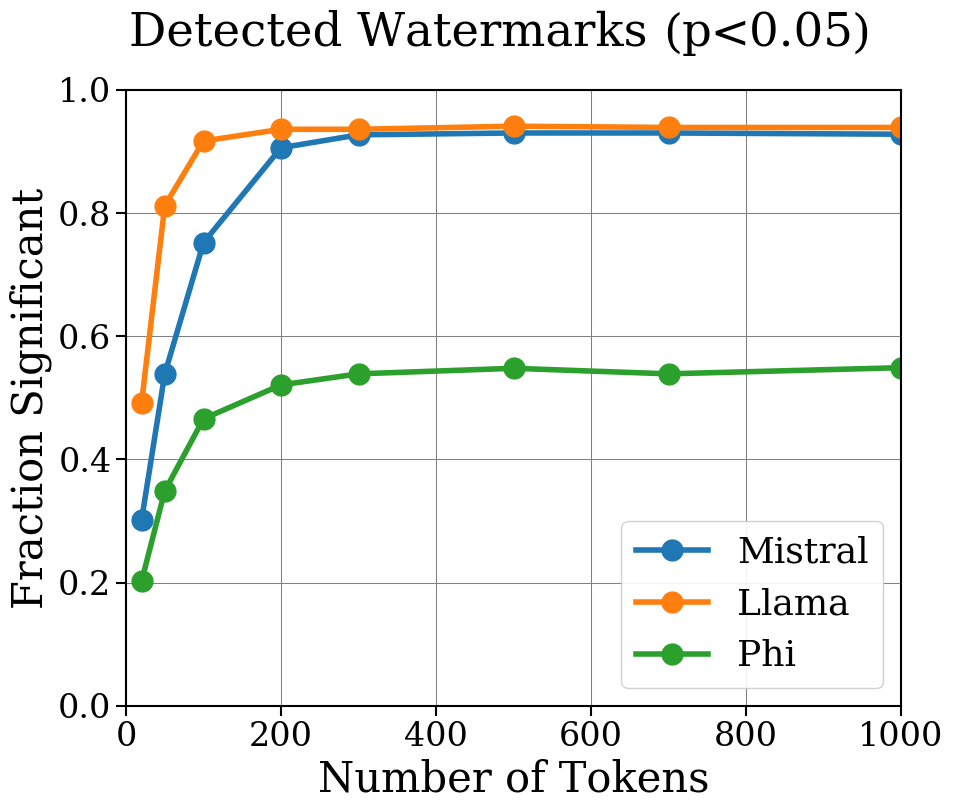

In [13]:
# model = 'microsoft/Phi-3-mini-4k-instruct'
# model = 'mistralai/Mistral-7B-v0.3'
# model = 'meta-llama/Meta-Llama-3.1-8B'
sig_pval = 0.05

good_models = {
    'Mistral': ('model.layers.30.mlp.up_proj.weight', 1e-05, 4),
    'Llama': ('model.layers.31.mlp.gate_proj.weight', 0.0003, 4),
    'Phi': ('model.layers.31.mlp.down_proj.weight', 3e-05, 4)
}
model_mappings = {
    'Mistral': 'mistralai/Mistral-7B-v0.3',
    'Llama': 'meta-llama/Meta-Llama-3.1-8B',
    'Phi': 'microsoft/Phi-3-mini-4k-instruct'
}



fig, ax = plt.subplots()
for model, param in good_models.items():
    model_name = model_mappings[model]
    data_dict = num_tokens_data[model_name][param]
    num_tokens, num_passed = get_numtokens_numpassed(data_dict, sig_pval=sig_pval)
    ax.plot(num_tokens, num_passed, label=model, marker='o')

ax.legend()
# ax.axhline(1.0, color='black', linestyle='--', alpha=0.5)
ax.set_ylim(0, 1)
ax.set_xlabel('Number of Tokens')
ax.set_ylabel('Fraction Significant')
fig.suptitle(f"Detected Watermarks (p<{sig_pval})")


if save_figs:
    fig.savefig(os.path.join(figs_parent, 'numtokens-numpassed-05.png'))

plt.show()

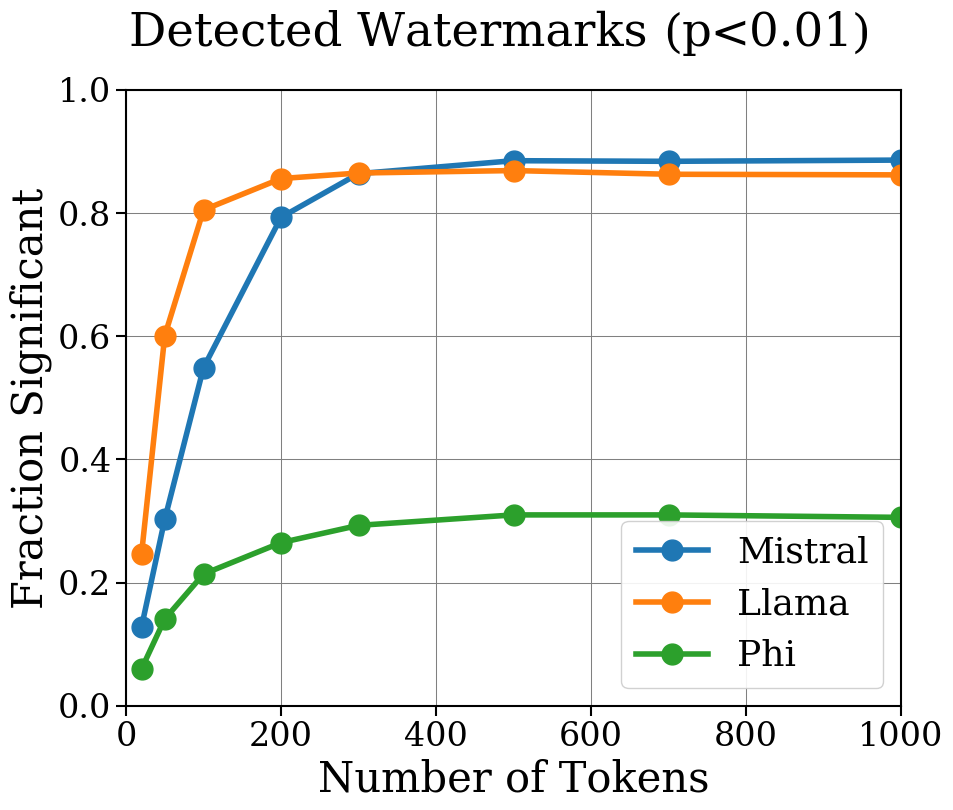

In [105]:

sig_pval = 0.01

fig, ax = plt.subplots()
for model, param in good_models.items():
    model_name = model_mappings[model]
    data_dict = num_tokens_data[model_name][param]
    num_tokens, num_passed = get_numtokens_numpassed(data_dict, sig_pval=sig_pval)
    ax.plot(num_tokens, num_passed, label=model, marker='o')

ax.legend()
# ax.axhline(1.0, color='black', linestyle='--', alpha=0.5)
ax.set_ylim(0, 1)
ax.set_xlabel('Number of Tokens')
ax.set_ylabel('Fraction Significant')
fig.suptitle(f"Detected Watermarks (p<{sig_pval})")

if save_figs:
    fig.savefig(os.path.join(figs_parent, 'numtokens-numpassed-01.png'))

plt.show()

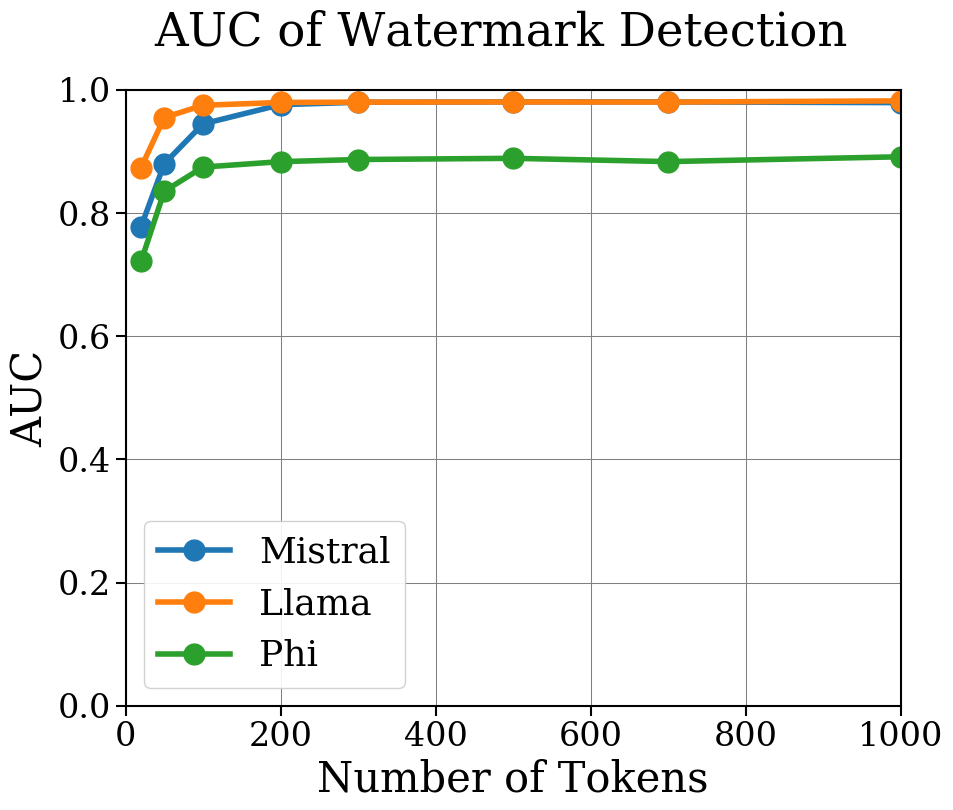

In [106]:
fig, ax = plt.subplots()
for model, param in good_models.items():
    model_name = model_mappings[model]
    data_dict = num_tokens_data[model_name][param]
    # num_tokens, num_passed = get_numtokens_numpassed(data_dict, sig_pval=sig_pval)
    num_tokens, aucs = get_numtokens_auc(data_dict)
    ax.plot(num_tokens, aucs, label=model, marker='o')

ax.legend()
# ax.axhline(1.0, color='black', linestyle='--', alpha=0.5)
ax.set_ylim(0, 1)
ax.set_xlabel('Number of Tokens')
ax.set_ylabel('AUC')
fig.suptitle(f"AUC of Watermark Detection")

if save_figs:
    fig.savefig(os.path.join(figs_parent, 'numtokens-auc.png'))

plt.show()

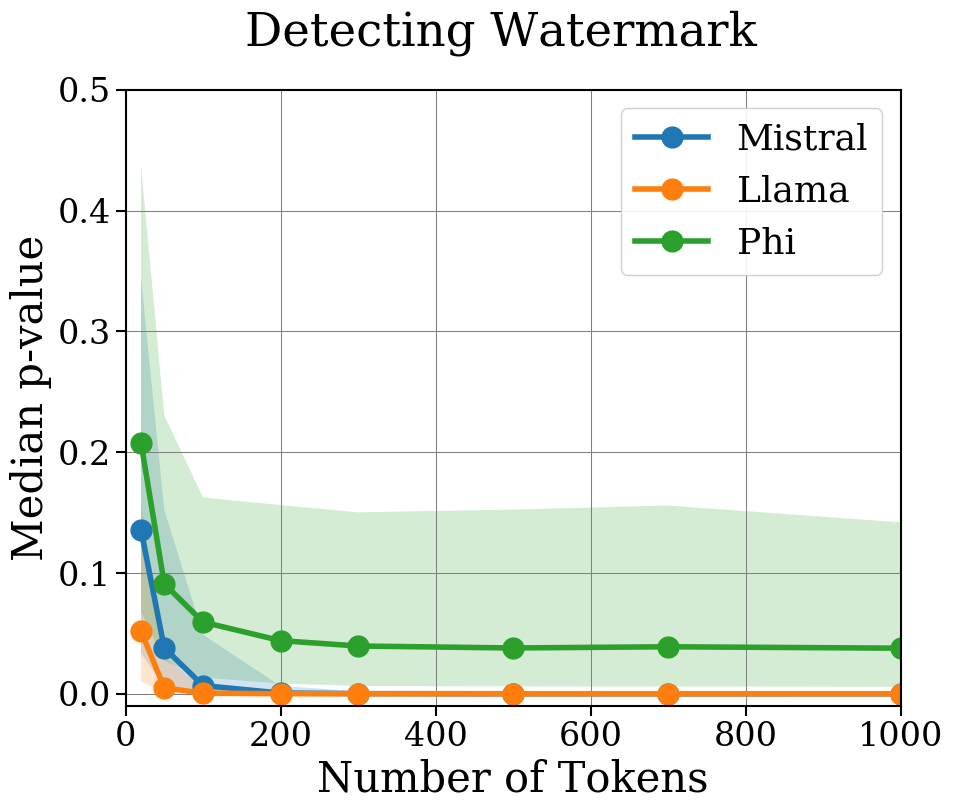

In [107]:
# model = 'microsoft/Phi-3-mini-4k-instruct'
# model = 'mistralai/Mistral-7B-v0.3'
# model = 'meta-llama/Meta-Llama-3.1-8B'
min_quantile = 0.25
max_quantile = 0.75
fig, ax = plt.subplots()
for model, param in good_models.items():
    model_name = model_mappings[model]
    data_dict = num_tokens_data[model_name][param]
    num_tokens, medians, quantiles = get_nunmtokens_medians(data_dict, quantiles=[min_quantile, max_quantile])

    lbs  = [quantile[min_quantile] for quantile in quantiles]
    ubs = [quantile[max_quantile] for quantile in quantiles]
    ax.plot(num_tokens, medians, label=model, marker='o')
    ax.fill_between(num_tokens, lbs, ubs, alpha=0.2)

ax.legend()
# ax.axhline(1.0, color='black', linestyle='--', alpha=0.5)
ax.set_ylim(-0.01, 0.5)
ax.set_xlabel('Number of Tokens')
ax.set_ylabel('Median p-value')
fig.suptitle(f"Detecting Watermark")

if save_figs:
    fig.savefig(os.path.join(figs_parent, 'Fig-1-numtokens-medians-phi.png'))

plt.show()

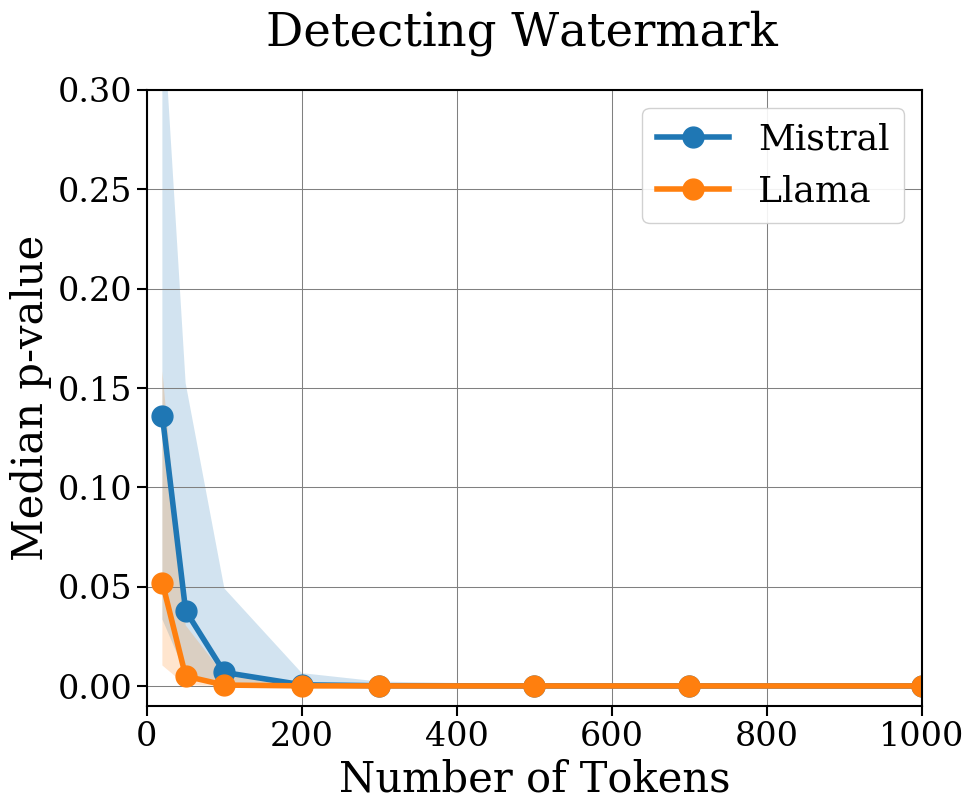

In [108]:
# model = 'microsoft/Phi-3-mini-4k-instruct'
# model = 'mistralai/Mistral-7B-v0.3'
# model = 'meta-llama/Meta-Llama-3.1-8B'
min_quantile = 0.25
max_quantile = 0.75
fig, ax = plt.subplots()
for model, param in good_models.items():
    if model == 'Phi':
        continue
    model_name = model_mappings[model]
    data_dict = num_tokens_data[model_name][param]
    num_tokens, medians, quantiles = get_nunmtokens_medians(data_dict, quantiles=[min_quantile, max_quantile])

    lbs  = [quantile[min_quantile] for quantile in quantiles]
    ubs = [quantile[max_quantile] for quantile in quantiles]
    ax.plot(num_tokens, medians, label=model, marker='o')
    ax.fill_between(num_tokens, lbs, ubs, alpha=0.2)

ax.legend()
# ax.axhline(1.0, color='black', linestyle='--', alpha=0.5)
ax.set_ylim(-0.01, 0.3)
ax.set_xlabel('Number of Tokens')
ax.set_ylabel('Median p-value')
fig.suptitle(f"Detecting Watermark")

if save_figs:
    fig.savefig(os.path.join(figs_parent, 'Fig-1-numtokens-medians-no-phi.png'))

plt.show()

# Getting Squared Norms

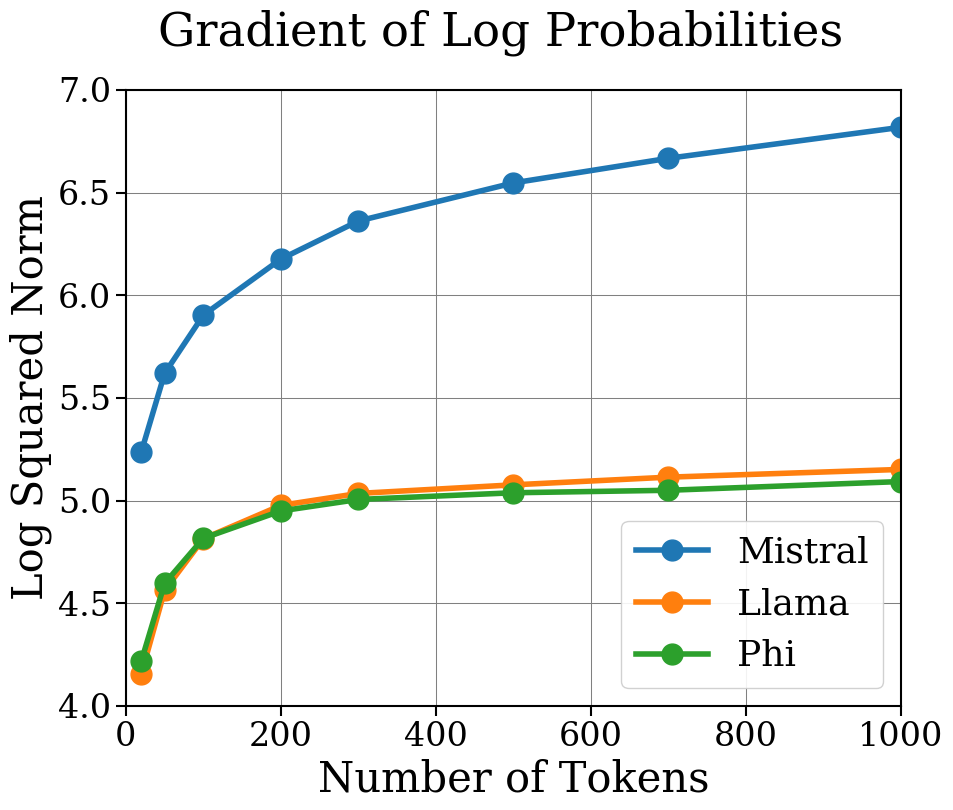

In [109]:
fig, ax = plt.subplots()
for model, param in good_models.items():
    model_name = model_mappings[model]
    data_dict = num_tokens_data[model_name][param]
    added_var = param[1]
    # num_tokens, num_passed = get_numtokens_numpassed(data_dict, sig_pval=sig_pval)
    num_tokens, avg_squared_norms, stderrs = get_avg_squared_norms(data_dict, added_var)
    ax.plot(num_tokens, np.log10(avg_squared_norms), label=model, marker='o')

ax.legend()
# ax.axhline(1.0, color='black', linestyle='--', alpha=0.5)
# ax.set_ylim(0, 1)
ax.set_xlabel('Number of Tokens')
ax.set_ylabel('Log Squared Norm')
fig.suptitle(f"Gradient of Log Probabilities")


if save_figs:
    fig.savefig(os.path.join(figs_parent, 'numtokens-gradnorm.png'))

plt.show()

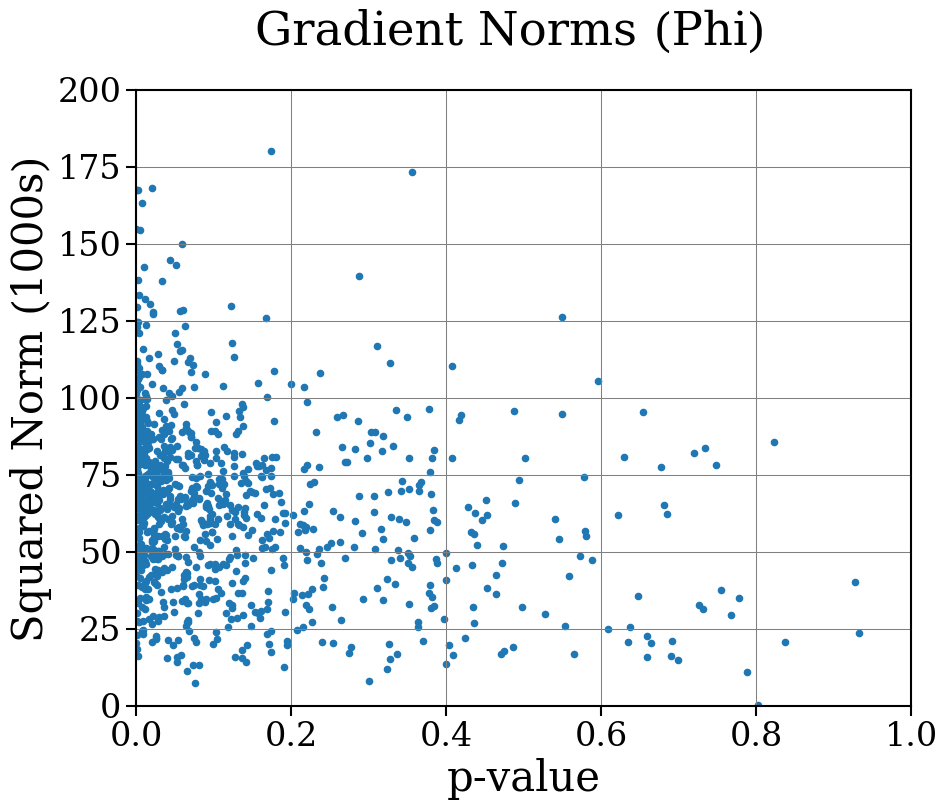

In [110]:
model = 'Phi'
model_name = model_mappings[model]
param = good_models[model]
data_df = num_tokens_data[model_name][param][100]
added_var = param[1]
data_df['squared_norm'] = data_df['variance'] / added_var

fig, ax = plt.subplots()
ax.scatter(data_df['pvalue'], data_df['squared_norm'] / 1000, s=20)
ax.set_xlabel('p-value')
ax.set_ylabel('Squared Norm (1000s)')
ax.set_ylim(0, 200)
fig.suptitle(f"Gradient Norms ({model})")

if save_figs:
    fig.savefig(os.path.join(figs_parent, 'gradnorm-pvalue-phi.png'))


plt.show()




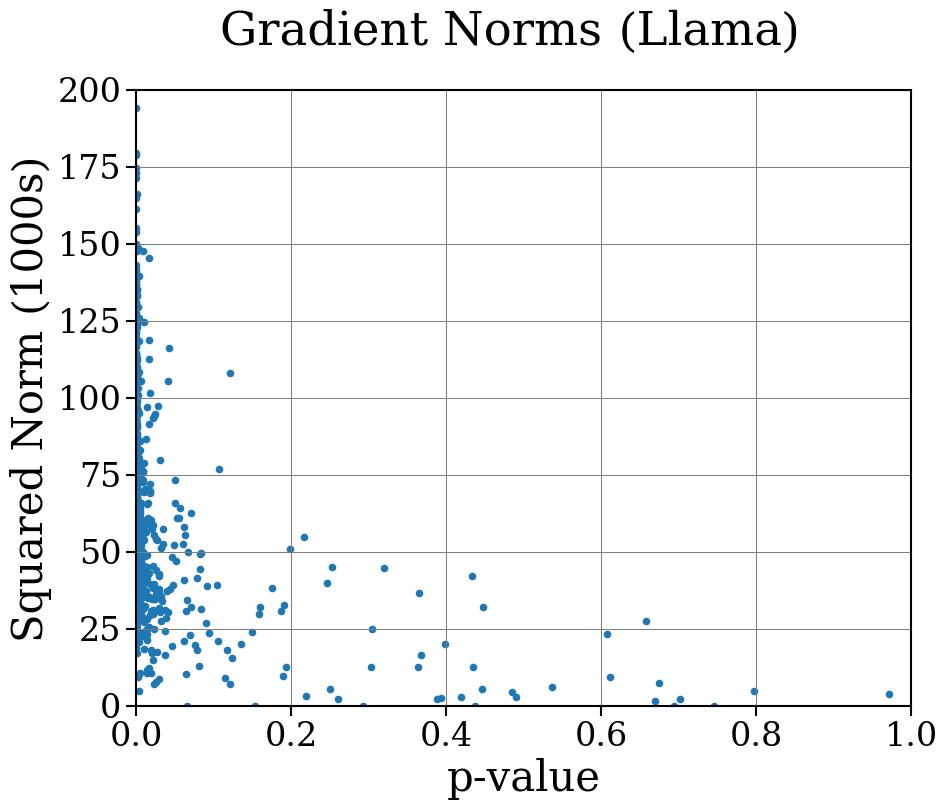

In [111]:
model = 'Llama'
model_name = model_mappings[model]
param = good_models[model]
data_df = num_tokens_data[model_name][param][100]
added_var = param[1]
data_df['squared_norm'] = data_df['variance'] / added_var

fig, ax = plt.subplots()
ax.scatter(data_df['pvalue'], data_df['squared_norm'] / 1000, s=20)
ax.set_xlabel('p-value')
ax.set_ylabel('Squared Norm (1000s)')
ax.set_ylim(0, 200)
fig.suptitle(f"Gradient Norms ({model})")

if save_figs:
    fig.savefig(os.path.join(figs_parent, 'gradnorm-pvalue-llama.png'))

plt.show()




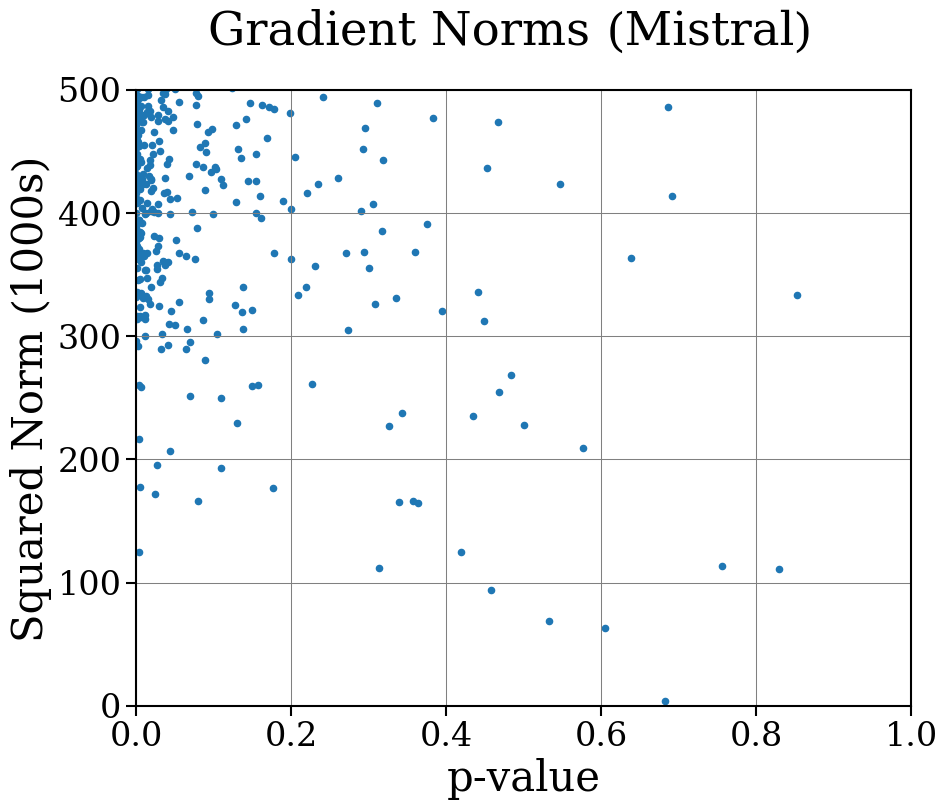

In [112]:
model = 'Mistral'
model_name = model_mappings[model]
param = good_models[model]
data_df = num_tokens_data[model_name][param][100]
added_var = param[1]
data_df['squared_norm'] = data_df['variance'] / added_var

fig, ax = plt.subplots()
ax.scatter(data_df['pvalue'], data_df['squared_norm'] / 1000, s=20)
ax.set_xlabel('p-value')
ax.set_ylabel('Squared Norm (1000s)')
ax.set_ylim(0, 500)
fig.suptitle(f"Gradient Norms ({model})")

if save_figs:
    fig.savefig(os.path.join(figs_parent, 'gradnorm-pvalue-mistral.png'))

plt.show()




In [113]:
def get_median_pval_by_norm(data_df, grid_size=500, quantiles = [0.25, 0.75]):
    
    grid = np.linspace(0, data_df['squared_norm'].max(), grid_size)
    medians, lbs, ubs = [], [], []

    for i in range(grid_size - 1):
        mask =  (data_df['squared_norm'] < grid[i + 1])
        medians.append(data_df[mask]['pvalue'].median())
        lbs.append(data_df[mask]['pvalue'].quantile(quantiles[0]))
        ubs.append(data_df[mask]['pvalue'].quantile(quantiles[1]))
    
    # mask = data_df['squared_norm'][data_df['squared_norm'] <= data_df['squared_norm'].max()]
    # medians.append(data_df[mask]['pvalue'].median())
    # lbs.append(data_df[mask]['pvalue'].quantile(quantiles[0]))
    # ubs.append(data_df[mask]['pvalue'].quantile(quantiles[1]))
    return grid[:-1], medians, lbs, ubs

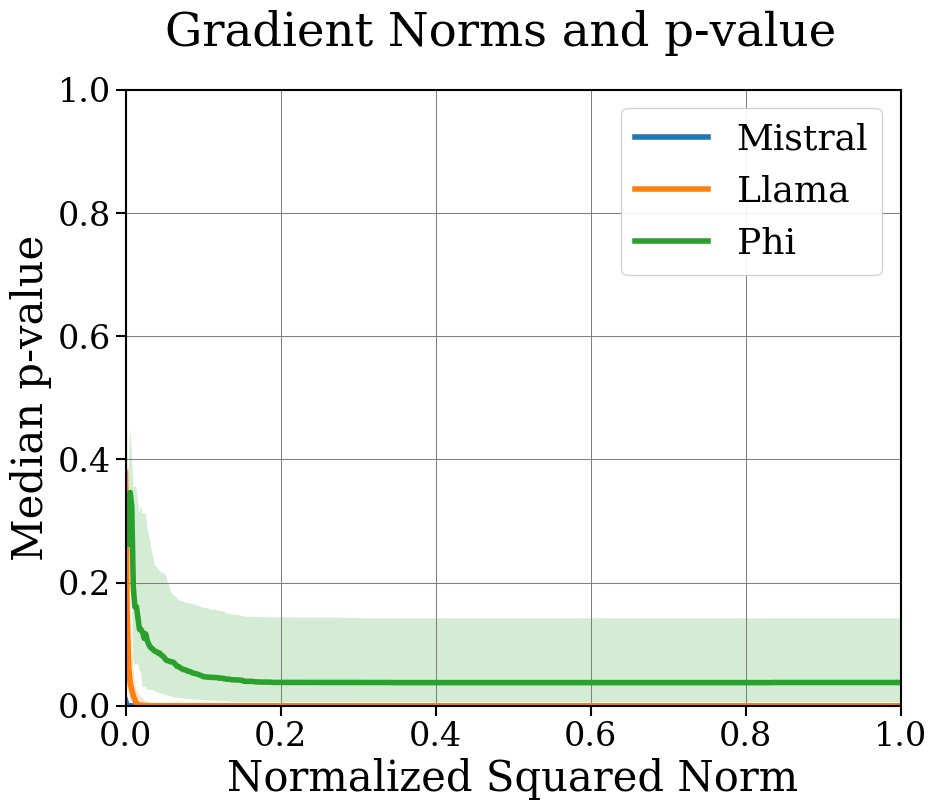

In [114]:
# model = 'Phi'
fig, ax = plt.subplots()
sig_pval = 0.05
for model in good_models.keys():
    grid_size=  500
    model_name = model_mappings[model]
    param = good_models[model]
    data_df = num_tokens_data[model_name][param][1000]
    added_var = param[1]
    data_df['squared_norm'] = data_df['variance'] / added_var

    grid, medians, lbs, ubs = get_median_pval_by_norm(data_df, grid_size=grid_size)
    grid = grid / np.max(grid)

    ax.plot(grid, medians, label=model)
    ax.fill_between(grid, lbs, ubs, alpha=0.2)

# ax.axhline(sig_pval, color='black', linestyle='--', alpha=0.5)
ax.legend()
ax.set_xlabel('Normalized Squared Norm')
ax.set_ylabel('Median p-value')
ax.set_ylim(0, 1)
# ax.set_xlim(0.5, 1)
fig.suptitle(f"Gradient Norms and p-value")

if save_figs:
    fig.savefig(os.path.join(figs_parent, 'gradnorm-pvalue-median-phi.png'))

plt.show()




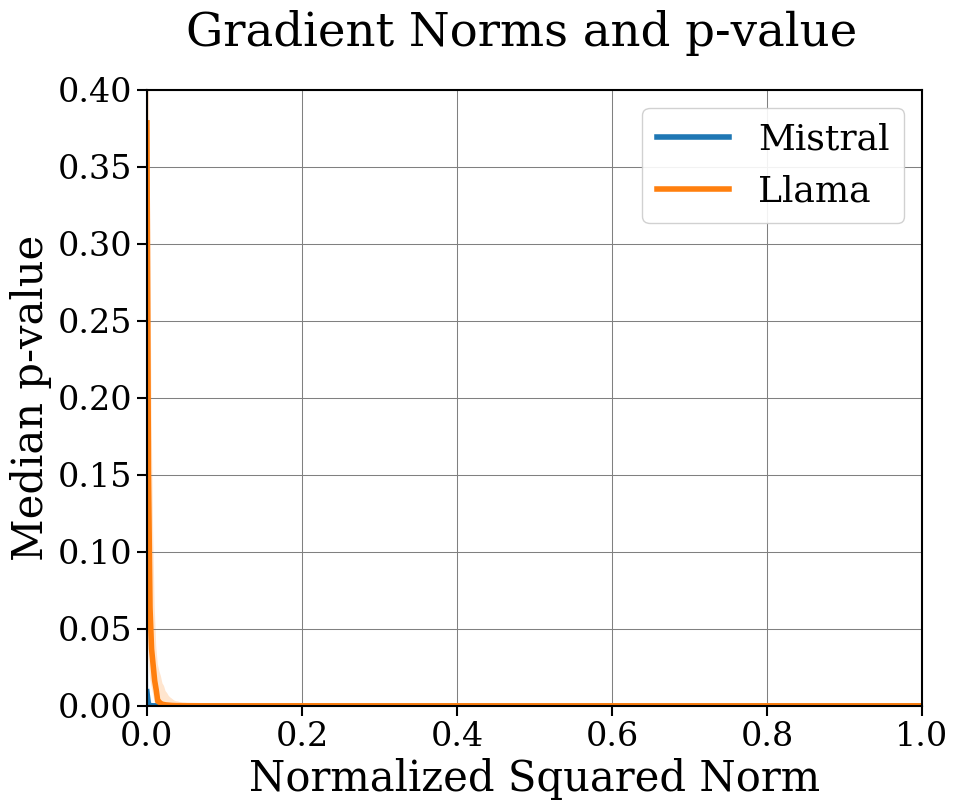

In [115]:
# model = 'Phi'
fig, ax = plt.subplots()
sig_pval = 0.05
for model in good_models.keys():
    if model == 'Phi':
        continue
    grid_size=  500
    model_name = model_mappings[model]
    param = good_models[model]
    data_df = num_tokens_data[model_name][param][1000]
    added_var = param[1]
    data_df['squared_norm'] = data_df['variance'] / added_var

    grid, medians, lbs, ubs = get_median_pval_by_norm(data_df, grid_size=grid_size)
    grid = grid / np.max(grid)

    ax.plot(grid, medians, label=model)
    ax.fill_between(grid, lbs, ubs, alpha=0.2)

# ax.axhline(sig_pval, color='black', linestyle='--', alpha=0.5)
ax.legend()
ax.set_xlabel('Normalized Squared Norm')
ax.set_ylabel('Median p-value')
ax.set_ylim(0, 0.4)
# ax.set_xlim(0.5, 1)
fig.suptitle(f"Gradient Norms and p-value")

if save_figs:
    fig.savefig(os.path.join(figs_parent, 'gradnorm-pvalue-median-no-phi.png'))

plt.show()




# Corruptions Ablations

In [116]:
# parents = [
#     '09-19-corrupt-phi',
#     # '09-19-corrupt-mistral',
#     '09-19-roundtrip-translation',
#     # '09-19-roundtrip-translation-laser',
#     '09-19-corrupt-llama',
#     '09-19-roundtrip-translation-llama',
#     # '09-19-roundtrip-translation-llama-laser',
#     '09-23-corrupt-mistral'

# ]


parents = [
    '09-23-corrupt-phi',
    '09-23-corrupt-llama',
    '09-23-corrupt-mistral',
]

parents = [os.path.join('./amlt', parent) for parent in parents]

corrupt_generations = get_corruptions(parents, good_models)


Error processing ./amlt/09-23-corrupt-mistral/grid_09-23-corrupt-mistral_cor_add_start_tokens_tok_0.01_wat_mistralai_Mistral-7B-v0.3_____64_____30___up_proj___weight_____1e-05: [Errno 2] No such file or directory: './amlt/09-23-corrupt-mistral/grid_09-23-corrupt-mistral_cor_add_start_tokens_tok_0.01_wat_mistralai_Mistral-7B-v0.3_____64_____30___up_proj___weight_____1e-05/generations.json'


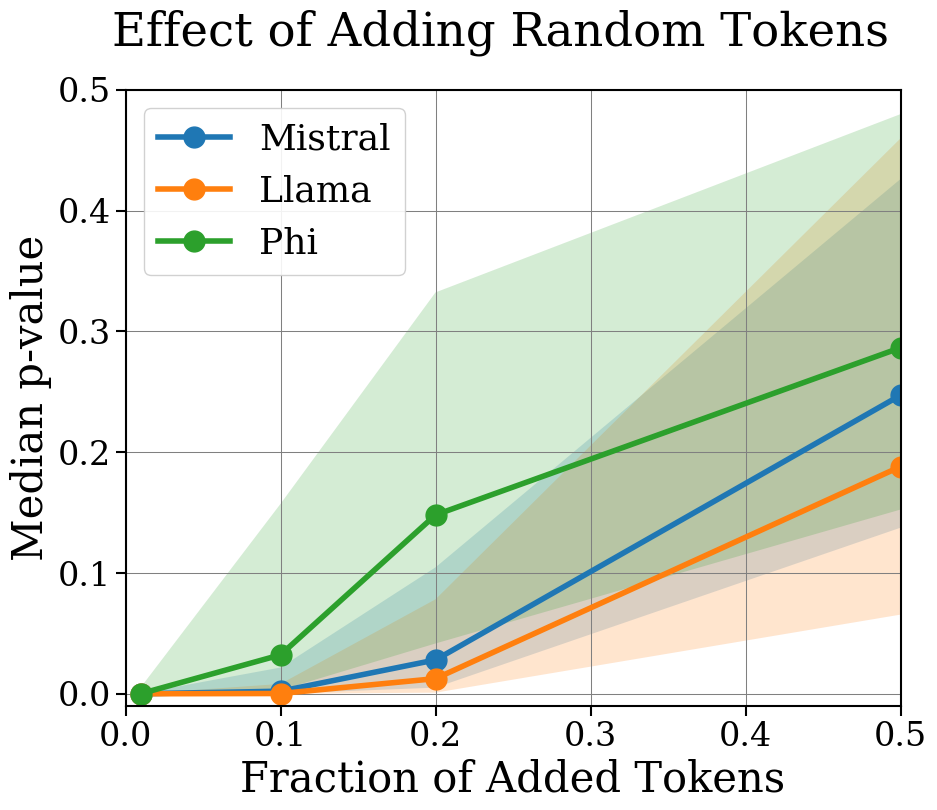

In [117]:
corrupt_models = {
    'Mistral': ('model.layers.30.mlp.up_proj.weight', 1e-05, 64),
    'Llama': ('model.layers.31.mlp.gate_proj.weight', 0.0003, 64),
    'Phi': ('model.layers.31.mlp.down_proj.weight', 3e-05, 0)
}
model_mappings = {
    'Mistral': 'mistralai/Mistral-7B-v0.3',
    'Llama': 'meta-llama/Meta-Llama-3.1-8B',
    'Phi': 'microsoft/Phi-3-mini-4k-instruct'
}


corruption_type = 'add_random_tokens'

min_quantile = 0.25
max_quantile = 0.75
fig, ax = plt.subplots()
for model, param in corrupt_models.items():
    # model_name = model_mappings[model]
    # data_dict = num_tokens_data[model_name][param]
    key = (param, model_mappings[model])

    data_dict = {numtok: get_corrupt_pvalues(corrupt_generations[key][corruption_type][numtok]) for numtok in corrupt_generations[key][corruption_type].keys()}

    num_tokens, medians, quantiles = get_nunmtokens_medians(data_dict, quantiles=[min_quantile, max_quantile])

    lbs  = [quantile[min_quantile] for quantile in quantiles]
    ubs = [quantile[max_quantile] for quantile in quantiles]
    ax.plot(num_tokens, medians, label=model, marker='o')
    ax.fill_between(num_tokens, lbs, ubs, alpha=0.2)

ax.legend()
ax.set_ylim(-0.01, 0.5)
ax.set_xlabel('Fraction of Added Tokens')
ax.set_ylabel('Median p-value')
fig.suptitle(f"Effect of Adding Random Tokens")


if save_figs:
    fig.savefig(os.path.join(figs_parent, 'Fig-2-corrupt-add-random.png'))

plt.show()

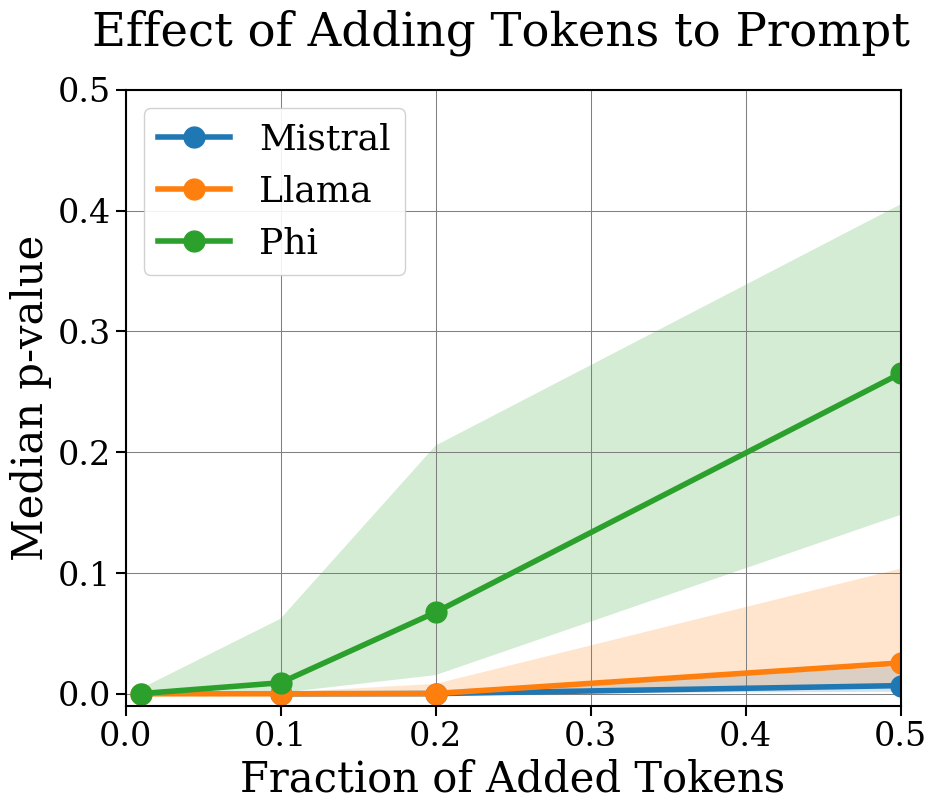

In [118]:
corruption_type = 'add_start_tokens'

min_quantile = 0.25
max_quantile = 0.75
fig, ax = plt.subplots()
for model, param in corrupt_models.items():
    # model_name = model_mappings[model]
    # data_dict = num_tokens_data[model_name][param]
    key = (param, model_mappings[model])

    data_dict = {numtok: get_corrupt_pvalues(corrupt_generations[key][corruption_type][numtok]) for numtok in corrupt_generations[key][corruption_type].keys()}

    num_tokens, medians, quantiles = get_nunmtokens_medians(data_dict, quantiles=[min_quantile, max_quantile])

    lbs  = [quantile[min_quantile] for quantile in quantiles]
    ubs = [quantile[max_quantile] for quantile in quantiles]
    ax.plot(num_tokens, medians, label=model, marker='o')
    ax.fill_between(num_tokens, lbs, ubs, alpha=0.2)

ax.legend()
ax.set_ylim(-0.01, 0.5)
ax.set_xlabel('Fraction of Added Tokens')
ax.set_ylabel('Median p-value')
fig.suptitle(f"Effect of Adding Tokens to Prompt")

if save_figs:
    fig.savefig(os.path.join(figs_parent, 'Fig-2-corrupt-add-start.png'))

plt.show()

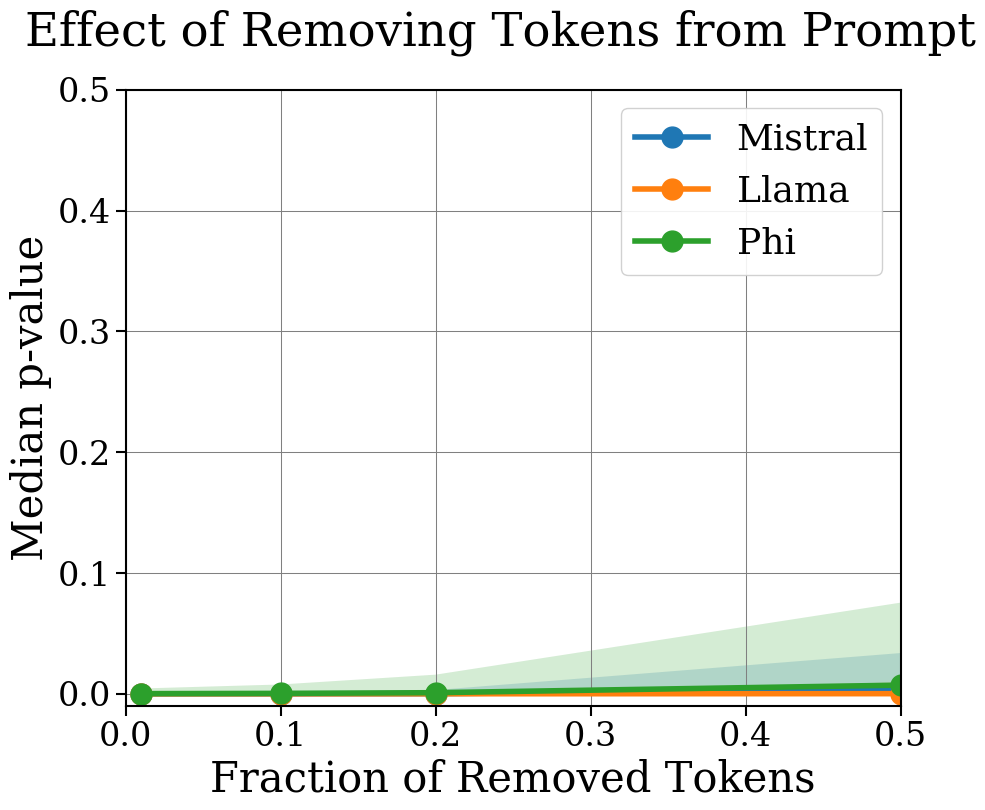

In [119]:
corruption_type = 'remove_start_tokens'

min_quantile = 0.25
max_quantile = 0.75
fig, ax = plt.subplots()
for model, param in corrupt_models.items():
    # model_name = model_mappings[model]
    # data_dict = num_tokens_data[model_name][param]
    key = (param, model_mappings[model])

    data_dict = {numtok: get_corrupt_pvalues(corrupt_generations[key][corruption_type][numtok]) for numtok in corrupt_generations[key][corruption_type].keys()}

    num_tokens, medians, quantiles = get_nunmtokens_medians(data_dict, quantiles=[min_quantile, max_quantile])

    lbs  = [quantile[min_quantile] for quantile in quantiles]
    ubs = [quantile[max_quantile] for quantile in quantiles]
    ax.plot(num_tokens, medians, label=model, marker='o')
    ax.fill_between(num_tokens, lbs, ubs, alpha=0.2)

ax.legend()
ax.set_ylim(-0.01, 0.5)
ax.set_xlabel('Fraction of Removed Tokens')
ax.set_ylabel('Median p-value')
fig.suptitle(f"Effect of Removing Tokens from Prompt")

if save_figs:
    fig.savefig(os.path.join(figs_parent, 'Fig-2-corrupt-remove-start.png'))

plt.show()

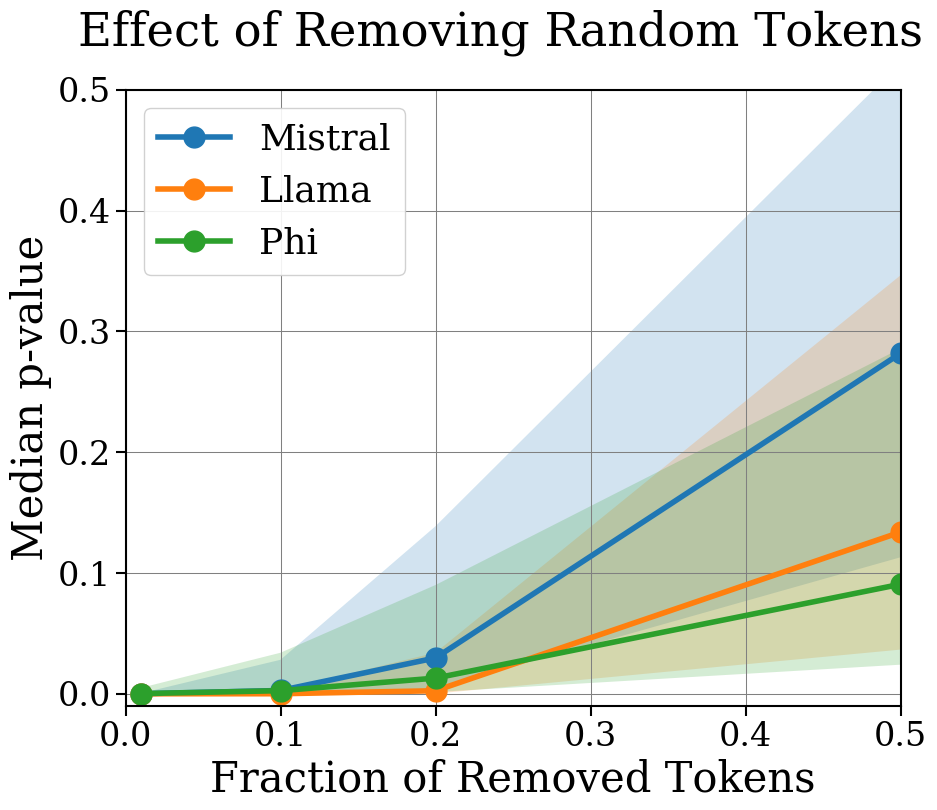

In [120]:
corruption_type = 'remove_random_tokens'

min_quantile = 0.25
max_quantile = 0.75
fig, ax = plt.subplots()
for model, param in corrupt_models.items():
    # model_name = model_mappings[model]
    # data_dict = num_tokens_data[model_name][param]
    key = (param, model_mappings[model])

    data_dict = {numtok: get_corrupt_pvalues(corrupt_generations[key][corruption_type][numtok]) for numtok in corrupt_generations[key][corruption_type].keys()}

    num_tokens, medians, quantiles = get_nunmtokens_medians(data_dict, quantiles=[min_quantile, max_quantile])

    lbs  = [quantile[min_quantile] for quantile in quantiles]
    ubs = [quantile[max_quantile] for quantile in quantiles]
    ax.plot(num_tokens, medians, label=model, marker='o')
    ax.fill_between(num_tokens, lbs, ubs, alpha=0.2)

ax.legend()
ax.set_ylim(-0.01, 0.5)
ax.set_xlabel('Fraction of Removed Tokens')
ax.set_ylabel('Median p-value')
fig.suptitle(f"Effect of Removing Random Tokens")

if save_figs:
    fig.savefig(os.path.join(figs_parent, 'Fig-2-corrupt-remove-random.png'))

plt.show()

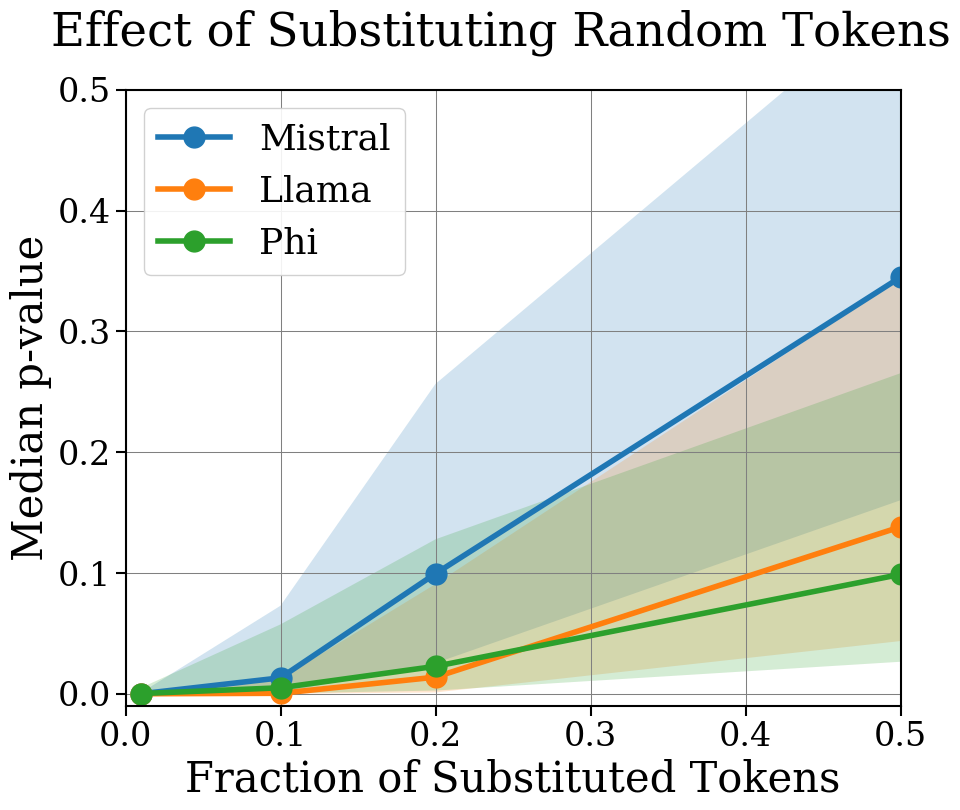

In [121]:
corruption_type = 'substitute_random_tokens'

min_quantile = 0.25
max_quantile = 0.75
fig, ax = plt.subplots()
for model, param in corrupt_models.items():
    # model_name = model_mappings[model]
    # data_dict = num_tokens_data[model_name][param]
    key = (param, model_mappings[model])

    data_dict = {numtok: get_corrupt_pvalues(corrupt_generations[key][corruption_type][numtok]) for numtok in corrupt_generations[key][corruption_type].keys()}

    num_tokens, medians, quantiles = get_nunmtokens_medians(data_dict, quantiles=[min_quantile, max_quantile])

    lbs  = [quantile[min_quantile] for quantile in quantiles]
    ubs = [quantile[max_quantile] for quantile in quantiles]
    ax.plot(num_tokens, medians, label=model, marker='o')
    ax.fill_between(num_tokens, lbs, ubs, alpha=0.2)

ax.legend()
ax.set_ylim(-0.01, 0.5)
ax.set_xlabel('Fraction of Substituted Tokens')
ax.set_ylabel('Median p-value')
fig.suptitle(f"Effect of Substituting Random Tokens")

if save_figs:
    fig.savefig(os.path.join(figs_parent, 'Fig-2-corrupt-substitute-random.png'))

plt.show()

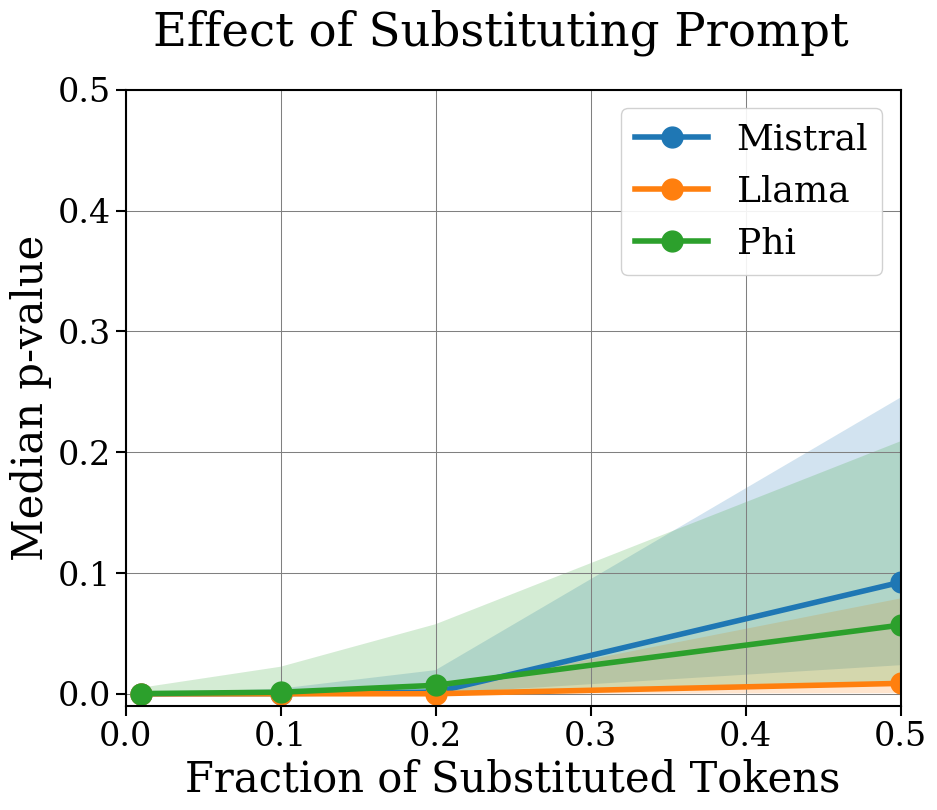

In [122]:
corruption_type = 'substitute_start_tokens'

min_quantile = 0.25
max_quantile = 0.75
fig, ax = plt.subplots()
for model, param in corrupt_models.items():
    # model_name = model_mappings[model]
    # data_dict = num_tokens_data[model_name][param]
    key = (param, model_mappings[model])

    data_dict = {numtok: get_corrupt_pvalues(corrupt_generations[key][corruption_type][numtok]) for numtok in corrupt_generations[key][corruption_type].keys()}

    num_tokens, medians, quantiles = get_nunmtokens_medians(data_dict, quantiles=[min_quantile, max_quantile])

    lbs  = [quantile[min_quantile] for quantile in quantiles]
    ubs = [quantile[max_quantile] for quantile in quantiles]
    ax.plot(num_tokens, medians, label=model, marker='o')
    ax.fill_between(num_tokens, lbs, ubs, alpha=0.2)

ax.legend()
ax.set_ylim(-0.01, 0.5)
ax.set_xlabel('Fraction of Substituted Tokens')
ax.set_ylabel('Median p-value')
fig.suptitle(f"Effect of Substituting Prompt")

if save_figs:
    fig.savefig(os.path.join(figs_parent, 'Fig-2-corrupt-substitute-start.png'))

plt.show()

## Roundtrip translation

In [123]:
parents = [
    '09-23-roundtrip-translation-mistral',
    '09-19-roundtrip-translation-llama',
    '09-19-roundtrip-translation',
    '09-29-roundtrip-translation'
]

parents = [os.path.join('./amlt', parent) for parent in parents]


roundtrip_gens = get_roundtirp_translations(parents)


In [124]:
default_cycler = plt.rcParams['axes.prop_cycle']
default_cycler = [c['color'] for c in default_cycler]

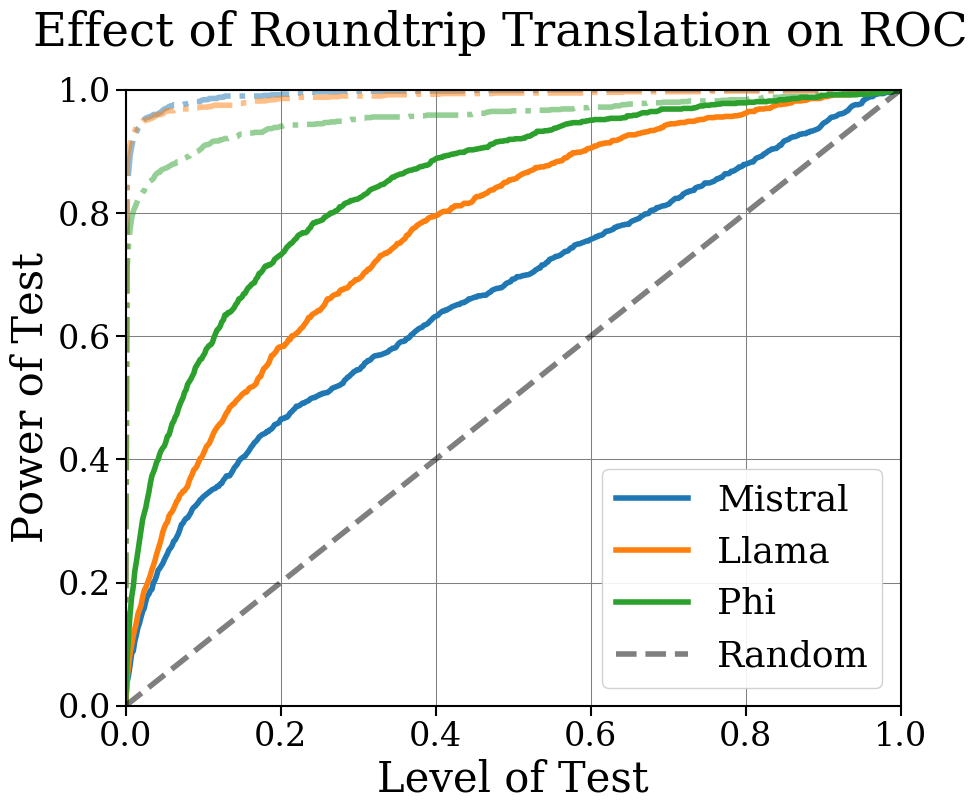

In [125]:


fig, ax = plt.subplots()

for i, model in enumerate(model_mappings.keys()):

    model_name = model_mappings[model]
    key = (corrupt_models[model], model_name)
    roundtrip = roundtrip_gens[key]['roundtrip_translation']
    uncorrupted = roundtrip_gens[key]['uncorrupted']

    roundtrip = get_all(roundtrip, 1e-20)
    uncorrupted = get_all(uncorrupted, 1e-20)

    grid, cdf = get_empirical_cdf(roundtrip['pvalue'], grid_size=500)
    # ax.plot(grid, cdf, color=default_cycler[i], label=f"{model} (Corrupted)")
    ax.plot(grid, cdf, color=default_cycler[i], label=f"{model}")

    grid, cdf = get_empirical_cdf(uncorrupted['pvalue'], grid_size=500)
    # ax.plot(grid, cdf, color=default_cycler[i], linestyle='-.', label=f"{model} (Uncorrupted)", alpha=0.5)
    ax.plot(grid, cdf, color=default_cycler[i], linestyle='-.', alpha=0.5)

ax.plot(grid, grid, linestyle='--', alpha = 0.5, color='black', label='Random')
ax.legend()
ax.set_xlabel('Level of Test')
ax.set_ylabel('Power of Test')
ax.set_ylim(0, 1)

fig.suptitle("Effect of Roundtrip Translation on ROC")

if save_figs:
    fig.savefig(os.path.join(figs_parent, 'roundtrip-translation-roc.png'))

plt.show()




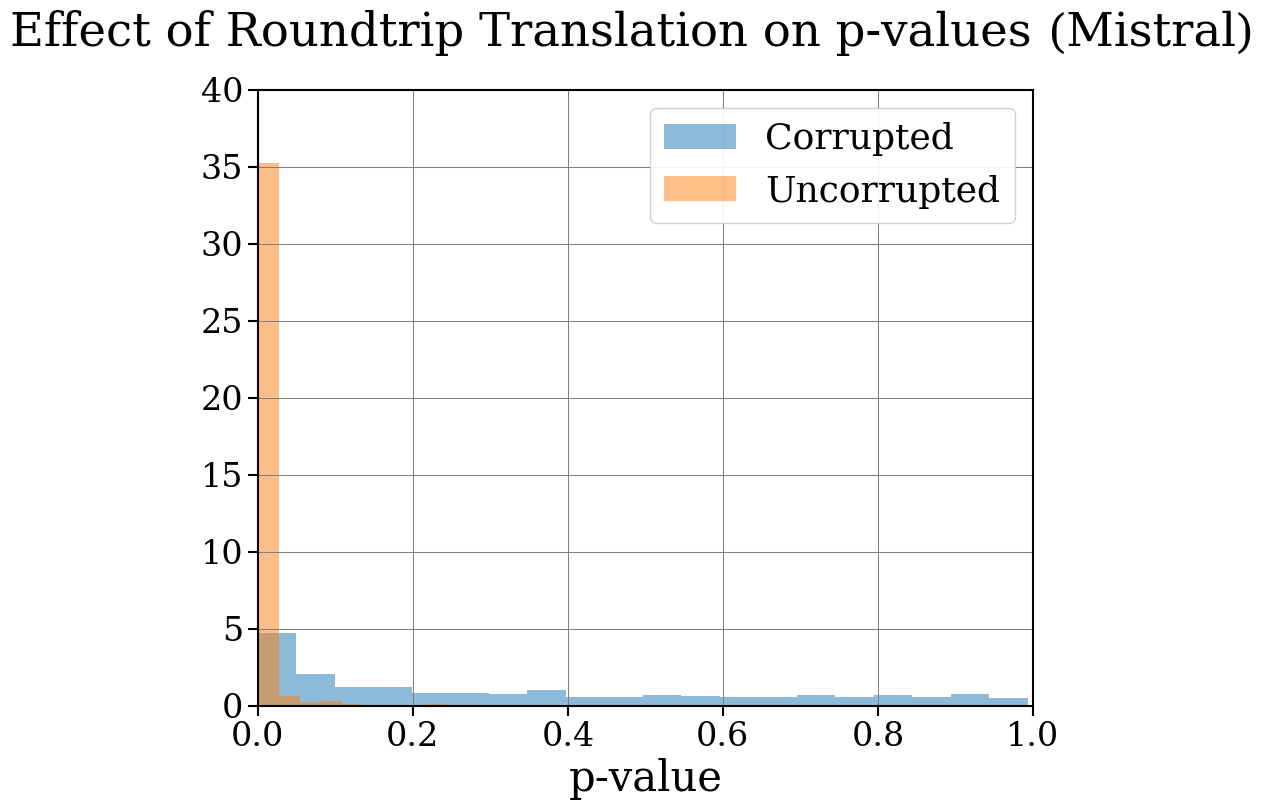

In [126]:
model = 'Mistral'

bins = 20
model_name = model_mappings[model]
key = (corrupt_models[model], model_name)
roundtrip = roundtrip_gens[key]['roundtrip_translation']
uncorrupted = roundtrip_gens[key]['uncorrupted']

roundtrip = get_all(roundtrip, 1e-20)
uncorrupted = get_all(uncorrupted, 1e-20)

fig, ax = plt.subplots()

ax.hist(roundtrip['pvalue'], bins=bins, alpha=0.5, label='Corrupted', density=True)
ax.hist(uncorrupted['pvalue'], bins=bins, alpha=0.5, label='Uncorrupted', density=True)

ax.legend()
ax.set_xlabel('p-value')

fig.suptitle(f"Effect of Roundtrip Translation on p-values ({model})")

if save_figs:
    fig.savefig(os.path.join(figs_parent, 'roundtrip-translation-pvalue-mistral.png'))

plt.show()



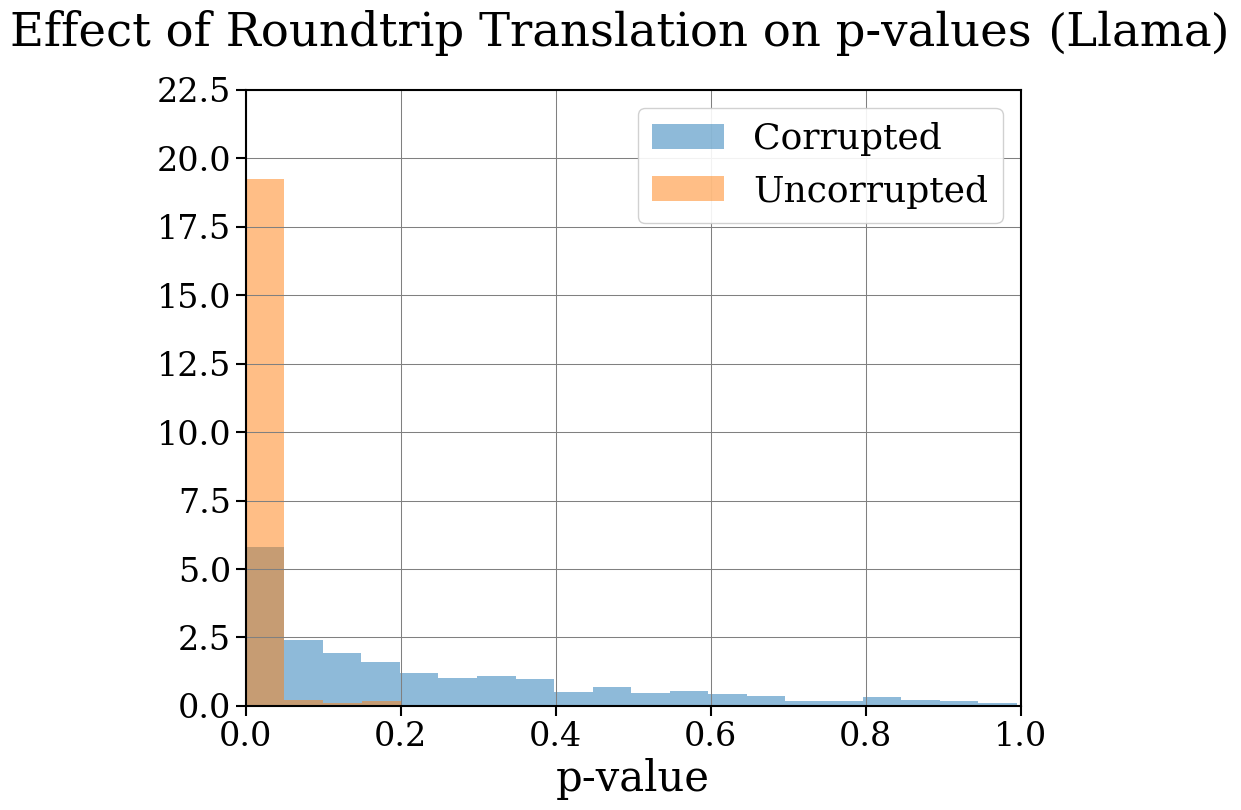

In [127]:
model = 'Llama'


model_name = model_mappings[model]
key = (corrupt_models[model], model_name)
roundtrip = roundtrip_gens[key]['roundtrip_translation']
uncorrupted = roundtrip_gens[key]['uncorrupted']

roundtrip = get_all(roundtrip, 1e-20)
uncorrupted = get_all(uncorrupted, 1e-20)

fig, ax = plt.subplots()

ax.hist(roundtrip['pvalue'], bins=bins, alpha=0.5, label='Corrupted', density=True)
ax.hist(uncorrupted['pvalue'], bins=bins, alpha=0.5, label='Uncorrupted', density=True)

ax.legend()
ax.set_xlabel('p-value')

fig.suptitle(f"Effect of Roundtrip Translation on p-values ({model})")

if save_figs:
    fig.savefig(os.path.join(figs_parent, 'roundtrip-translation-pvalue-llama.png'))

plt.show()



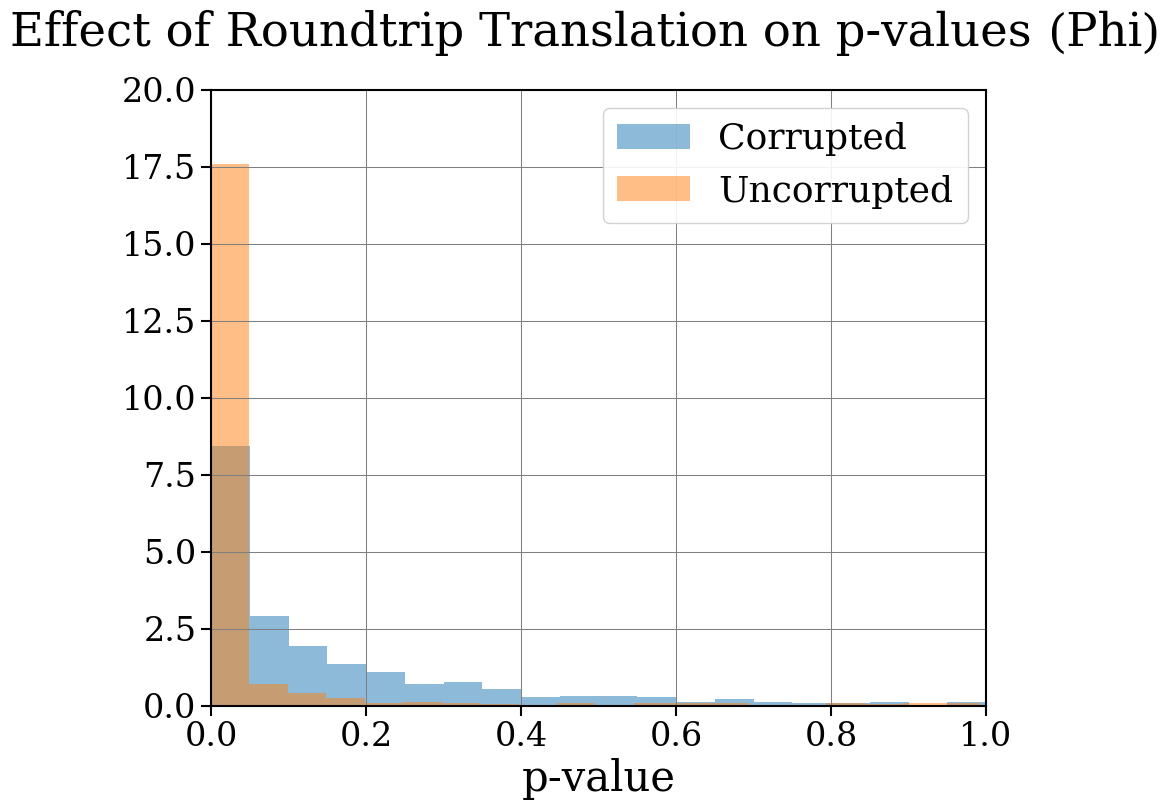

In [128]:
model = 'Phi'


model_name = model_mappings[model]
key = (corrupt_models[model], model_name)
roundtrip = roundtrip_gens[key]['roundtrip_translation']
uncorrupted = roundtrip_gens[key]['uncorrupted']

roundtrip = get_all(roundtrip, 1e-20)
uncorrupted = get_all(uncorrupted, 1e-20)

fig, ax = plt.subplots()

ax.hist(roundtrip['pvalue'], bins=bins, alpha=0.5, label='Corrupted', density=True)
ax.hist(uncorrupted['pvalue'], bins=bins, alpha=0.5, label='Uncorrupted', density=True)

ax.legend()
ax.set_xlabel('p-value')

fig.suptitle(f"Effect of Roundtrip Translation on p-values ({model})")

if save_figs:
    fig.savefig(os.path.join(figs_parent, 'roundtrip-translation-pvalue-phi.png'))

plt.show()



# Effect of changing variance

In [61]:

parents = [
    './amlt/09-23-watermark-mistral',
    './amlt/09-22-watermark-phi',
    './amlt/09-22-watermark-llama',
    # './amlt/09-18-watermark-r0',
    # './amlt/09-18-watermark-r64',
    # './amlt/09-18-watermark-phi-r0',
]

generations = {}
metrics = {}
for parent in parents:
    gens = get_generations(parent)
    temp_metrics = get_metrics(parent)
    recursively_update_dict(generations, gens)
    recursively_update_dict(metrics, temp_metrics)
    if 'mistral' in parent:
        temp_model = 'mistralai/Mistral-7B-v0.3'
    elif 'phi' in parent:
        temp_model = 'microsoft/Phi-3-mini-4k-instruct'
    elif 'llama' in parent:
        temp_model = 'meta-llama/Meta-Llama-3.1-8B'

    # generations[temp_model] = gens
    # metrics[temp_model] = temp_metrics


unwatermarked_metrics = {}
base_model = 'Mistral'
unwatermarked_parent = './amlt/09-18-eval-models/'
unwatermarked_path = os.path.join(unwatermarked_parent, 'grid_09-18-eval-models_mod_mistralai_Mistral-7B-v0.3')
with open(os.path.join(unwatermarked_path, 'data/eval_results/results.json')) as f:
    unwatermarked_metrics[model_mappings[base_model]] = json.load(f)

base_model = 'Phi'
unwatermarked_path = os.path.join(unwatermarked_parent, 'grid_09-18-eval-models_mod_microsoft_Phi-3-mini-4k-instruct')
with open(os.path.join(unwatermarked_path, 'data/eval_results/results.json')) as f:
    unwatermarked_metrics[model_mappings[base_model]] = json.load(f)
base_model = 'Llama'
unwatermarked_path = 'amlt/09-19-eval-llama/grid_09-19-eval-llama_mod_meta-llama_Meta-Llama-3.1-8B'
with open(os.path.join(unwatermarked_path, 'data/eval_results/results.json')) as f:
    unwatermarked_metrics[model_mappings[base_model]] = json.load(f)


unwatermarked_metrics = {key:_process_evalharness_results(unwatermarked_metrics[key]) for key in unwatermarked_metrics.keys()}


[Errno 2] No such file or directory: './amlt/09-23-watermark-mistral/grid_09-23-watermark-mistral_lay_30_mlp_gate_proj_mod_mistralai_Mistral-7B-v0.3_ran_64_var_1e-5/generations.json'
Error processing ./amlt/09-23-watermark-mistral/grid_09-23-watermark-mistral_lay_30_mlp_gate_proj_mod_mistralai_Mistral-7B-v0.3_ran_64_var_1e-5
[Errno 2] No such file or directory: './amlt/09-22-watermark-llama/grid_09-22-watermark-llama_lay_30_mlp_up_proj_mod_meta-llama_Meta-Llama-3.1-8B_ran_0_var_1e-3/generations.json'
Error processing ./amlt/09-22-watermark-llama/grid_09-22-watermark-llama_lay_30_mlp_up_proj_mod_meta-llama_Meta-Llama-3.1-8B_ran_0_var_1e-3


In [62]:
param_info = {
    'layer': 31,
    'mlp_type': 'down_proj',
    'rank': 0
}

data_dict = {}
metrics_dict = {}
for key in generations.keys():
    temp_data = {param: get_all(value, 1e-18) for param, value in generations[key].items() if is_match(param_info, param)}
    temp_metrics = {param: value for param, value in metrics[key].items() if is_match(param_info, param)}

    data_dict[key]  = {param: temp_data[param] for param in sorted(temp_data.keys(), key=lambda x: x[1])}
    metrics_dict[key] = {param: temp_metrics[param] for param in sorted(temp_metrics.keys(), key=lambda x: x[1])}

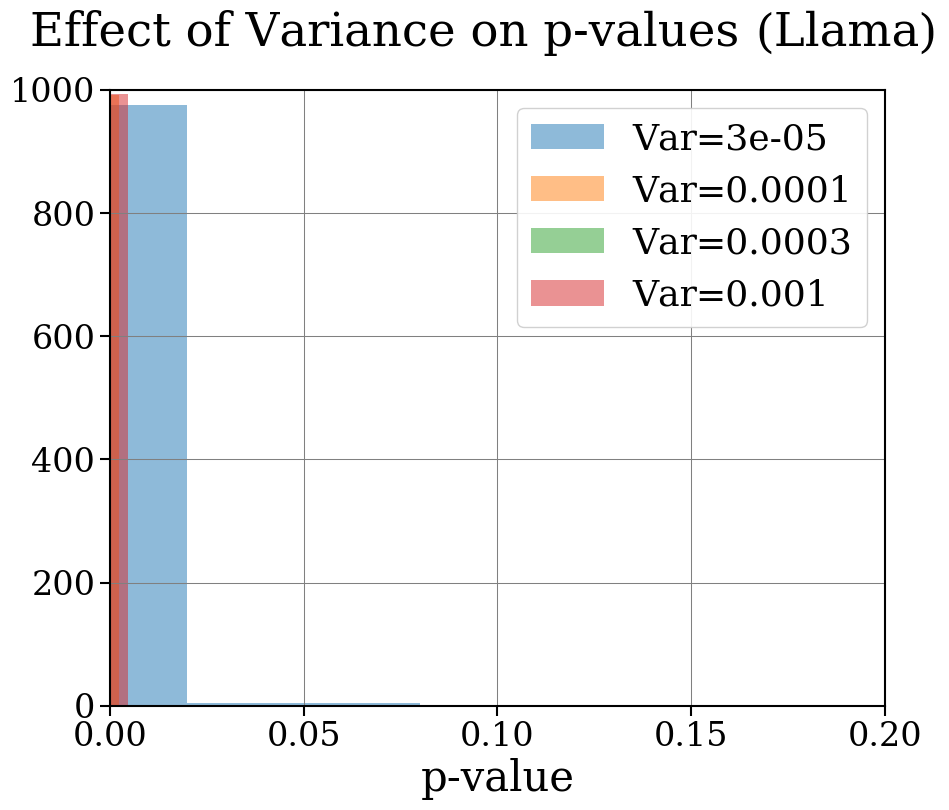

In [63]:
model = 'Llama'
model_name = model_mappings[model]

bins = 50
data = {key: data_dict[model_name][key] for key in sorted(data_dict[model_name].keys(), key=lambda x: x[1])}
fig, ax  = plt.subplots()
for key, datum in data.items():

    var = key[1]

    ax.hist(datum['pvalue'], bins=bins, alpha=0.5, label=f"Var={var}")
    

ax.legend()
ax.set_xlabel('p-value')

ax.set_xlim(0, 0.2)
ax.set_ylim(0, 1000)
fig.suptitle(f"Effect of Variance on p-values ({model})")

if save_figs:
    fig.savefig(os.path.join(figs_parent, 'variance-pvalue-llama.png'))

plt.show()



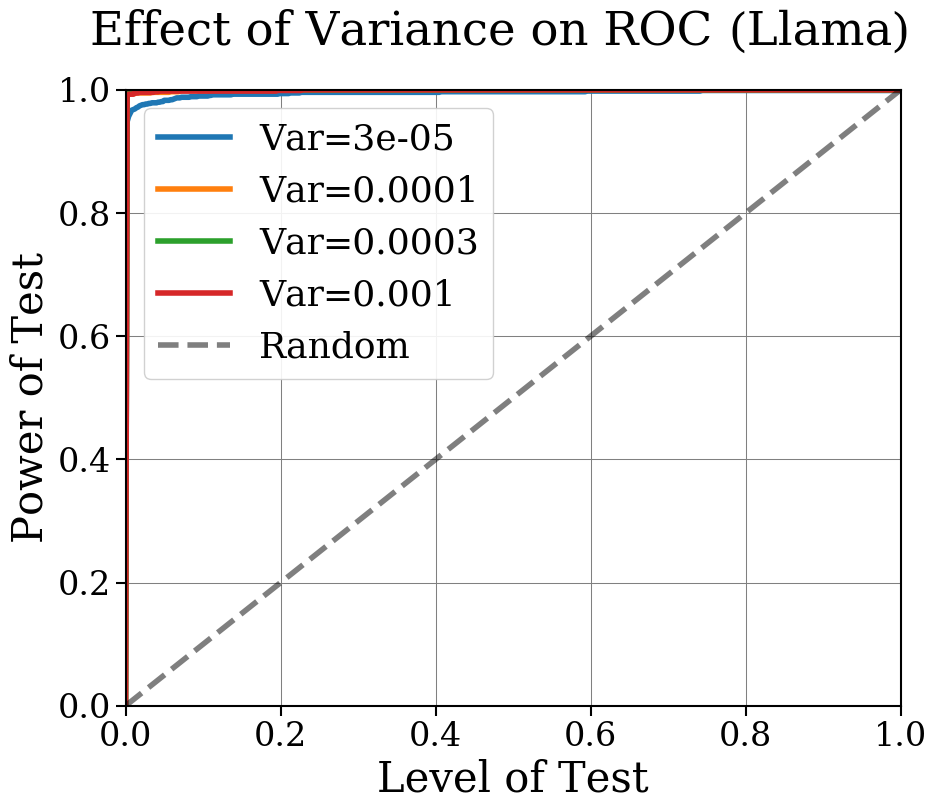

In [64]:
grid_size = 500
data = {key: data_dict[model_name][key] for key in sorted(data_dict[model_name].keys(), key=lambda x: x[1])}
fig, ax  = plt.subplots()
for key, datum in data.items():

    var = key[1]

    grid, cdf = get_empirical_cdf(datum['pvalue'], grid_size=grid_size)
    ax.plot(grid, cdf, label=f"Var={var}")

ax.plot(grid, grid, linestyle='--', alpha = 0.5, color='black', label='Random')

ax.legend()
ax.set_xlabel('Level of Test')
ax.set_ylabel('Power of Test')

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
fig.suptitle(f"Effect of Variance on ROC ({model})")

if save_figs:
    fig.savefig(os.path.join(figs_parent, 'variance-roc-llama.png'))

plt.show()



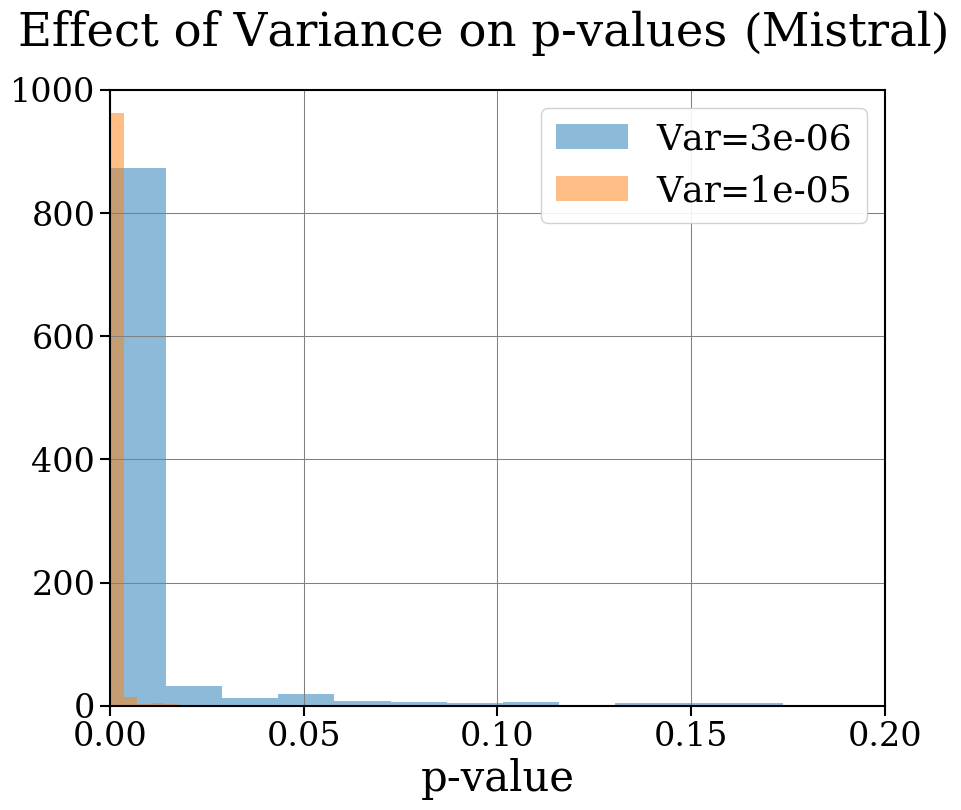

In [65]:
model = 'Mistral'
model_name = model_mappings[model]

bins = 50
data = {key: data_dict[model_name][key] for key in sorted(data_dict[model_name].keys(), key=lambda x: x[1])}
fig, ax  = plt.subplots()
for key, datum in data.items():

    var = key[1]

    ax.hist(datum['pvalue'], bins=bins, alpha=0.5, label=f"Var={var}")
    

ax.legend()
ax.set_xlabel('p-value')

ax.set_xlim(0, 0.2)
ax.set_ylim(0, 1000)
fig.suptitle(f"Effect of Variance on p-values ({model})")

if save_figs:
    fig.savefig(os.path.join(figs_parent, 'variance-pvalue-mistral.png'))

plt.show()



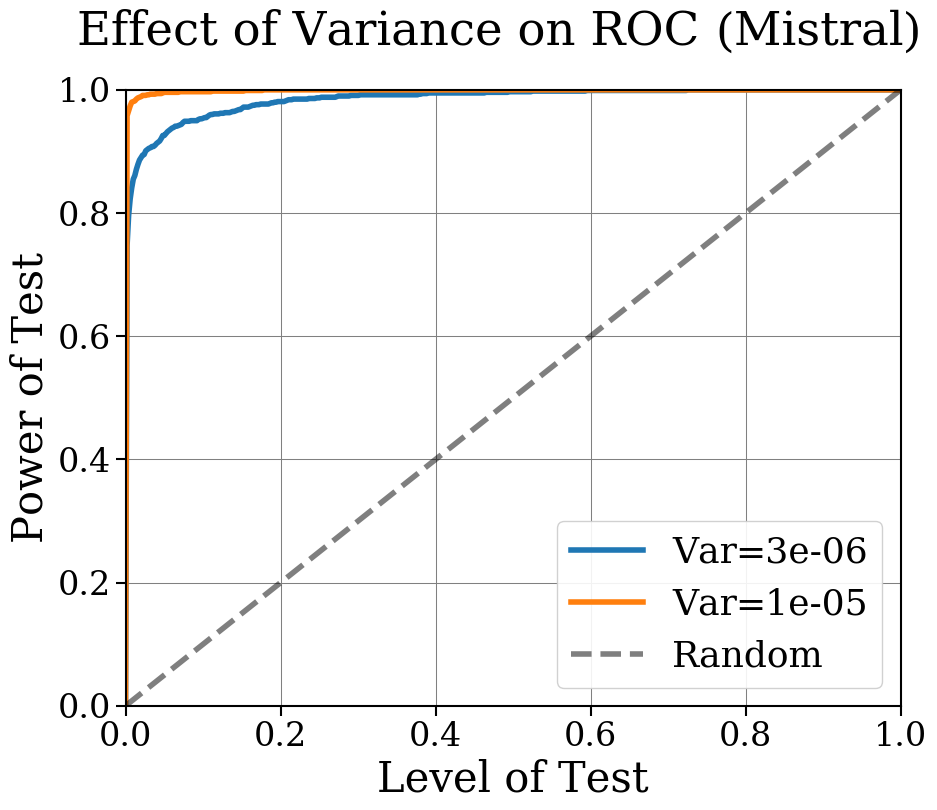

In [66]:
grid_size = 500
data = {key: data_dict[model_name][key] for key in sorted(data_dict[model_name].keys(), key=lambda x: x[1])}
fig, ax  = plt.subplots()
for key, datum in data.items():

    var = key[1]

    grid, cdf = get_empirical_cdf(datum['pvalue'], grid_size=grid_size)
    ax.plot(grid, cdf, label=f"Var={var}")

ax.plot(grid, grid, linestyle='--', alpha = 0.5, color='black', label='Random')

ax.legend()
ax.set_xlabel('Level of Test')
ax.set_ylabel('Power of Test')

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
fig.suptitle(f"Effect of Variance on ROC ({model})")

if save_figs:
    fig.savefig(os.path.join(figs_parent, 'variance-roc-mistral.png'))

plt.show()



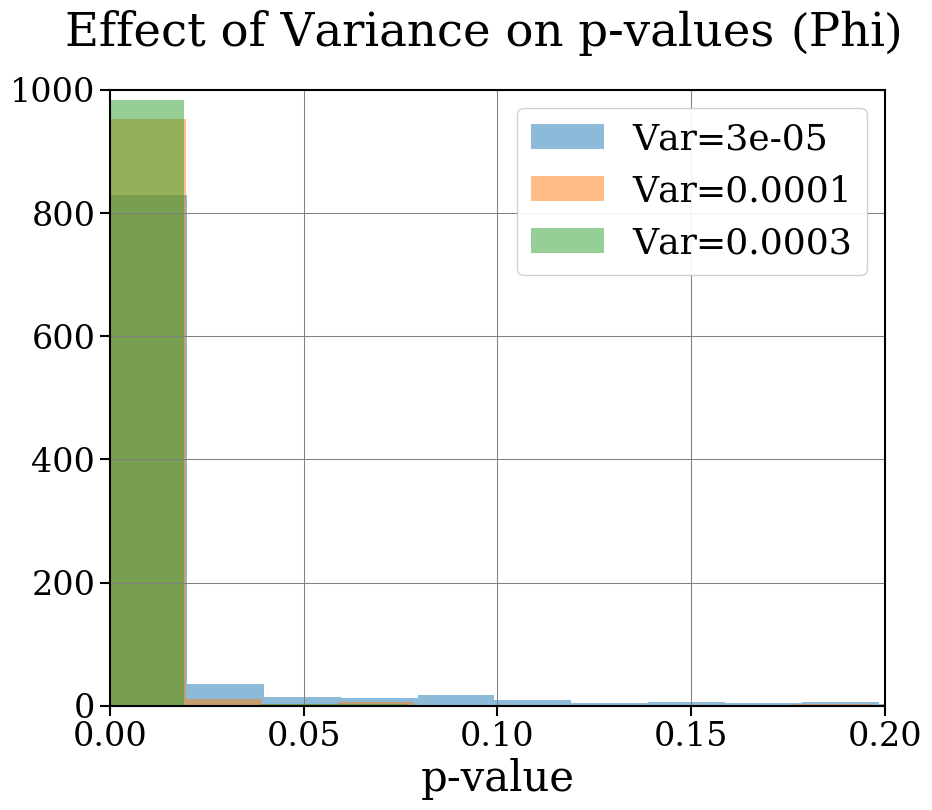

In [67]:
model = 'Phi'
model_name = model_mappings[model]

bins = 50
data = {key: data_dict[model_name][key] for key in sorted(data_dict[model_name].keys(), key=lambda x: x[1])}
fig, ax  = plt.subplots()
for key, datum in data.items():
    var = key[1]

    ax.hist(datum['pvalue'], bins=bins, alpha=0.5, label=f"Var={var}")
    

ax.legend()
ax.set_xlabel('p-value')

ax.set_xlim(0, 0.2)
ax.set_ylim(0, 1000)
fig.suptitle(f"Effect of Variance on p-values ({model})")

if save_figs:
    fig.savefig(os.path.join(figs_parent, 'variance-pvalue-phi.png'))

plt.show()



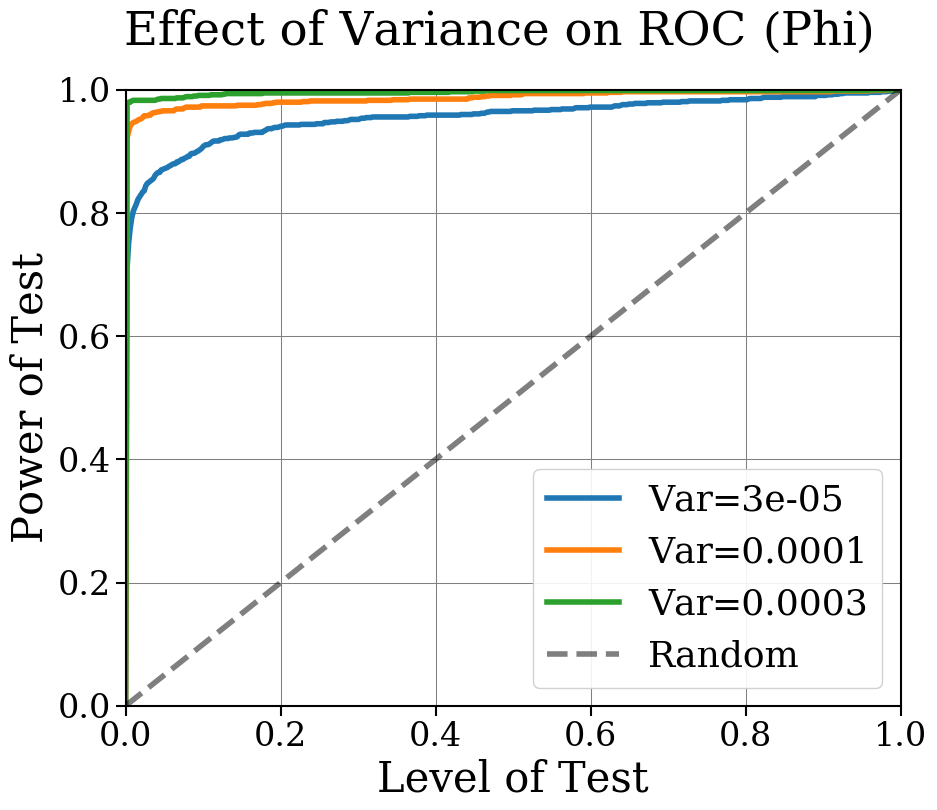

In [68]:
grid_size = 500
data = {key: data_dict[model_name][key] for key in sorted(data_dict[model_name].keys(), key=lambda x: x[1])}
fig, ax  = plt.subplots()
for key, datum in data.items():

    var = key[1]

    grid, cdf = get_empirical_cdf(datum['pvalue'], grid_size=grid_size)
    ax.plot(grid, cdf, label=f"Var={var}")

ax.plot(grid, grid, linestyle='--', alpha = 0.5, color='black', label='Random')

ax.legend()
ax.set_xlabel('Level of Test')
ax.set_ylabel('Power of Test')

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
fig.suptitle(f"Effect of Variance on ROC ({model})")

if save_figs:
    fig.savefig(os.path.join(figs_parent, 'variance-roc-phi.png'))

plt.show()



## Effect of Layer

In [69]:
bins = 30

In [70]:
param_info = {
    # 'layer': 31,
    'mlp_type': 'down_proj',
    'rank': 0,
    'variance': 1e-05
}

data_dict = {}
metrics_dict = {}
for key in generations.keys():
    temp_data = {param: get_all(value, 1e-18) for param, value in generations[key].items() if is_match(param_info, param)}
    temp_metrics = {param: value for param, value in metrics[key].items() if is_match(param_info, param)}

    data_dict[key]  = {param: temp_data[param] for param in sorted(temp_data.keys(), key=lambda x: x[1])}
    metrics_dict[key] = {param: temp_metrics[param] for param in sorted(temp_metrics.keys(), key=lambda x: x[1])}

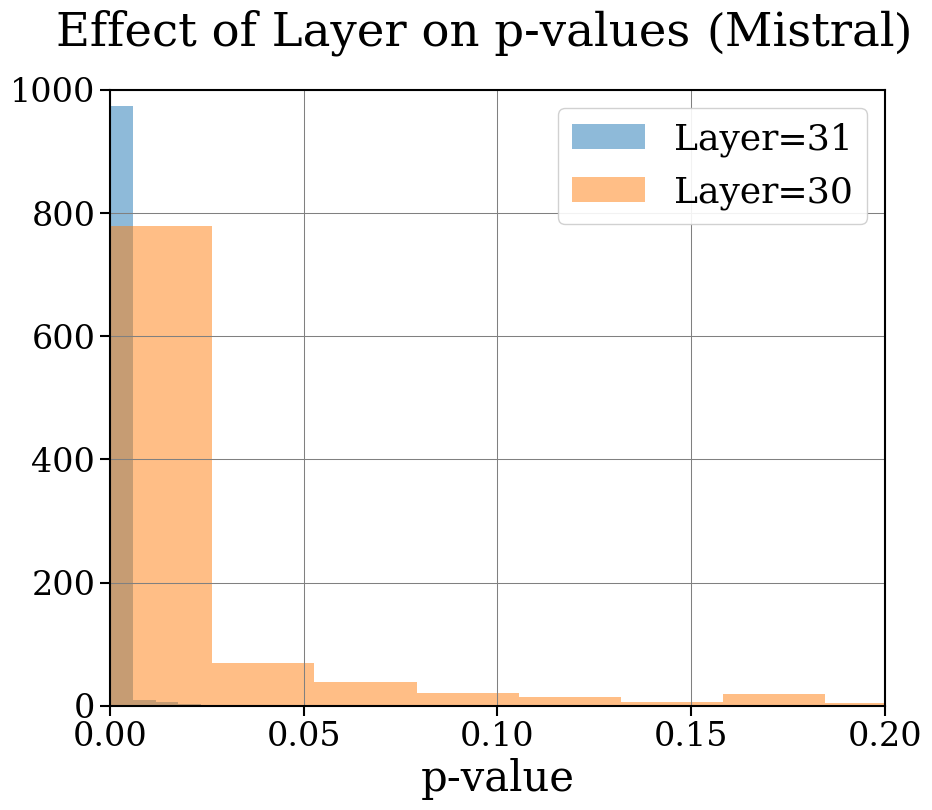

In [71]:
model = 'Mistral'
model_name = model_mappings[model]


data = {key: data_dict[model_name][key] for key in sorted(data_dict[model_name].keys(), key=lambda x: x[1])}
fig, ax  = plt.subplots()
for key, datum in data.items():

    layer = int(key[0].split('.')[2])

    ax.hist(datum['pvalue'], bins=bins, alpha=0.5, label=f"Layer={layer}")
    

ax.legend()
ax.set_xlabel('p-value')

ax.set_xlim(0, 0.2)
ax.set_ylim(0, 1000)
fig.suptitle(f"Effect of Layer on p-values ({model})")

if save_figs:
    fig.savefig(os.path.join(figs_parent, 'layer-pvalue-mistral.png'))

plt.show()



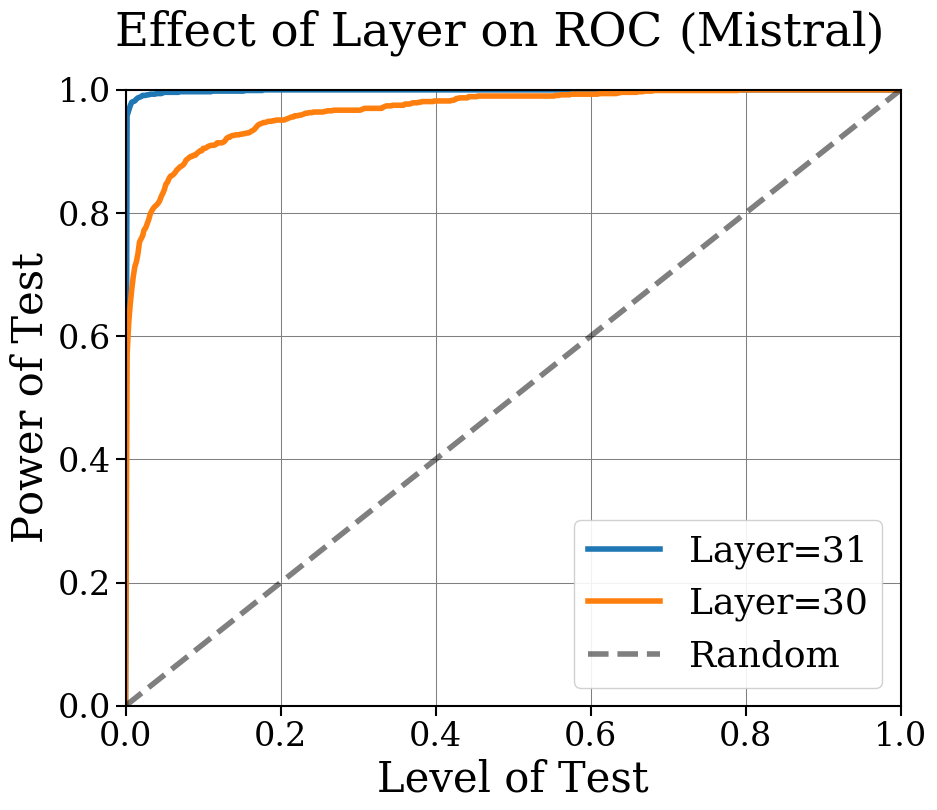

In [72]:
grid_size = 500
data = {key: data_dict[model_name][key] for key in sorted(data_dict[model_name].keys(), key=lambda x: x[1])}
fig, ax  = plt.subplots()
for key, datum in data.items():

    layer = int(key[0].split('.')[2])

    grid, cdf = get_empirical_cdf(datum['pvalue'], grid_size=grid_size)
    ax.plot(grid, cdf, label=f"Layer={layer}")

ax.plot(grid, grid, linestyle='--', alpha = 0.5, color='black', label='Random')

ax.legend()
ax.set_xlabel('Level of Test')
ax.set_ylabel('Power of Test')

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
fig.suptitle(f"Effect of Layer on ROC ({model})")

if save_figs:
    fig.savefig(os.path.join(figs_parent, 'layer-roc-mistral.png'))

plt.show()



In [73]:
param_info = {
    # 'layer': 31,
    'mlp_type': 'down_proj',
    'rank': 0,
    'variance': 3e-05
}

data_dict = {}
metrics_dict = {}
for key in generations.keys():
    temp_data = {param: get_all(value, 1e-18) for param, value in generations[key].items() if is_match(param_info, param)}
    temp_metrics = {param: value for param, value in metrics[key].items() if is_match(param_info, param)}

    data_dict[key]  = {param: temp_data[param] for param in sorted(temp_data.keys(), key=lambda x: x[1])}
    metrics_dict[key] = {param: temp_metrics[param] for param in sorted(temp_metrics.keys(), key=lambda x: x[1])}

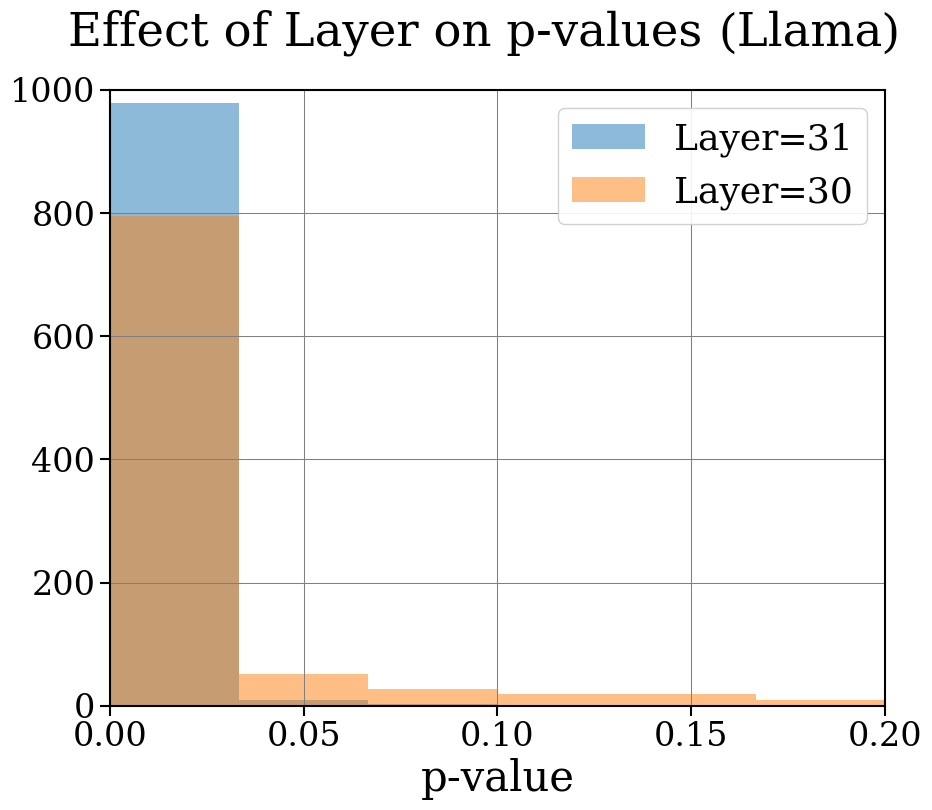

In [74]:
model = 'Llama'
model_name = model_mappings[model]


data = {key: data_dict[model_name][key] for key in sorted(data_dict[model_name].keys(), key=lambda x: x[1])}
fig, ax  = plt.subplots()
for key, datum in data.items():

    layer = int(key[0].split('.')[2])

    ax.hist(datum['pvalue'], bins=bins, alpha=0.5, label=f"Layer={layer}")
    

ax.legend()
ax.set_xlabel('p-value')

ax.set_xlim(0, 0.2)
ax.set_ylim(0, 1000)
fig.suptitle(f"Effect of Layer on p-values ({model})")

if save_figs:
    fig.savefig(os.path.join(figs_parent, 'layer-pvalue-llama.png'))

plt.show()



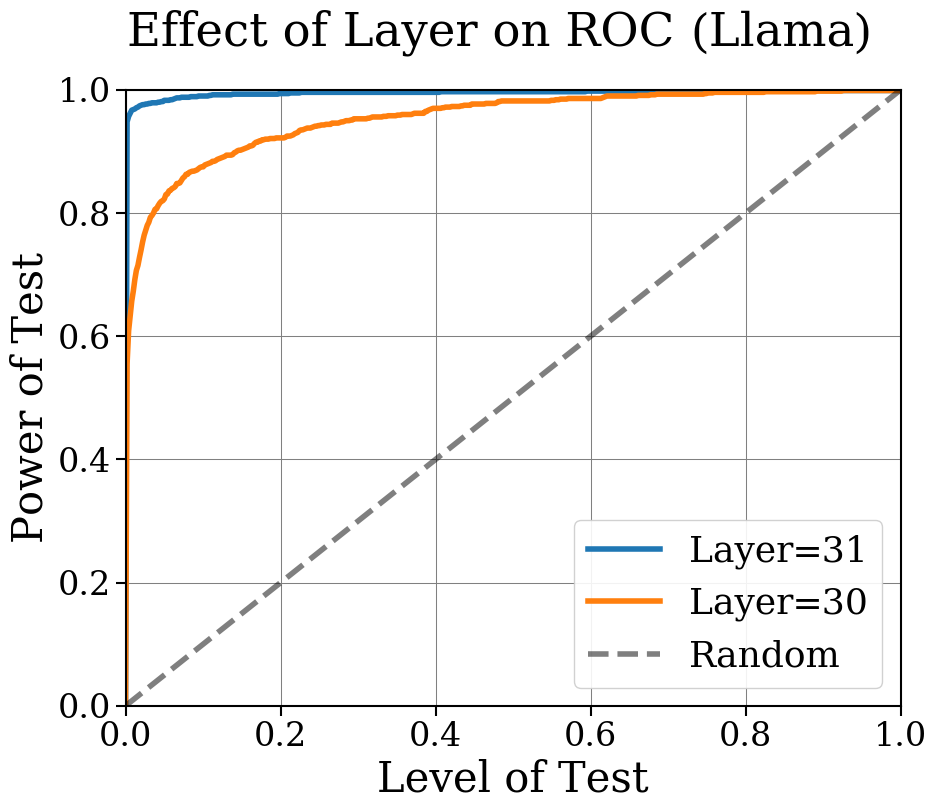

In [75]:
grid_size = 500
data = {key: data_dict[model_name][key] for key in sorted(data_dict[model_name].keys(), key=lambda x: x[1])}
fig, ax  = plt.subplots()
for key, datum in data.items():

    layer = int(key[0].split('.')[2])

    grid, cdf = get_empirical_cdf(datum['pvalue'], grid_size=grid_size)
    ax.plot(grid, cdf, label=f"Layer={layer}")

ax.plot(grid, grid, linestyle='--', alpha = 0.5, color='black', label='Random')
ax.legend()
ax.set_xlabel('Level of Test')
ax.set_ylabel('Power of Test')

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
fig.suptitle(f"Effect of Layer on ROC ({model})")

if save_figs:
    fig.savefig(os.path.join(figs_parent, 'layer-roc-llama.png'))

plt.show()



In [76]:
param_info = {
    # 'layer': 31,
    'mlp_type': 'down_proj',
    'rank': 0,
    'variance': 1e-04
}

data_dict = {}
metrics_dict = {}
for key in generations.keys():
    temp_data = {param: get_all(value, 1e-18) for param, value in generations[key].items() if is_match(param_info, param)}
    temp_metrics = {param: value for param, value in metrics[key].items() if is_match(param_info, param)}

    data_dict[key]  = {param: temp_data[param] for param in sorted(temp_data.keys(), key=lambda x: x[1])}
    metrics_dict[key] = {param: temp_metrics[param] for param in sorted(temp_metrics.keys(), key=lambda x: x[1])}

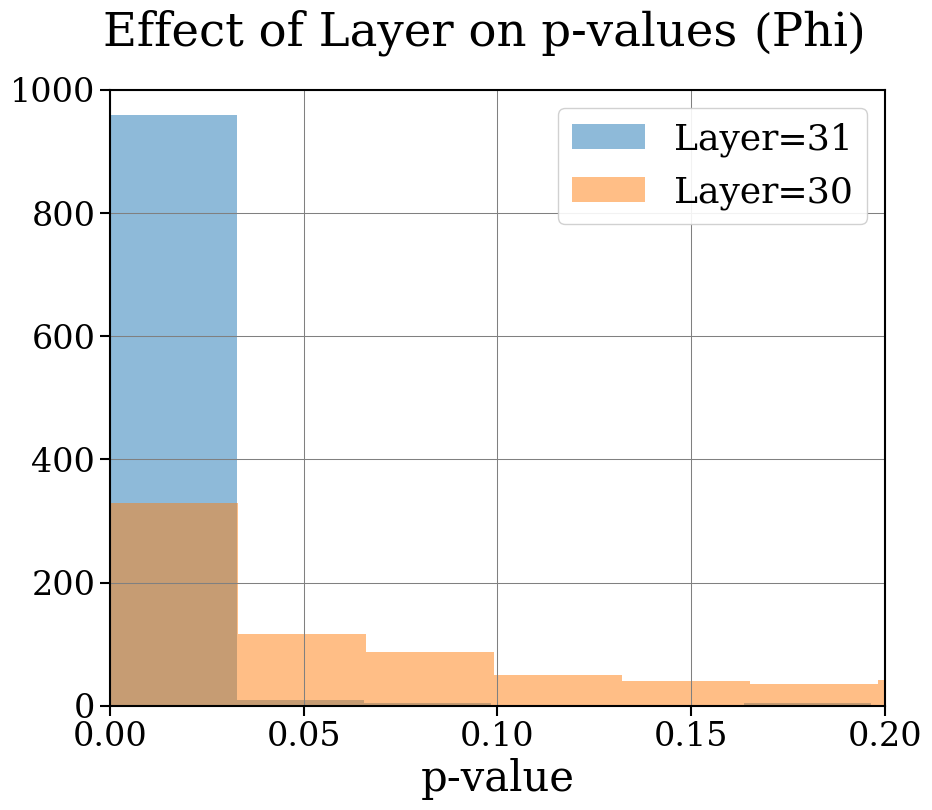

In [77]:
model = 'Phi'
model_name = model_mappings[model]


data = {key: data_dict[model_name][key] for key in sorted(data_dict[model_name].keys(), key=lambda x: x[1])}
fig, ax  = plt.subplots()
for key, datum in data.items():

    layer = int(key[0].split('.')[2])

    ax.hist(datum['pvalue'], bins=bins, alpha=0.5, label=f"Layer={layer}")
    

ax.legend()
ax.set_xlabel('p-value')

ax.set_xlim(0, 0.2)
ax.set_ylim(0, 1000)
fig.suptitle(f"Effect of Layer on p-values ({model})")

if save_figs:
    fig.savefig(os.path.join(figs_parent, 'layer-pvalue-phi.png'))

plt.show()



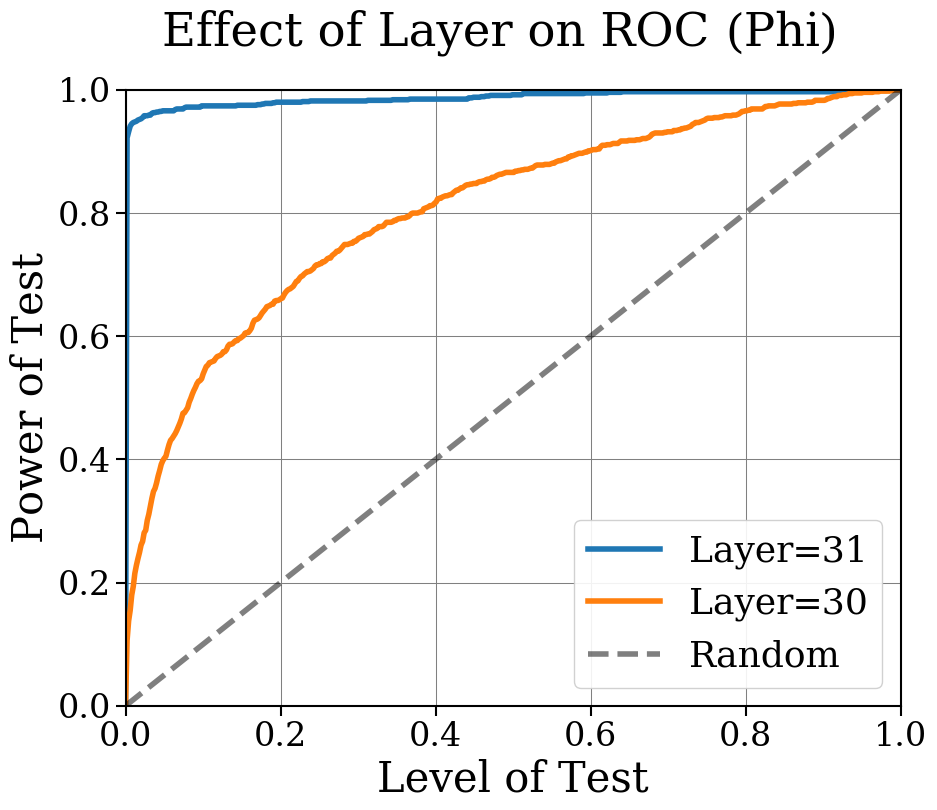

In [78]:
grid_size = 500
data = {key: data_dict[model_name][key] for key in sorted(data_dict[model_name].keys(), key=lambda x: x[1])}
fig, ax  = plt.subplots()
for key, datum in data.items():

    layer = int(key[0].split('.')[2])

    grid, cdf = get_empirical_cdf(datum['pvalue'], grid_size=grid_size)
    ax.plot(grid, cdf, label=f"Layer={layer}")

ax.plot(grid, grid, linestyle='--', alpha = 0.5, color='black', label='Random')
ax.legend()
ax.set_xlabel('Level of Test')
ax.set_ylabel('Power of Test')

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
fig.suptitle(f"Effect of Layer on ROC ({model})")

if save_figs:
    fig.savefig(os.path.join(figs_parent, 'layer-roc-phi.png'))

plt.show()



## Effect of MLP type

In [79]:
param_info = {
    'layer': 31,
    # 'mlp_type': 'down_proj',
    'rank': 0,
    'variance': 1e-04
}

data_dict = {}
metrics_dict = {}
for key in generations.keys():
    temp_data = {param: get_all(value, 1e-18) for param, value in generations[key].items() if is_match(param_info, param)}
    temp_metrics = {param: value for param, value in metrics[key].items() if is_match(param_info, param)}

    data_dict[key]  = {param: temp_data[param] for param in sorted(temp_data.keys(), key=lambda x: x[1])}
    metrics_dict[key] = {param: temp_metrics[param] for param in sorted(temp_metrics.keys(), key=lambda x: x[1])}

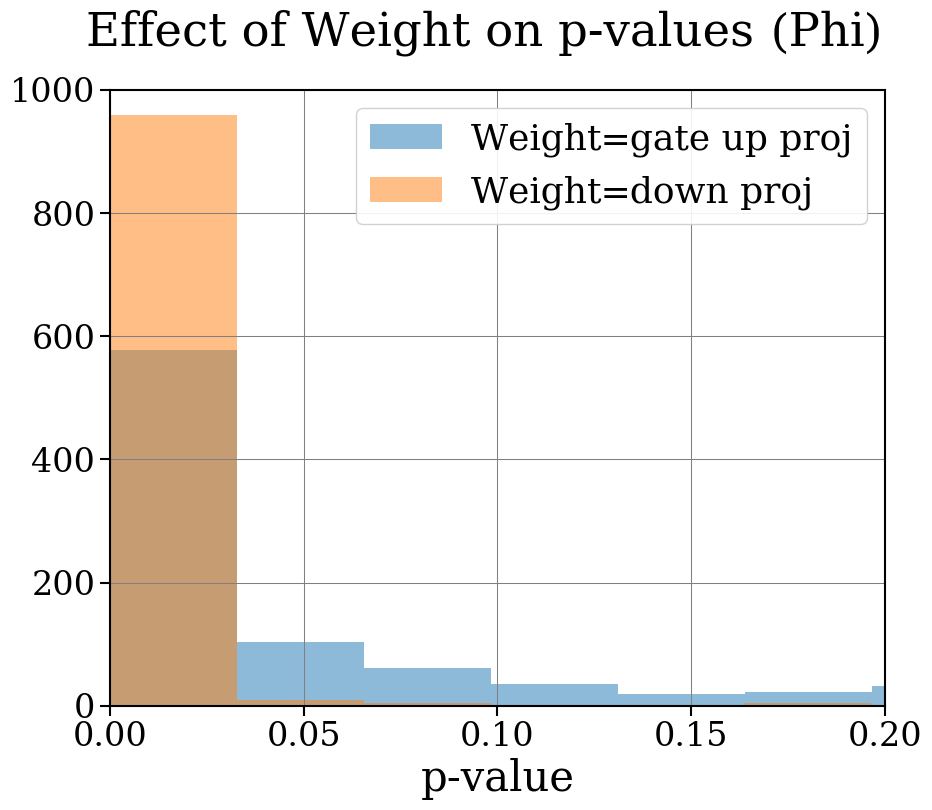

In [80]:
model = 'Phi'
model_name = model_mappings[model]


data = {key: data_dict[model_name][key] for key in sorted(data_dict[model_name].keys(), key=lambda x: x[1])}
fig, ax  = plt.subplots()
for key, datum in data.items():

    weight = key[0].split('.')[4]
    weight = weight.replace('_', ' ')
    ax.hist(datum['pvalue'], bins=bins, alpha=0.5, label=f"Weight={weight}")
    

ax.legend()
ax.set_xlabel('p-value')

ax.set_xlim(0, 0.2)
ax.set_ylim(0, 1000)
fig.suptitle(f"Effect of Weight on p-values ({model})")

if save_figs:
    fig.savefig(os.path.join(figs_parent, 'weight-pvalue-phi.png'))

plt.show()



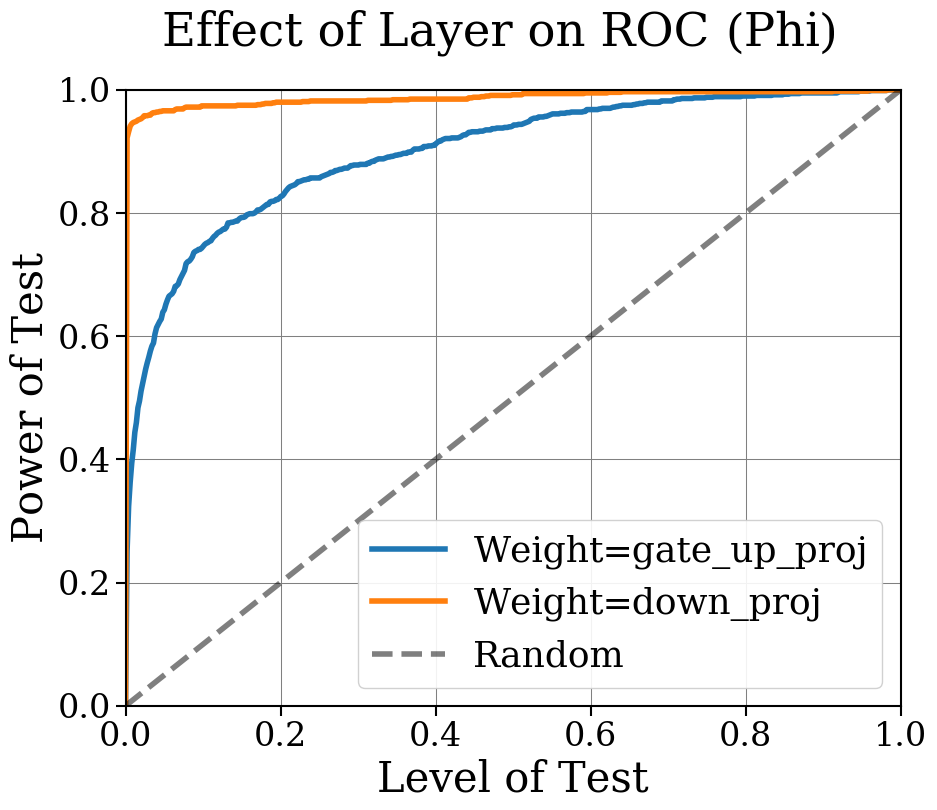

In [81]:
grid_size = 500
data = {key: data_dict[model_name][key] for key in sorted(data_dict[model_name].keys(), key=lambda x: x[1])}
fig, ax  = plt.subplots()
for key, datum in data.items():

    weight = key[0].split('.')[4]

    grid, cdf = get_empirical_cdf(datum['pvalue'], grid_size=grid_size)
    ax.plot(grid, cdf, label=f"Weight={weight}")

ax.plot(grid, grid, linestyle='--', alpha = 0.5, color='black', label='Random')
ax.legend()
ax.set_xlabel('Level of Test')
ax.set_ylabel('Power of Test')

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
fig.suptitle(f"Effect of Layer on ROC ({model})")

if save_figs:
    fig.savefig(os.path.join(figs_parent, 'weight-roc-phi.png'))

plt.show()



In [82]:
param_info = {
    'layer': 31,
    # 'mlp_type': 'down_proj',
    'rank': 0,
    'variance': 3e-5
}

data_dict = {}
metrics_dict = {}
for key in generations.keys():
    temp_data = {param: get_all(value, 1e-18) for param, value in generations[key].items() if is_match(param_info, param)}
    temp_metrics = {param: value for param, value in metrics[key].items() if is_match(param_info, param)}

    data_dict[key]  = {param: temp_data[param] for param in sorted(temp_data.keys(), key=lambda x: x[1])}
    metrics_dict[key] = {param: temp_metrics[param] for param in sorted(temp_metrics.keys(), key=lambda x: x[1])}

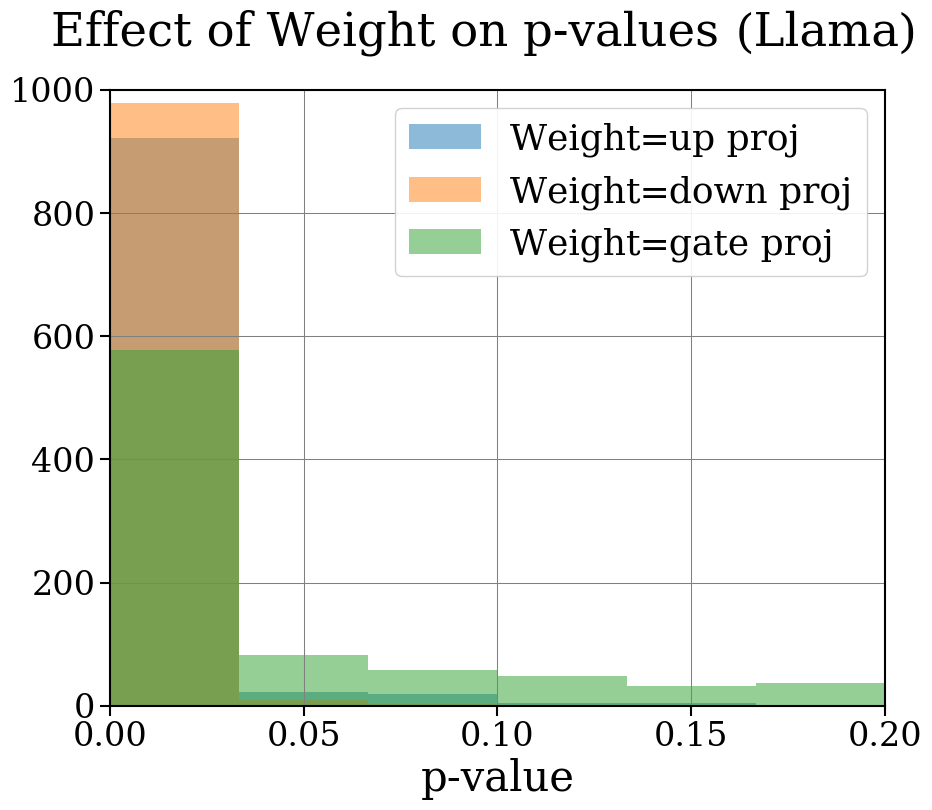

In [83]:
model = 'Llama'
model_name = model_mappings[model]


data = {key: data_dict[model_name][key] for key in sorted(data_dict[model_name].keys(), key=lambda x: x[1])}
fig, ax  = plt.subplots()
for key, datum in data.items():

    weight = key[0].split('.')[4]
    weight = weight.replace('_', ' ')
    ax.hist(datum['pvalue'], bins=bins, alpha=0.5, label=f"Weight={weight}")
    

ax.legend()
ax.set_xlabel('p-value')

ax.set_xlim(0, 0.2)
ax.set_ylim(0, 1000)
fig.suptitle(f"Effect of Weight on p-values ({model})")

if save_figs:
    fig.savefig(os.path.join(figs_parent, 'weight-pvalue-llama.png'))

plt.show()



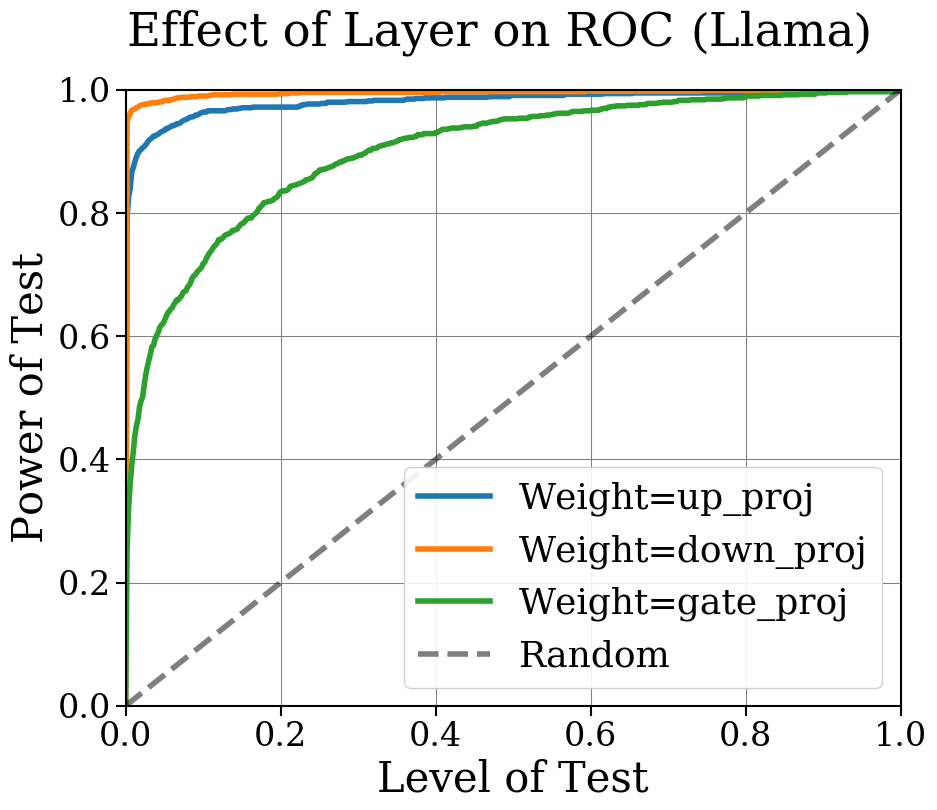

In [84]:
grid_size = 500
data = {key: data_dict[model_name][key] for key in sorted(data_dict[model_name].keys(), key=lambda x: x[1])}
fig, ax  = plt.subplots()
for key, datum in data.items():

    weight = key[0].split('.')[4]

    grid, cdf = get_empirical_cdf(datum['pvalue'], grid_size=grid_size)
    ax.plot(grid, cdf, label=f"Weight={weight}")

ax.plot(grid, grid, linestyle='--', alpha = 0.5, color='black', label='Random')
ax.legend()
ax.set_xlabel('Level of Test')
ax.set_ylabel('Power of Test')

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
fig.suptitle(f"Effect of Layer on ROC ({model})")

if save_figs:
    fig.savefig(os.path.join(figs_parent, 'weight-roc-llama.png'))

plt.show()



In [85]:
param_info = {
    'layer': 31,
    # 'mlp_type': 'down_proj',
    'rank': 0,
    'variance': 1e-5
}

data_dict = {}
metrics_dict = {}
for key in generations.keys():
    temp_data = {param: get_all(value, 1e-18) for param, value in generations[key].items() if is_match(param_info, param)}
    temp_metrics = {param: value for param, value in metrics[key].items() if is_match(param_info, param)}

    data_dict[key]  = {param: temp_data[param] for param in sorted(temp_data.keys(), key=lambda x: x[1])}
    metrics_dict[key] = {param: temp_metrics[param] for param in sorted(temp_metrics.keys(), key=lambda x: x[1])}

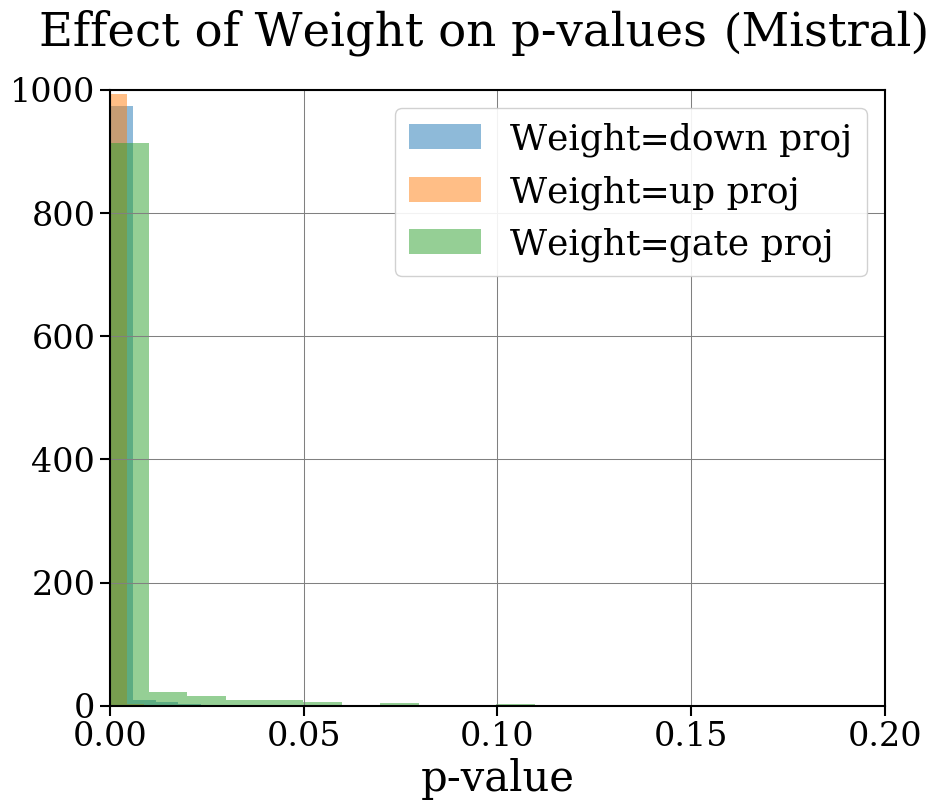

In [86]:
model = 'Mistral'
model_name = model_mappings[model]




data = {key: data_dict[model_name][key] for key in sorted(data_dict[model_name].keys(), key=lambda x: x[1])}
fig, ax  = plt.subplots()



for key, datum in data.items():

    weight = key[0].split('.')[4]
    weight = weight.replace('_', ' ')
    ax.hist(datum['pvalue'], bins=bins, alpha=0.5, label=f"Weight={weight}")

    
    

ax.legend()
ax.set_xlabel('p-value')

ax.set_xlim(0, 0.2)
ax.set_ylim(0, 1000)
fig.suptitle(f"Effect of Weight on p-values ({model})")

if save_figs:
    fig.savefig(os.path.join(figs_parent, 'weight-pvalue-mistral.png'))

plt.show()



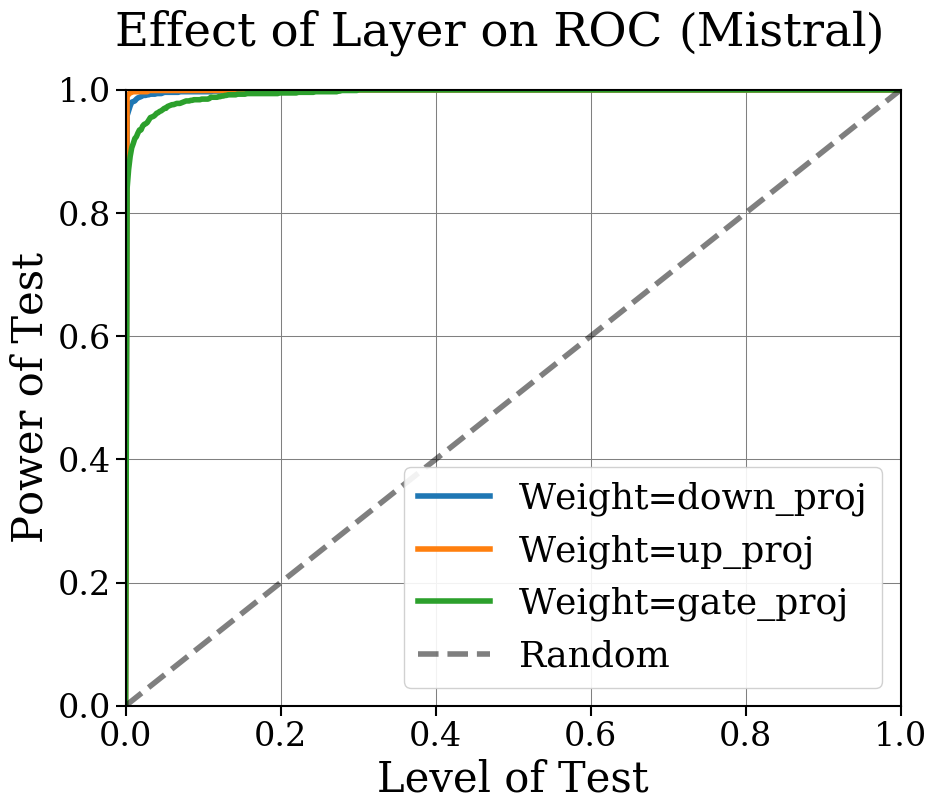

In [87]:
grid_size = 500
data = {key: data_dict[model_name][key] for key in sorted(data_dict[model_name].keys(), key=lambda x: x[1])}
fig, ax  = plt.subplots()
for key, datum in data.items():

    weight = key[0].split('.')[4]

    grid, cdf = get_empirical_cdf(datum['pvalue'], grid_size=grid_size)
    ax.plot(grid, cdf, label=f"Weight={weight}")

ax.plot(grid, grid, linestyle='--', alpha = 0.5, color='black', label='Random')
ax.legend()
ax.set_xlabel('Level of Test')
ax.set_ylabel('Power of Test')

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
fig.suptitle(f"Effect of Layer on ROC ({model})")

if save_figs:
    fig.savefig(os.path.join(figs_parent, 'weight-roc-mistral.png'))

plt.show()



# Getting All Metrics

In [88]:
model = 'Mistral'

threshold = 0.0
unwatermarked_metric = unwatermarked_metrics[model_name]

unwatermarked_score = np.mean(get_superglue_results(unwatermarked_metric)[1])
unwatermarked_stderr = np.mean(get_superglue_results(unwatermarked_metric)[2])

unwatermarked_gsm8k_score = get_superglue_results(unwatermarked_metric)[3][0]
unwatermarked_gsm8k_stderr = get_superglue_results(unwatermarked_metric)[3][1]

output_string = ''
output_string += f"{model}   \n"
output_string += '#'*50 + '  \n'
output_string += f"Superglue Score: {unwatermarked_score:.4f} +/- {unwatermarked_stderr:.4f}   \n"
# print(f"{model}")
# print('#'*50 + '\n')
# print(f"Superglue Score: {unwatermarked_score:.4f} +/- {unwatermarked_stderr:.4f}")
for key, metric in metrics[model_mappings[model]].items():

    if key[-1] > 0:
        continue

    layer = int(key[0].split('.')[2])
    weight = key[0].split('.')[4]
    variance = key[1]

    score = np.mean(get_superglue_results(metric)[1])
    stderr = np.mean(get_superglue_results(metric)[2])

    if score + stderr > unwatermarked_score - unwatermarked_stderr - threshold:
        output_string += f"**Layer: {layer}, Weight: {weight}, Variance: {variance}: {score:.4f} +/- {stderr:.4f}**  \n"
    else:
        output_string += f"Layer: {layer}, Weight: {weight}, Variance: {variance}: {score:.4f} +/- {stderr:.4f}  \n"
    # print(f"Layer: {layer}, Weight: {weight}, Variance: {variance}: {score:.4f} +/- {stderr:.4f}")




output_string += '   \n'
unwatermarked_gsm8k_score = get_superglue_results(unwatermarked_metric)[3][0]
unwatermarked_gsm8k_stderr = get_superglue_results(unwatermarked_metric)[3][1]

output_string += f"GSM8K Score: {unwatermarked_gsm8k_score:.4f} +/- {unwatermarked_gsm8k_stderr:.4f}  \n"
for key, metric in metrics[model_mappings[model]].items():

    if key[-1] > 0:
        continue
    layer = int(key[0].split('.')[2])
    weight = key[0].split('.')[4]
    variance = key[1]

    gsm8k_score, gsm8k_stderr = get_superglue_results(metric)[3]

    if gsm8k_score + gsm8k_stderr > unwatermarked_gsm8k_score - unwatermarked_gsm8k_stderr - threshold:
        output_string += f"**Layer: {layer}, Weight: {weight}, Variance: {variance}: {gsm8k_score:.4f} +/- {gsm8k_stderr:.4f}**  \n"
    else:
        output_string += f"Layer: {layer}, Weight: {weight}, Variance: {variance}: {gsm8k_score:.4f} +/- {gsm8k_stderr:.4f}  \n"






print(output_string)


Mistral   
##################################################  
Superglue Score: 0.6836 +/- 0.0260   
**Layer: 31, Weight: down_proj, Variance: 1e-05: 0.6493 +/- 0.0261**  
**Layer: 30, Weight: down_proj, Variance: 1e-05: 0.6759 +/- 0.0264**  
**Layer: 30, Weight: down_proj, Variance: 3e-06: 0.6704 +/- 0.0261**  
**Layer: 30, Weight: up_proj, Variance: 3e-06: 0.6776 +/- 0.0260**  
**Layer: 31, Weight: gate_proj, Variance: 3e-06: 0.6888 +/- 0.0259**  
**Layer: 30, Weight: gate_proj, Variance: 1e-05: 0.6838 +/- 0.0260**  
**Layer: 31, Weight: down_proj, Variance: 3e-06: 0.6604 +/- 0.0261**  
**Layer: 31, Weight: up_proj, Variance: 1e-05: 0.6731 +/- 0.0261**  
**Layer: 30, Weight: up_proj, Variance: 1e-05: 0.6739 +/- 0.0263**  
**Layer: 31, Weight: up_proj, Variance: 3e-06: 0.6764 +/- 0.0260**  
**Layer: 30, Weight: gate_proj, Variance: 3e-06: 0.6842 +/- 0.0258**  
**Layer: 31, Weight: gate_proj, Variance: 1e-05: 0.7017 +/- 0.0256**  
   
GSM8K Score: 0.4291 +/- 0.0136  
Layer: 31, Weight

Mistral   
##################################################  
Superglue Score: 0.6836 +/- 0.0260   
**Layer: 31, Weight: down_proj, Variance: 1e-05: 0.6493 +/- 0.0261**  
**Layer: 30, Weight: down_proj, Variance: 1e-05: 0.6759 +/- 0.0264**  
**Layer: 30, Weight: down_proj, Variance: 3e-06: 0.6704 +/- 0.0261**  
**Layer: 30, Weight: up_proj, Variance: 3e-06: 0.6776 +/- 0.0260**  
**Layer: 31, Weight: gate_proj, Variance: 3e-06: 0.6888 +/- 0.0259**  
**Layer: 30, Weight: gate_proj, Variance: 1e-05: 0.6838 +/- 0.0260**  
**Layer: 31, Weight: down_proj, Variance: 3e-06: 0.6604 +/- 0.0261**  
**Layer: 31, Weight: up_proj, Variance: 1e-05: 0.6731 +/- 0.0261**  
**Layer: 30, Weight: up_proj, Variance: 1e-05: 0.6739 +/- 0.0263**  
**Layer: 31, Weight: up_proj, Variance: 3e-06: 0.6764 +/- 0.0260**  
**Layer: 30, Weight: gate_proj, Variance: 3e-06: 0.6842 +/- 0.0258**  
**Layer: 31, Weight: gate_proj, Variance: 1e-05: 0.7017 +/- 0.0256**  
   
GSM8K Score: 0.4291 +/- 0.0136  
Layer: 31, Weight: down_proj, Variance: 1e-05: 0.3730 +/- 0.0133  
**Layer: 30, Weight: down_proj, Variance: 1e-05: 0.4367 +/- 0.0137**  
**Layer: 30, Weight: down_proj, Variance: 3e-06: 0.4359 +/- 0.0137**  
**Layer: 30, Weight: up_proj, Variance: 3e-06: 0.4344 +/- 0.0137**  
**Layer: 31, Weight: gate_proj, Variance: 3e-06: 0.4352 +/- 0.0137**  
**Layer: 30, Weight: gate_proj, Variance: 1e-05: 0.4223 +/- 0.0136**  
**Layer: 31, Weight: down_proj, Variance: 3e-06: 0.4064 +/- 0.0135**  
Layer: 31, Weight: up_proj, Variance: 1e-05: 0.3851 +/- 0.0134  
**Layer: 30, Weight: up_proj, Variance: 1e-05: 0.4443 +/- 0.0137**  
**Layer: 31, Weight: up_proj, Variance: 3e-06: 0.4026 +/- 0.0135**  
**Layer: 30, Weight: gate_proj, Variance: 3e-06: 0.4329 +/- 0.0136**  
**Layer: 31, Weight: gate_proj, Variance: 1e-05: 0.4284 +/- 0.0136**  

In [89]:
model = 'Llama'

threshold = 0.0
unwatermarked_metric = unwatermarked_metrics[model_name]

unwatermarked_score = np.mean(get_superglue_results(unwatermarked_metric)[1])
unwatermarked_stderr = np.mean(get_superglue_results(unwatermarked_metric)[2])

unwatermarked_gsm8k_score = get_superglue_results(unwatermarked_metric)[3][0]
unwatermarked_gsm8k_stderr = get_superglue_results(unwatermarked_metric)[3][1]

output_string = ''
output_string += f"{model}   \n"
output_string += '#'*50 + '  \n'
output_string += f"Superglue Score: {unwatermarked_score:.4f} +/- {unwatermarked_stderr:.4f}   \n"
# print(f"{model}")
# print('#'*50 + '\n')
# print(f"Superglue Score: {unwatermarked_score:.4f} +/- {unwatermarked_stderr:.4f}")
for key, metric in metrics[model_mappings[model]].items():

    if key[-1] > 0:
        continue

    layer = int(key[0].split('.')[2])
    weight = key[0].split('.')[4]
    variance = key[1]

    score = np.mean(get_superglue_results(metric)[1])
    stderr = np.mean(get_superglue_results(metric)[2])

    if score + stderr > unwatermarked_score - unwatermarked_stderr - threshold:
        output_string += f"**Layer: {layer}, Weight: {weight}, Variance: {variance}: {score:.4f} +/- {stderr:.4f}**  \n"
    else:
        output_string += f"Layer: {layer}, Weight: {weight}, Variance: {variance}: {score:.4f} +/- {stderr:.4f}  \n"
    # print(f"Layer: {layer}, Weight: {weight}, Variance: {variance}: {score:.4f} +/- {stderr:.4f}")




output_string += '   \n'
unwatermarked_gsm8k_score = get_superglue_results(unwatermarked_metric)[3][0]
unwatermarked_gsm8k_stderr = get_superglue_results(unwatermarked_metric)[3][1]

# output_string += f"GSM8K Score: {unwatermarked_gsm8k_score:.4f} +/- {unwatermarked_gsm8k_stderr:.4f}  \n"
# for key, metric in metrics[model_mappings[model]].items():

#     if key[-1] > 0:
#         continue
#     layer = int(key[0].split('.')[2])
#     weight = key[0].split('.')[4]
#     variance = key[1]

#     gsm8k_score, gsm8k_stderr = get_superglue_results(metric)[3]

#     if gsm8k_score + gsm8k_stderr > unwatermarked_gsm8k_score - unwatermarked_gsm8k_stderr - threshold:
#         output_string += f"**Layer: {layer}, Weight: {weight}, Variance: {variance}: {gsm8k_score:.4f} +/- {gsm8k_stderr:.4f}**  \n"
#     else:
#         output_string += f"Layer: {layer}, Weight: {weight}, Variance: {variance}: {gsm8k_score:.4f} +/- {gsm8k_stderr:.4f}  \n"






print(output_string)


Llama   
##################################################  
Superglue Score: 0.6836 +/- 0.0260   
**Layer: 30, Weight: up_proj, Variance: 3e-05: 0.7118 +/- 0.0256**  
**Layer: 31, Weight: up_proj, Variance: 0.0001: 0.7033 +/- 0.0269**  
**Layer: 31, Weight: up_proj, Variance: 3e-05: 0.7216 +/- 0.0261**  
**Layer: 31, Weight: down_proj, Variance: 3e-05: 0.6751 +/- 0.0266**  
**Layer: 30, Weight: gate_proj, Variance: 0.001: 0.6797 +/- 0.0271**  
**Layer: 31, Weight: gate_proj, Variance: 0.001: 0.7028 +/- 0.0249**  
**Layer: 30, Weight: up_proj, Variance: 0.001: 0.6410 +/- 0.0276**  
**Layer: 31, Weight: down_proj, Variance: 0.0001: 0.6614 +/- 0.0269**  
Layer: 31, Weight: down_proj, Variance: 0.0003: 0.6208 +/- 0.0277  
**Layer: 31, Weight: up_proj, Variance: 0.0003: 0.6627 +/- 0.0274**  
**Layer: 30, Weight: down_proj, Variance: 0.0003: 0.7003 +/- 0.0265**  
Layer: 31, Weight: up_proj, Variance: 0.001: 0.6153 +/- 0.0281  
**Layer: 31, Weight: gate_proj, Variance: 0.0003: 0.7016 +/- 0.

Llama   
##################################################  
Superglue Score: 0.6836 +/- 0.0260   
**Layer: 30, Weight: up_proj, Variance: 3e-05: 0.7118 +/- 0.0256**  
**Layer: 31, Weight: up_proj, Variance: 0.0001: 0.7033 +/- 0.0269**  
**Layer: 31, Weight: up_proj, Variance: 3e-05: 0.7216 +/- 0.0261**  
**Layer: 31, Weight: down_proj, Variance: 3e-05: 0.6751 +/- 0.0266**  
**Layer: 30, Weight: gate_proj, Variance: 0.001: 0.6797 +/- 0.0271**  
**Layer: 31, Weight: gate_proj, Variance: 0.001: 0.7028 +/- 0.0249**  
**Layer: 30, Weight: up_proj, Variance: 0.001: 0.6410 +/- 0.0276**  
**Layer: 31, Weight: down_proj, Variance: 0.0001: 0.6614 +/- 0.0269**  
**Layer: 31, Weight: up_proj, Variance: 0.0003: 0.6627 +/- 0.0274**  
**Layer: 30, Weight: down_proj, Variance: 0.0003: 0.7003 +/- 0.0265**  
**Layer: 31, Weight: gate_proj, Variance: 0.0003: 0.7016 +/- 0.0260**  
**Layer: 30, Weight: up_proj, Variance: 0.0001: 0.7122 +/- 0.0252**  
**Layer: 30, Weight: down_proj, Variance: 0.001: 0.6786 +/- 0.0269**  
**Layer: 31, Weight: gate_proj, Variance: 0.0001: 0.7034 +/- 0.0262**  
**Layer: 30, Weight: gate_proj, Variance: 3e-05: 0.7136 +/- 0.0263**  
**Layer: 30, Weight: down_proj, Variance: 0.0001: 0.7134 +/- 0.0259**  
**Layer: 30, Weight: gate_proj, Variance: 0.0001: 0.7219 +/- 0.0260**  
**Layer: 30, Weight: down_proj, Variance: 3e-05: 0.7124 +/- 0.0261**  
**Layer: 30, Weight: gate_proj, Variance: 0.0003: 0.7004 +/- 0.0268**  
**Layer: 30, Weight: up_proj, Variance: 0.0003: 0.6726 +/- 0.0270**  
**Layer: 31, Weight: gate_proj, Variance: 3e-05: 0.7098 +/- 0.0261**  

In [90]:
model = 'Phi'

threshold = 0.0
unwatermarked_metric = unwatermarked_metrics[model_name]

unwatermarked_score = np.mean(get_superglue_results(unwatermarked_metric)[1])
unwatermarked_stderr = np.mean(get_superglue_results(unwatermarked_metric)[2])

unwatermarked_gsm8k_score = get_superglue_results(unwatermarked_metric)[3][0]
unwatermarked_gsm8k_stderr = get_superglue_results(unwatermarked_metric)[3][1]

output_string = ''
output_string += f"{model}   \n"
output_string += '#'*50 + '  \n'
output_string += f"Superglue Score: {unwatermarked_score:.4f} +/- {unwatermarked_stderr:.4f}   \n"
# print(f"{model}")
# print('#'*50 + '\n')
# print(f"Superglue Score: {unwatermarked_score:.4f} +/- {unwatermarked_stderr:.4f}")
for key, metric in metrics[model_mappings[model]].items():

    if key[-1] > 0:
        continue

    layer = int(key[0].split('.')[2])
    weight = key[0].split('.')[4]
    variance = key[1]

    score = np.mean(get_superglue_results(metric)[1])
    stderr = np.mean(get_superglue_results(metric)[2])

    if score + stderr > unwatermarked_score - unwatermarked_stderr - threshold:
        output_string += f"**Layer: {layer}, Weight: {weight}, Variance: {variance}: {score:.4f} +/- {stderr:.4f}**  \n"
    else:
        output_string += f"Layer: {layer}, Weight: {weight}, Variance: {variance}: {score:.4f} +/- {stderr:.4f}  \n"
    # print(f"Layer: {layer}, Weight: {weight}, Variance: {variance}: {score:.4f} +/- {stderr:.4f}")




output_string += '   \n'
unwatermarked_gsm8k_score = get_superglue_results(unwatermarked_metric)[3][0]
unwatermarked_gsm8k_stderr = get_superglue_results(unwatermarked_metric)[3][1]

output_string += f"GSM8K Score: {unwatermarked_gsm8k_score:.4f} +/- {unwatermarked_gsm8k_stderr:.4f}  \n"
for key, metric in metrics[model_mappings[model]].items():

    if key[-1] > 0:
        continue
    layer = int(key[0].split('.')[2])
    weight = key[0].split('.')[4]
    variance = key[1]

    gsm8k_score, gsm8k_stderr = get_superglue_results(metric)[3]

    if gsm8k_score + gsm8k_stderr > unwatermarked_gsm8k_score - unwatermarked_gsm8k_stderr - threshold:
        output_string += f"**Layer: {layer}, Weight: {weight}, Variance: {variance}: {gsm8k_score:.4f} +/- {gsm8k_stderr:.4f}**  \n"
    else:
        output_string += f"Layer: {layer}, Weight: {weight}, Variance: {variance}: {gsm8k_score:.4f} +/- {gsm8k_stderr:.4f}  \n"






print(output_string)


Phi   
##################################################  
Superglue Score: 0.6836 +/- 0.0260   
**Layer: 30, Weight: down_proj, Variance: 3e-05: 0.6436 +/- 0.0216**  
**Layer: 30, Weight: gate_up_proj, Variance: 0.0003: 0.6384 +/- 0.0216**  
**Layer: 30, Weight: down_proj, Variance: 0.0003: 0.6431 +/- 0.0216**  
**Layer: 31, Weight: gate_up_proj, Variance: 0.0001: 0.6401 +/- 0.0217**  
Layer: 31, Weight: down_proj, Variance: 0.0001: 0.6332 +/- 0.0219  
Layer: 31, Weight: down_proj, Variance: 0.0003: 0.6226 +/- 0.0222  
**Layer: 31, Weight: gate_up_proj, Variance: 3e-05: 0.6416 +/- 0.0217**  
Layer: 31, Weight: down_proj, Variance: 3e-05: 0.6353 +/- 0.0219  
**Layer: 31, Weight: gate_up_proj, Variance: 0.0003: 0.6357 +/- 0.0220**  
**Layer: 30, Weight: gate_up_proj, Variance: 0.0001: 0.6393 +/- 0.0217**  
**Layer: 30, Weight: gate_up_proj, Variance: 3e-05: 0.6413 +/- 0.0216**  
**Layer: 30, Weight: down_proj, Variance: 0.0001: 0.6441 +/- 0.0216**  
   
GSM8K Score: 0.4291 +/- 0.0136  

Phi   
##################################################  
Superglue Score: 0.6836 +/- 0.0260   
**Layer: 30, Weight: down_proj, Variance: 3e-05: 0.6436 +/- 0.0216**  
**Layer: 30, Weight: gate_up_proj, Variance: 0.0003: 0.6384 +/- 0.0216**  
**Layer: 30, Weight: down_proj, Variance: 0.0003: 0.6431 +/- 0.0216**  
**Layer: 31, Weight: gate_up_proj, Variance: 0.0001: 0.6401 +/- 0.0217**  
Layer: 31, Weight: down_proj, Variance: 0.0001: 0.6332 +/- 0.0219  
Layer: 31, Weight: down_proj, Variance: 0.0003: 0.6226 +/- 0.0222  
**Layer: 31, Weight: gate_up_proj, Variance: 3e-05: 0.6416 +/- 0.0217**  
Layer: 31, Weight: down_proj, Variance: 3e-05: 0.6353 +/- 0.0219  
**Layer: 31, Weight: gate_up_proj, Variance: 0.0003: 0.6357 +/- 0.0220**  
**Layer: 30, Weight: gate_up_proj, Variance: 0.0001: 0.6393 +/- 0.0217**  
**Layer: 30, Weight: gate_up_proj, Variance: 3e-05: 0.6413 +/- 0.0216**  
**Layer: 30, Weight: down_proj, Variance: 0.0001: 0.6441 +/- 0.0216**  
   
GSM8K Score: 0.4291 +/- 0.0136  
**Layer: 30, Weight: down_proj, Variance: 3e-05: 0.8469 +/- 0.0099**  
**Layer: 30, Weight: gate_up_proj, Variance: 0.0003: 0.8438 +/- 0.0100**  
**Layer: 30, Weight: down_proj, Variance: 0.0003: 0.8469 +/- 0.0099**  
**Layer: 31, Weight: gate_up_proj, Variance: 0.0001: 0.8575 +/- 0.0096**  
**Layer: 31, Weight: down_proj, Variance: 0.0001: 0.8340 +/- 0.0102**  
**Layer: 31, Weight: down_proj, Variance: 0.0003: 0.7741 +/- 0.0115**  
**Layer: 31, Weight: gate_up_proj, Variance: 3e-05: 0.8544 +/- 0.0097**  
**Layer: 31, Weight: down_proj, Variance: 3e-05: 0.8476 +/- 0.0099**  
**Layer: 31, Weight: gate_up_proj, Variance: 0.0003: 0.8529 +/- 0.0098**  
**Layer: 30, Weight: gate_up_proj, Variance: 0.0001: 0.8514 +/- 0.0098**  
**Layer: 30, Weight: gate_up_proj, Variance: 3e-05: 0.8506 +/- 0.0098**  
**Layer: 30, Weight: down_proj, Variance: 0.0001: 0.8461 +/- 0.0099** 

# Getting special metrics

In [238]:
good_models_df

watermark_overrides  \
0   meta-llama/Meta-Llama-3.1-8B@___@64@___@31@@@g...   
1   meta-llama/Meta-Llama-3.1-8B@___@32@___@31@@@g...   
2   meta-llama/Meta-Llama-3.1-8B@___@32@___@31@@@g...   
3   meta-llama/Meta-Llama-3.1-8B@___@128@___@31@@@...   
4   meta-llama/Meta-Llama-3.1-8B@___@64@___@29@@@d...   
5   meta-llama/Meta-Llama-3.1-8B@___@0@___@29@@@do...   
6   meta-llama/Meta-Llama-3.1-8B@___@64@___@28@@@g...   
7   meta-llama/Meta-Llama-3.1-8B@___@0@___@28@@@ga...   
8   microsoft/Phi-3-mini-4k-instruct@___@64@___@31...   
9   microsoft/Phi-3-mini-4k-instruct@___@32@___@31...   
10  microsoft/Phi-3-mini-4k-instruct@___@128@___@3...   
11  mistralai/Mistral-7B-v0.3@___@64@___@31@@@gate...   
12  mistralai/Mistral-7B-v0.3@___@32@___@31@@@gate...   
13  mistralai/Mistral-7B-v0.3@___@128@___@31@@@gat...   
14  microsoft/Phi-3-mini-4k-instruct@___@0@___@28@...   
15  microsoft/Phi-3-mini-4k-instruct@___@0@___@28@...   
16  microsoft/Phi-3-mini-4k-instruct@___@0@___@28@...   
17  mistralai/Mistral-7B-v0.3@___@0@___@28@@@up_pr...   
18  mistralai/Mistral-7B-v0.3@___@64@___@28@@@up_p...   
19  microsoft/Phi-3-mini-4k-instruct@___@128@___@3...   
20  microsoft/Phi-3-mini-4k-instruct@___@0@___@31@...   
21  meta-llama/Meta-Llama-3.1-8B@___@64@___@31@@@g...   
22  meta-llama/Meta-Llama-3.1-8B@___@64@___@30@@@d...   
23  mistralai/Mistral-7B-v0.3@___@64@___@30@@@up_p...   
24  mistralai/Mistral-7B-v0.3@___@0@___@31@@@gate_...   

                         exp_name  \
0     09-19-laser-watermark-llama   
1     09-19-laser-watermark-llama   
2     09-19-laser-watermark-llama   
3     09-19-laser-watermark-llama   
4           09-19-watermark-llama   
5           09-19-watermark-llama   
6           09-19-watermark-llama   
7           09-19-watermark-llama   
8       09-18-laser-watermark-phi   
9       09-18-laser-watermark-phi   
10      09-18-laser-watermark-phi   
11  09-18-laser-watermark-mistral   
12  09-18-laser-watermark-mistral   
13  09-18-laser-watermark-mistral   
14         09-18-watermark-phi-r0   
15         09-18-watermark-phi-r0   
16         09-18-watermark-phi-r0   
17             09-18-watermark-r0   
18            09-18-watermark-r64   
19            09-22-watermark-phi   
20            09-22-watermark-phi   
21          09-22-watermark-llama   
22          09-22-watermark-llama   
23        09-23-watermark-mistral   
24        09-23-watermark-mistral   

                                             run_name       auc  laserized  \
0   grid_09-19-laser-watermark-llama_lay_31_mlp_ga...  0.988464       True   
1   grid_09-19-laser-watermark-llama_lay_31_mlp_ga...  0.988464       True   
2   grid_09-19-laser-watermark-llama_lay_31_mlp_ga...  0.967346       True   
3   grid_09-19-laser-watermark-llama_lay_31_mlp_ga...  0.967346       True   
4   grid_09-19-watermark-llama_lay_29_mlp_down_pro...  0.933845      False   
5   grid_09-19-watermark-llama_lay_29_mlp_down_pro...  0.933845      False   
6   grid_09-19-watermark-llama_lay_28_mlp_gate_pro...  0.931053      False   
7   grid_09-19-watermark-llama_lay_28_mlp_gate_pro...  0.931053      False   
8   grid_09-18-laser-watermark-phi_lay_31_mlp_down...  0.955076       True   
9   grid_09-18-laser-watermark-phi_lay_31_mlp_down...  0.955076       True   
10  grid_09-18-laser-watermark-phi_lay_31_mlp_down...  0.955076       True   
11  grid_09-18-laser-watermark-mistral_lay_31_mlp_...  0.998784       True   
12  grid_09-18-laser-watermark-mistral_lay_31_mlp_...  0.998784       True   
13  grid_09-18-laser-watermark-mistral_lay_31_mlp_...  0.998784       True   
14  grid_09-18-watermark-phi-r0_lay_28_mlp_gate_up...  0.961408      False   
15  grid_09-18-watermark-phi-r0_lay_28_mlp_down_pr...  0.945713      False   
16  grid_09-18-watermark-phi-r0_lay_28_mlp_gate_up...  0.904449      False   
17  grid_09-18-watermark-r0_lay_28_mlp_up_proj_mod...  0.997735      False   
18  grid_09-18-watermark-r64_lay_28_mlp_up_proj_mo...  0.997735      False   
19  grid_09-22-watermark-phi

In [230]:
metrics_models = {
    'Llama': ('model.layers.30.mlp.down_proj.weight', 3e-5, 64),
    'Mistral': ('model.layers.31.mlp.gate_proj.weight', 3e-6, 0),
    'Phi': ('model.layers.31.mlp.down_proj.weight', 3e-5, 0)
}


In [240]:


llama_mean, llama_std, mistral_mean, mistral_std, phi_mean, phi_std = get_baseline_winrates()
benchmark_winrates = {
    'Llama': .5 - llama_mean,
    'Mistral': .5 - mistral_mean,
    'Phi': .5 - phi_mean
}

benchmark_superglues = {}
benchmark_gsm8ks = {}

for model in model_mappings.keys():

    unwatermarked_metric = unwatermarked_metrics[model_mappings[model]]
    _, scores, stderrs, (gsm8k_score, gsm8k_stderr) = get_superglue_results(unwatermarked_metric)

    benchmark_superglues[model] = (np.mean(scores), np.sqrt(np.mean(np.array(stderrs)**2)))
    benchmark_gsm8ks[model] = (gsm8k_score, gsm8k_stderr)



superglues = {}
gsm8ks = {}
win_rates = {}
for model, param in metrics_models.items():
    model_name = model_mappings[model]
    row_ind = row_lookup[(param, model_name)]
    if model == 'Phi':
        # row_ind = 19
        row_ind = 19
    win_rate = good_models_df.iloc[row_ind]['win_rate']
    exp_name = good_models_df.iloc[row_ind]['exp_name']
    run_name = good_models_df.iloc[row_ind]['run_name']
    path = os.path.join('./amlt', exp_name, run_name)
    
    with open(os.path.join(path, 'generations.json'), 'r') as f:
        generations = json.load(f)
    datum = get_all(generations)
    with open(os.path.join(path, 'data/eval_results/results.json'), 'r') as f:
        eval_results = json.load(f)
    
    metric = _process_evalharness_results(eval_results)
    _, scores, stderrs, (gsm8k_score, gsm8k_stderr) = get_superglue_results(metric)


    superglues[model] = (np.mean(scores), np.sqrt(np.mean(np.array(stderrs)**2)))
    gsm8ks[model] = (gsm8k_score, gsm8k_stderr)
    win_rates[model] = win_rate

    median = np.median(datum['pvalue'])
    sig_pval = 0.05
    frac_passed = np.sum(datum['pvalue'] < sig_pval) / len(datum['pvalue'])


    print(f"{model}: win rate {win_rate:.4f}, median p-value {median:.4f}, frac passed {frac_passed:.4f}")

llama_gsm8k = get_metrics('./amlt/09-30-llama-gsm8k')
llama_gsm8k = llama_gsm8k['meta-llama/Meta-Llama-3.1-8B'][ ('model.layers.30.mlp.down_proj.weight', 3e-5, 0)]['gsm8k_cot_self_consistency']
gsm8ks['Llama'] = (llama_gsm8k['exact_match,flexible-extract'], llama_gsm8k['exact_match,flexible-extract_stderr'])


Llama: win rate 0.4846, median p-value 0.0011, frac passed 0.8210
Mistral: win rate 0.4545, median p-value 0.0048, frac passed 0.7830
Phi: win rate 0.4378, median p-value 0.0001, frac passed 0.8720
Error processing ./amlt/09-30-llama-gsm8k/grid_09-30-llama-gsm8k_lay_31_mlp_down_proj_mod_meta-llama_Meta-Llama-3.1-8B_ran_0_var_1e-3: [Errno 2] No such file or directory: './amlt/09-30-llama-gsm8k/grid_09-30-llama-gsm8k_lay_31_mlp_down_proj_mod_meta-llama_Meta-Llama-3.1-8B_ran_0_var_1e-3/data/eval_results/results.json'


In [241]:
try:
    latex_table_string = ""
    latex_table_string += f"$\llama$ & {superglues['Llama'][0]:.4f} $\pm$ {superglues['Llama'][1]:.4f} & {gsm8ks['Llama'][0]:.4f} $\pm$ {gsm8ks['Llama'][1]:.4f} & {win_rates['Llama']:.4f} & \\ \n"
    latex_table_string += r"\rowcolor\{lightgray} $\llama$ (Base)" + f"{benchmark_superglues['Llama'][0]:.4f} $\pm$ {benchmark_superglues['Llama'][1]:.4f} & {benchmark_gsm8ks['Llama'][0]:.4f} $\pm$ {benchmark_gsm8ks['Llama'][1]:.4f} & {benchmark_winrates['Llama']:.4f} & \\ \n"
    latex_table_string += f"$\mistral$ & {superglues['Mistral'][0]:.4f} $\pm$ {superglues['Mistral'][1]:.4f} & {gsm8ks['Mistral'][0]:.4f} $\pm$ {gsm8ks['Mistral'][1]:.4f} & {win_rates['Mistral']:.4f} & \\"
    latex_table_string += r"\rowcolor\{lightgray} $\mistral$ (Base)" + f"{benchmark_superglues['Mistral'][0]:.4f} $\pm$ {benchmark_superglues['Mistral'][1]:.4f} & {benchmark_gsm8ks['Mistral'][0]:.4f} $\pm$ {benchmark_gsm8ks['Mistral'][1]:.4f} & {benchmark_winrates['Mistral']:.4f} & \\ \n"
    latex_table_string += f"$\phi$ & {superglues['Phi'][0]:.4f} $\pm$ {superglues['Phi'][1]:.4f} & {gsm8ks['Phi'][0]:.4f} $\pm$ {gsm8ks['Phi'][1]:.4f} & {win_rates['Phi']:.4f} & \\ \n"
    latex_table_string += r"\rowcolor\{lightgray} $\phi$ (Base)" + f"{benchmark_superglues['Phi'][0]:.4f} $\pm$ {benchmark_superglues['Phi'][1]:.4f} & {benchmark_gsm8ks['Phi'][0]:.4f} $\pm$ {benchmark_gsm8ks['Phi'][1]:.4f} & {benchmark_winrates['Phi']:.4f} & \\ \n"
    latex_table_string += r"\bottomrule" + "\n"
except:
    latex_table_string = ""
    latex_table_string += f"$\llama$ & {superglues['Llama'][0]:.4f} $\pm$ {superglues['Llama'][1]:.4f} & {gsm8ks['Llama'][0]:.4f} $\pm$ {gsm8ks['Llama'][1]:.4f} & {win_rates['Llama']:.4f} & \\ \n"
    latex_table_string += r"\rowcolor{lightgray} $\llama$ (Base)" + f" & {benchmark_superglues['Llama'][0]:.4f} $\pm$ {benchmark_superglues['Llama'][1]:.4f} & 0.0 \pm 0.0 & ({.5 - benchmark_winrates['Llama']:.4f}, {.5 + benchmark_winrates['Llama']:.4f}) & \\ \n"
    latex_table_string += f"$\mistral$ & {superglues['Mistral'][0]:.4f} $\pm$ {superglues['Mistral'][1]:.4f} & {gsm8ks['Mistral'][0]:.4f} $\pm$ {gsm8ks['Mistral'][1]:.4f} & {win_rates['Mistral']:.4f} & \\"
    latex_table_string += r"\rowcolor{lightgray} $\mistral$ (Base)" + f" & {benchmark_superglues['Mistral'][0]:.4f} $\pm$ {benchmark_superglues['Mistral'][1]:.4f} & {benchmark_gsm8ks['Mistral'][0]:.4f} $\pm$ {benchmark_gsm8ks['Mistral'][1]:.4f} & ({.5 - benchmark_winrates['Mistral']:.4f}, {.5 + benchmark_winrates['Mistral']:.4f}) & \\ \n"
    latex_table_string += f"$\phi$ & {superglues['Phi'][0]:.4f} $\pm$ {superglues['Phi'][1]:.4f} & {gsm8ks['Phi'][0]:.4f} $\pm$ {gsm8ks['Phi'][1]:.4f} & {win_rates['Phi']:.4f} & \\ \n"
    latex_table_string += r"\rowcolor{lightgray} $\phi$ (Base)" + f" & {benchmark_superglues['Phi'][0]:.4f} $\pm$ {benchmark_superglues['Phi'][1]:.4f} & {benchmark_gsm8ks['Phi'][0]:.4f} $\pm$ {benchmark_gsm8ks['Phi'][1]:.4f} & ({.5 - benchmark_winrates['Phi']:.4f}, {.5 + benchmark_winrates['Phi']:.4f}) & \\ \n"
    latex_table_string += r"\bottomrule" + "\n"

In [242]:
print(latex_table_string)

$\llama$ & 0.7124 $\pm$ 0.0329 & 0.6224 $\pm$ 0.0134 & 0.4846 & \ 
\rowcolor{lightgray} $\llama$ (Base) & 0.7012 $\pm$ 0.0336 & 0.0 \pm 0.0 & (0.4072, 0.5928) & \ 
$\mistral$ & 0.6888 $\pm$ 0.0332 & 0.4352 $\pm$ 0.0137 & 0.4545 & \\rowcolor{lightgray} $\mistral$ (Base) & 0.6836 $\pm$ 0.0335 & 0.4291 $\pm$ 0.0136 & (0.4934, 0.5066) & \ 
$\phi$ & 0.6353 $\pm$ 0.0261 & 0.8476 $\pm$ 0.0099 & 0.4378 & \ 
\rowcolor{lightgray} $\phi$ (Base) & 0.6451 $\pm$ 0.0254 & 0.8423 $\pm$ 0.0100 & (0.4435, 0.5565) & \ 
\bottomrule



# Get timings

In [91]:
def get_generation_detection_times(lines):
    
    found_gen_time = False
    found_detection_time = False
    for line in lines:

        if found_gen_time and found_detection_time:
            break
        if "Generation took " in line:
            gen_time = float(line.split(' ')[2])
            gen_time = gen_time / 1000
            found_gen_time = True
        
        elif 'Watermark detection took ' in line:
            detection_time = float(line.split(' ')[3])
            detection_time = detection_time / 1000
            found_detection_time = True
        else:
            continue
    
    return gen_time, detection_time


def get_detection_times(parent):
    detection_times = []
    generation_times = []

    for child in os.listdir(parent):
        if 'grid' in child:
            try:
                with open(os.path.join(parent, child, 'stdout.txt')) as f:
                    lines = f.readlines()
                gen_time, detection_time = get_generation_detection_times(lines)
                detection_times.append(detection_time)
                generation_times.append(gen_time)
            except Exception as e:
                print(f"Error with {child}")
                print(e)
                continue

    return generation_times, detection_times


def _get_numtokens_times(parent):

    detection_times = {}
    generation_times = {}
    for child in os.listdir(parent):
        if 'grid' in child:
            try:
                
                numtokens_pattern = 'max_(\d+)'
                numtokens = int(re.search(numtokens_pattern, child).group(1))

                model_name = '/'.join(child.split('_')[5:7])

                with open(os.path.join(parent, child, 'stdout.txt')) as f:
                    lines = f.readlines()
                gen_time, detection_time = get_generation_detection_times(lines)
                if model_name not in detection_times.keys():
                    detection_times[model_name] = {}
                    generation_times[model_name] = {}
                
                if numtokens not in detection_times[model_name].keys():
                    detection_times[model_name][numtokens] = []
                    generation_times[model_name][numtokens] = []

                detection_times[model_name][numtokens].append(detection_time)
                generation_times[model_name][numtokens].append(gen_time)

            except Exception as e:
                print(f"Error with {child}")
                print(e)
                continue
        
    return generation_times, detection_times

def get_num_tokens_times(parents):

    all_detection_times = {}
    all_generation_times = {}
    for parent in parents:
        
        generation_times, detection_times = _get_numtokens_times(parent)
        recursively_update_dict(all_generation_times, generation_times)
        recursively_update_dict(all_detection_times, detection_times)
    
    return all_generation_times, all_detection_times

In [92]:
phi_generation_times, phi_detection_times = get_detection_times('./amlt/logs/09-22-watermark-phi')
llama_generation_times, llama_detection_times = get_detection_times('./amlt/logs/09-22-watermark-llama')
mistral_generation_times, mistral_detection_times = get_detection_times('./amlt/logs/09-23-watermark-mistral')

Error with grid_09-22-watermark-llama_lay_30_mlp_up_proj_mod_meta-llama_Meta-Llama-3.1-8B_ran_0_var_1e-3
local variable 'gen_time' referenced before assignment
Error with grid_09-23-watermark-mistral_lay_30_mlp_gate_proj_mod_mistralai_Mistral-7B-v0.3_ran_64_var_1e-5
local variable 'gen_time' referenced before assignment


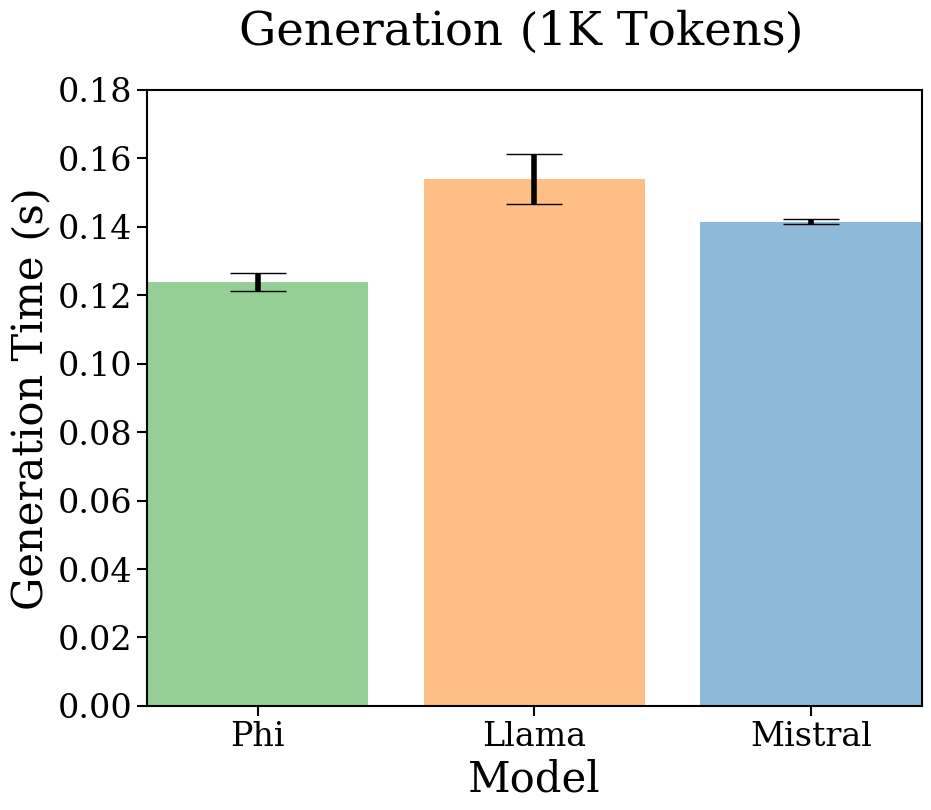

In [97]:
fig, ax = plt.subplots()

labels = ['Phi', 'Llama', 'Mistral']
generation_time_means = [np.mean(phi_generation_times), np.mean(llama_generation_times), np.mean(mistral_generation_times)]
generation_time_std = [np.std(phi_generation_times), np.std(llama_generation_times), np.std(mistral_generation_times)]
generation_time_std_error = [x / np.sqrt(len(phi_generation_times)) for x in generation_time_std]

ax.bar(labels, generation_time_means, yerr=generation_time_std_error, capsize=20, alpha=0.5, color=[default_cycler[2], default_cycler[1], default_cycler[0]])
ax.set_ylabel('Generation Time (s)')
ax.set_xlabel('Model')
ax.grid()

fig.suptitle('Generation (1K Tokens)')
if save_figs:
    fig.savefig(os.path.join(figs_parent, 'generation-time.png'))

plt.show()

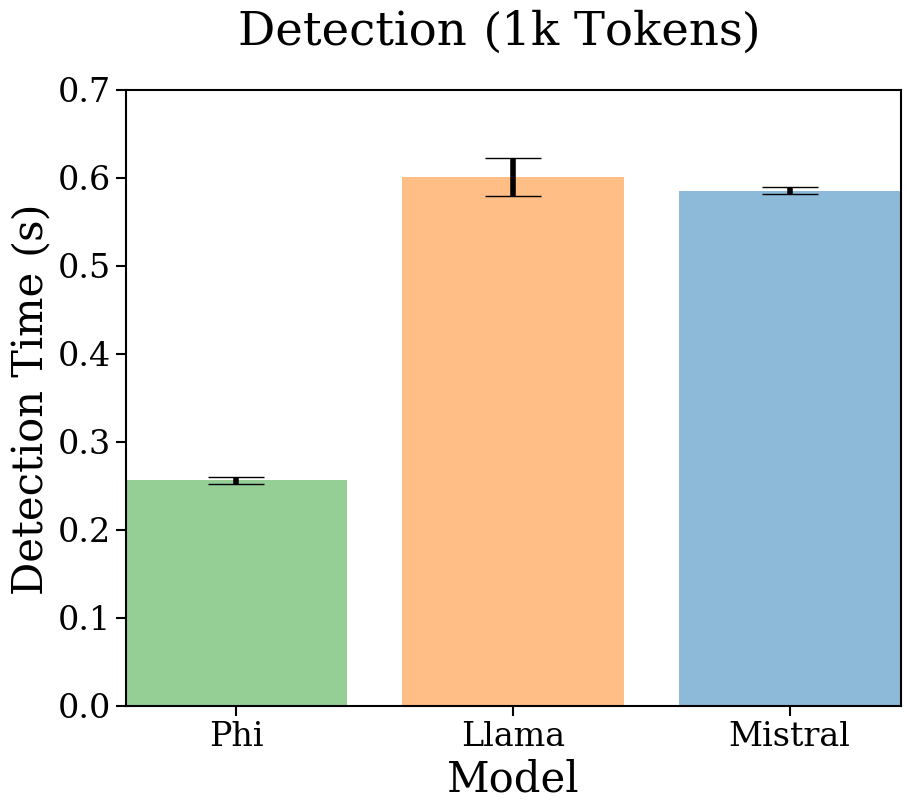

In [99]:
fig, ax = plt.subplots()

labels = ['Phi', 'Llama', 'Mistral']

detection_time_means = [np.mean(phi_detection_times), np.mean(llama_detection_times), np.mean(mistral_detection_times)]
detection_time_std = [np.std(phi_detection_times), np.std(llama_detection_times), np.std(mistral_detection_times)]
detection_time_std_error = [x / np.sqrt(len(phi_detection_times)) for x in detection_time_std]

ax.bar(labels, detection_time_means, yerr=detection_time_std_error, alpha=0.5, capsize=20, color=[default_cycler[2], default_cycler[1], default_cycler[0]])

ax.set_xlabel('Model')
ax.set_ylabel('Detection Time (s)')
ax.grid()
fig.suptitle('Detection (1k Tokens)')
if save_figs:
    fig.savefig(os.path.join(figs_parent, 'detection-time.png'))

plt.show()

# TODO

1) ~~Plot metrics and win rate as a function of variance~~

2)  ~~Plot metrics and win rate as a function of layer~~

3)  ~~Do scatter plot of p-values with square norm~~

4)  Get expected squared norms of various generations

5) ~~Get round trip translation p value distributions and d othe same for uncorrupted distributions~~


6)  Get LASERized plots and win rates for appendix

# Scratch

In [163]:
os.listdir(os.path.join('alpaca_win_rate', '_home_blockadam_gaussian-watermarking_amlt_09-19-alpaca-generate-baseline_grid_09-19-alpaca-generate-baseline_see_133339_wat_meta-llama_Meta-Llama-3.1-8B_____', '09-24/llama_Base/responses.json'))

NotADirectoryError: [Errno 20] Not a directory: 'alpaca_win_rate/_home_blockadam_gaussian-watermarking_amlt_09-19-alpaca-generate-baseline_grid_09-19-alpaca-generate-baseline_see_133339_wat_meta-llama_Meta-Llama-3.1-8B_____/09-24/llama_Base/responses.json'

In [164]:
with open(os.path.join('alpaca_win_rate', '_home_blockadam_gaussian-watermarking_amlt_09-19-alpaca-generate-baseline_grid_09-19-alpaca-generate-baseline_see_133339_wat_meta-llama_Meta-Llama-3.1-8B_____', '09-24/llama_Base/responses.json'), 'r') as f:
    responses = json.load(f)

In [175]:
for parent in os.listdir('alpaca_win_rate'):
    if 'alpaca-generate-baselin' in parent:
        wat_wins, base_wins = get_winrate(os.path.join('alpaca_win_rate', '_home_blockadam_gaussian-watermarking_amlt_09-19-alpaca-generate-baseline_grid_09-19-alpaca-generate-baseline_see_133339_wat_meta-llama_Meta-Llama-3.1-8B_____'))

        print(wat_wins / (wat_wins + base_wins))


alpaca_win_rate/_home_blockadam_gaussian-watermarking_amlt_09-19-alpaca-generate-baseline_grid_09-19-alpaca-generate-baseline_see_133339_wat_meta-llama_Meta-Llama-3.1-8B_____/09-24/llama_Base
0.44680851063829785
alpaca_win_rate/_home_blockadam_gaussian-watermarking_amlt_09-19-alpaca-generate-baseline_grid_09-19-alpaca-generate-baseline_see_133339_wat_meta-llama_Meta-Llama-3.1-8B_____/09-24/llama_Base
0.44680851063829785
alpaca_win_rate/_home_blockadam_gaussian-watermarking_amlt_09-19-alpaca-generate-baseline_grid_09-19-alpaca-generate-baseline_see_133339_wat_meta-llama_Meta-Llama-3.1-8B_____/09-24/llama_Base
0.44680851063829785
alpaca_win_rate/_home_blockadam_gaussian-watermarking_amlt_09-19-alpaca-generate-baseline_grid_09-19-alpaca-generate-baseline_see_133339_wat_meta-llama_Meta-Llama-3.1-8B_____/09-24/llama_Base
0.44680851063829785
alpaca_win_rate/_home_blockadam_gaussian-watermarking_amlt_09-19-alpaca-generate-baseline_grid_09-19-alpaca-generate-baseline_see_133339_wat_meta-llama_

In [184]:

print(f"Llama: {llama_mean:.4f} +/- {llama_std:.4f}")
print(f"Mistral: {mistral_mean:.4f} +/- {mistral_std:.4f}")
print(f"Phi: {phi_mean:.4f} +/- {phi_std:.4f}")

Llama: 0.4072 +/- 0.0396
Mistral: 0.4934 +/- 0.0091
Phi: 0.4435 +/- 0.0025


In [169]:
357/(357+442)

0.44680851063829785